# Further improvements

This notebook performs pilot studies into possible routes for further improving the classification results obtained from the offline experiments.
This includes:
   - Calibration on 5 minutes worth of data
   - Subsampling electrodes

Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Calibrating on 5 minutes of training
   - EEGNet: new session
   - EEGNet: new subject
   - LSTM EEGNet
      - Results
- Subsampling electrodes
   - CSP + LDA
      - Same session
      - New session
      - New subject
- Using more training data
   - EEGNet: new subject

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# EEGNet model with LSTM
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Calibrating on 5 minutes of training

In the data collection setup the marker stayed on the screen for one singular second and was followed by a 1.5 – 2.5 second pause after which the next signal was shown.
This totals 3.5 seconds per sample taken.
As such, in 5 minutes, or 300 seconds, 85 samples should be obtainable.
This is reduced to 75 samples in order to obtain 25 samples per class.
These 25 samples per class are then used for calibration of both the EEGNet model and the EEGNet model extension with LSTM provided by us to compare both.
Different layers are frozen to test different setups.

<hr>

### EEGNet: new session

Results for EEGNet base were:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

Result after calibration are:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6667 @ epoch 459                   | 0.8669 @ epoch 1846              | 0.6429                                           | 0.6181                                            |
| C           | 0.8 @ epoch 39                       | 0.798 @ epoch 2486               | 0.7104                                           | 0.7387                                            |
| E           | 0.7667 @ epoch 56                    | 0.597 @ epoch 2500               | 0.7568                                           | 0.758                                             |

In [ ]:
EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
).layers

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet: new subject

Results for EEGNet base were:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

Result after calibration are:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.6 @ epoch 193                      | 0.8591 @ epoch 194               | 0.6373                                           | 0.6373                                            |
| C (Train B&E) | 0.7667 @ epoch 304                   | 0.6773 @ epoch 2486              | 0.6233                                           | 0.6188                                            |
| E (Train B&C) | 0.7333 @ epoch 85                    | 0.6853 @ epoch 2374              | 0.6432                                           | 0.6602                                            |

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet with LSTM conv: new session

Results before calibration were:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Result after calibration are:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7333 @ epoch 213                             | 0.8291 @ epoch 82                          | 0.6158                                                     | 0.6395                                                      |
| C           | 0.8 @ epoch 1                                  | 0.6055 @ epoch 185                         | 0.6595                                                     | 0.6652                                                      |
| E           | 0.8 @ epoch 11                                 | 0.6687 @ epoch 457                         | 0.6727                                                     | 0.7807                                                      |

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).layers

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_convlstm_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                
                # Allow last layers to train (softmax)
                calibration_model.layers[11].trainable = True
                calibration_model.layers[12].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                
                
                # Change dropout
                calibration_model.layers[6].rate = 0
                calibration_model.layers[9].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet with LSTM conv: new subject

Results before calibration were:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Result after calibration are:

| **Subject**   | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|---------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B (Train C&E) | 0.6667 @ epoch 182                             | 0.8062 @ epoch 366                         | 0.6249                                                     | 0.626                                                       |
| C (Train B&E) | 0.7333 @ epoch 206                             | 0.7253 @ epoch 240                         | 0.621                                                      | 0.6199                                                      |
| E (Train B&C) | 0.8667 @ epoch 9                               | 0.3985 @ epoch 378                         | 0.6625                                                     | 0.7216                                                      |

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_convlstm_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                
                # Allow last layers to train (softmax)
                calibration_model.layers[11].trainable = True
                calibration_model.layers[12].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                
                
                # Change dropout
                calibration_model.layers[6].rate = 0
                calibration_model.layers[9].rate = 0.3
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.00005), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Subsampling electrodes

According to Kaya et al., the authors of the used dataset, the channels of most interest are C3, Cz, C4, T3 and T4.
According to our research these are: T3, C3, Cz, C4 and T4 for primary motor cortex but also P3 and P4 for poor spatial resolution inclusion and F3, Fz and F4 for the premotor cortex.

In [ ]:
mi_channel_list = ["T3", "C3", "Cz", "C4", "T4", "P3", "P4", "F3", "Fz", "F4"]

<hr>

### CSP + LDA

#### Same session

Results using all channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

Results using subsampled channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.5781 +- 0.0212                         | 0.6302                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.6232 +- 0.0118                         | 0.5833                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.5864 +- 0.0153                         | 0.5759                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |


In [ ]:
####################################################
# SAME SESSION TEST
####################################################

# Configure global parameters for all experiments
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this

subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [6, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ###########################################
    # DATA
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        labels = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        
    
    # Create a test and train split
    X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                        labels,
                                                        test_size = 0.2,
                                                        shuffle= True,
                                                        stratify= labels,                                                    
                                                        random_state= 1998)
    
    ###########################################
    # CLASSIFIER
    
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Get the cross val scores
    cv = StratifiedKFold(n_splits=4,
                         shuffle= True,
                         random_state= 2022)
    
    with io.capture_output():
        cv_results = cross_val_score(pipeline, X_train, y_train,
                                     cv=cv, n_jobs=-1)
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print cross val results
    print(f"Validation accuracy (CV) of {np.round(np.mean(cv_results), 4)} +- {np.round(np.std(cv_results), 4)}")
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(mne_raw.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del accuracy
del baseline
del best_found_csp_components
del best_found_solver
del best_found_tol
del csp
del cv
del cv_results
del end_offset
del filter_lower_bound
del filter_upper_bound
del i
del labels
del lda
del mne_epochs
del mne_raw
del pipeline
del start_offset
del subject_ids_to_test
del X_test
del X_train
del y_pred
del y_test
del y_train
del mne_epochs_data


#### New session

Results using all channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

Results using subsampled channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.5781 +- 0.0212                         | 0.6302                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.6232 +- 0.0118                         | 0.5833                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.5864 +- 0.0153                         | 0.5759                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |


In [ ]:
####################################################
# NEW SESSION TEST
####################################################

# Configure global parameters for all experiments
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this

subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ###########################################
    # TRAINING DATA
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Delete raws as they are altered
        del mne_raws
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
    
    
    ###########################################
    # CLASSIFIER
    
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Get the cross val scores
    cv = StratifiedKFold(n_splits=4,
                         shuffle= True,
                         random_state= 2022)
    
    with io.capture_output():
        cv_results = cross_val_score(pipeline, X_train, y_train,
                                     cv=cv, n_jobs=-1)
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print cross val results
    print(f"Validation accuracy (CV) of {np.round(np.mean(cv_results), 4)} +- {np.round(np.std(cv_results), 4)}")
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(mne_raw.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del accuracy
del baseline
del best_found_csp_components
del best_found_solver
del best_found_tol
del csp
del cv
del cv_results
del end_offset
del filter_lower_bound
del filter_upper_bound
del i
del lda
del mne_epochs
del mne_raw
del pipeline
del start_offset
del subject_ids_to_test
del X_test
del X_train
del y_pred
del y_test
del y_train


#### New session

Results using all channels:

| **Subject**      | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|------------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B (Train on C&E) | 0.5662 +- 0.0129                         | 0.3961                             | 10 CSP components \| SVD LDA with 0.0001 tol |
| C (Train on B&E) | 0.4781 +- 0.0185                         | 0.4731                             | 10 CSP components \| lsqr LDA                |
| E (Train on B&C) | 0.5567 +- 0.0287                         | 0.4098                             | 10 CSP components \| SVD LDA with 0.0001 tol |

Results using subsampled channels:

| **Subject**      | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|------------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B (Train on C&E) | 0.5406 +- 0.0128                         | 0.375                              | 10 CSP components \| SVD LDA with 0.0001 tol |
| C (Train on B&E) | 0.4548 +- 0.0071                         | 0.3556                             | 10 CSP components \| lsqr LDA                |
| E (Train on B&C) | 0.4813 +- 0.0219                         | 0.4188                             | 10 CSP components \| SVD LDA with 0.0001 tol |

In [ ]:
####################################################
# NEW SESSION TEST
####################################################

# Configure global parameters for all experiments
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this

subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ###########################################
    # TRAINING DATA
    with io.capture_output():
        # Determine the train subjects
        train_subjects = copy.deepcopy(subject_ids_to_test)
        train_subjects.remove(subject_ids_to_test[i])
        
        mne_raws = []
        
        # Get all training data
        for train_subject in train_subjects:
            mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Delete raws as they are altered
        del mne_raws
        del train_subject
        del train_subjects
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
    
    
    ###########################################
    # CLASSIFIER
    
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Get the cross val scores
    cv = StratifiedKFold(n_splits=4,
                         shuffle= True,
                         random_state= 2022)
    
    with io.capture_output():
        cv_results = cross_val_score(pipeline, X_train, y_train,
                                     cv=cv, n_jobs=-1)
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print cross val results
    print(f"Validation accuracy (CV) of {np.round(np.mean(cv_results), 4)} +- {np.round(np.std(cv_results), 4)}")
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(mne_raw.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del accuracy
del baseline
del best_found_csp_components
del best_found_solver
del best_found_tol
del csp
del cv
del cv_results
del end_offset
del filter_lower_bound
del filter_upper_bound
del i
del lda
del mne_epochs
del mne_raw
del pipeline
del start_offset
del subject_ids_to_test
del X_test
del X_train
del y_pred
del y_test
del y_train


<hr><hr>

## Using more training data

During the experiments only the data of three participants were used as these were the only participants with 3 recorded session for hte CLA paradigm of the open-source data.
To determine if having more data will yield an improvement in the intersubject perfomance of the DL algorithms, we perform this experiment were all possible CLA data is used.
We also can use one subject as validation subject so that we can actually test for the performance on a new subject.

<hr>

### EEGNet: new subject

Shape of all training data (epochs, channels, samples): (8629, 21, 100)
Shape of all val data (epochs, channels, samples): (958, 21, 100)

Results for EEGNet were:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

Result using more training data:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.643 @ epoch 13                     | 0.8224 @ epoch 721               | 0.6917                                           | 0.7281                                            |
| C           | 0.642 @ epoch 1410                   | 0.8225 @ epoch 1970              | 0.5985                                           | 0.5881                                            |
| E           | 0.6461 @ epoch 102                   | 0.8112 @ epoch 857               | 0.8471                                           | 0.866                                             |

Significant improvements are made for subject B, C and E.
The training is stabel and convergence without divergence.

In [6]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 12, # number of temporal filters. (default: 8)
        F2 = 24, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Get all training data
                    training_data, val_data = CLA_dataset.get_data_from_all_but_one_subject(test_subject = "C",
                                                                                            val_subject = "D")
                    
                    # Get epochs for that training MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(training_data,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                    # Get epochs for that validation MNE raw
                    mne_epochs_val = CLA_dataset.get_usefull_epochs_from_raw(val_data,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs_val = mne_epochs_val['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs_val.load_data()
                    
                # Show training data
                print(f"Using data from all participants except testing subject {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                labels_val = mne_epochs_val.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                
                labels_val = labels_val.reshape(-1, 1)
                labels_val = ohe.transform(labels_val).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                mne_epochs_data_val = mne_epochs_val.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                mne_epochs_data_val = mne_epochs_data_val * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/8/moredata/EEGNet/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of all val data (epochs, channels, samples): {np.shape(mne_epochs_data_val)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/8/moredata/EEGNet/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook8_eegnet_newsubject_moredata_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 256, # Default: 32 - further improved since more data available anyway
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (mne_epochs_data_val, labels_val),
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/moredata/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del training_data
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
                del labels_val
                del mne_epochs_data_val
                del mne_epochs_val
                del val_data
                
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Using data from all participants except testing subject B
Shape of all training data (epochs, channels, samples): (8629, 21, 100)
Shape of all val data (epochs, channels, samples): (958, 21, 100)
Epoch 1/2500
34/34 [==============================] - ETA: 0s - loss: 1.0984 - accuracy: 0.3844
Epoch 1: val_loss improved from inf to 1.08557, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.48330, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectB\trained_model_highest_acc_model.hdf5
34/34 [==============================] - 2s 34ms/step - loss: 1.0984 - accuracy: 0.3844 - val_loss: 1.0856 - val_accuracy: 0.4833
Epoch 2/2500
34/34 [==============================] - ETA: 0s - loss: 1.0500 - accuracy: 0.4561
Epoch 2: val_loss improved from 1

34/34 [==============================] - ETA: 0s - loss: 0.8481 - accuracy: 0.6249
Epoch 17: val_loss improved from 0.86130 to 0.85706, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.8481 - accuracy: 0.6249 - val_loss: 0.8571 - val_accuracy: 0.6263
Epoch 18/2500
34/34 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.6295
Epoch 18: val_loss improved from 0.85706 to 0.85652, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 18: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.8497 - accuracy: 0.6295 - val_loss: 0.8565 - val_accuracy: 0.6315
Epoch 19/2500
34/34 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.6289
Epoch 19: val_loss improved from 0.85

Epoch 40/2500
34/34 [==============================] - ETA: 0s - loss: 0.8116 - accuracy: 0.6487
Epoch 40: val_loss did not improve from 0.83948

Epoch 40: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 24ms/step - loss: 0.8116 - accuracy: 0.6487 - val_loss: 0.8402 - val_accuracy: 0.6127
Epoch 41/2500
34/34 [==============================] - ETA: 0s - loss: 0.8122 - accuracy: 0.6500
Epoch 41: val_loss did not improve from 0.83948

Epoch 41: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.8122 - accuracy: 0.6500 - val_loss: 0.8460 - val_accuracy: 0.6127
Epoch 42/2500
34/34 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.6535
Epoch 42: val_loss did not improve from 0.83948

Epoch 42: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.8026 - accuracy: 0.6535 - val_loss: 0.8511 - val_accuracy: 0.6190
Epoch 43/2500
34

Epoch 64/2500
34/34 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.6456
Epoch 64: val_loss did not improve from 0.82944

Epoch 64: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.8045 - accuracy: 0.6456 - val_loss: 0.8418 - val_accuracy: 0.6294
Epoch 65/2500
34/34 [==============================] - ETA: 0s - loss: 0.7953 - accuracy: 0.6545
Epoch 65: val_loss did not improve from 0.82944

Epoch 65: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7953 - accuracy: 0.6545 - val_loss: 0.8313 - val_accuracy: 0.6221
Epoch 66/2500
34/34 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.6548
Epoch 66: val_loss did not improve from 0.82944

Epoch 66: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7993 - accuracy: 0.6548 - val_loss: 0.8487 - val_accuracy: 0.6169
Epoch 67/2500
34

Epoch 89/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7864 - accuracy: 0.6603
Epoch 89: val_loss did not improve from 0.82944

Epoch 89: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 25ms/step - loss: 0.7871 - accuracy: 0.6603 - val_loss: 0.8566 - val_accuracy: 0.5929
Epoch 90/2500
34/34 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.6596
Epoch 90: val_loss did not improve from 0.82944

Epoch 90: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7894 - accuracy: 0.6596 - val_loss: 0.8401 - val_accuracy: 0.6169
Epoch 91/2500
34/34 [==============================] - ETA: 0s - loss: 0.7909 - accuracy: 0.6574
Epoch 91: val_loss did not improve from 0.82944

Epoch 91: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7909 - accuracy: 0.6574 - val_loss: 0.8638 - val_accuracy: 0.5898
Epoch 92/2500
34

Epoch 114/2500
34/34 [==============================] - ETA: 0s - loss: 0.7850 - accuracy: 0.6623
Epoch 114: val_loss did not improve from 0.82944

Epoch 114: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7850 - accuracy: 0.6623 - val_loss: 0.8625 - val_accuracy: 0.5971
Epoch 115/2500
34/34 [==============================] - ETA: 0s - loss: 0.7822 - accuracy: 0.6574
Epoch 115: val_loss did not improve from 0.82944

Epoch 115: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7822 - accuracy: 0.6574 - val_loss: 0.8476 - val_accuracy: 0.6013
Epoch 116/2500
34/34 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.6582
Epoch 116: val_loss did not improve from 0.82944

Epoch 116: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7858 - accuracy: 0.6582 - val_loss: 0.8599 - val_accuracy: 0.5866
Epoch 1

Epoch 139/2500
34/34 [==============================] - ETA: 0s - loss: 0.7813 - accuracy: 0.6654
Epoch 139: val_loss did not improve from 0.82944

Epoch 139: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7813 - accuracy: 0.6654 - val_loss: 0.8698 - val_accuracy: 0.5866
Epoch 140/2500
34/34 [==============================] - ETA: 0s - loss: 0.7792 - accuracy: 0.6690
Epoch 140: val_loss did not improve from 0.82944

Epoch 140: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7792 - accuracy: 0.6690 - val_loss: 0.8533 - val_accuracy: 0.5992
Epoch 141/2500
34/34 [==============================] - ETA: 0s - loss: 0.7799 - accuracy: 0.6693
Epoch 141: val_loss did not improve from 0.82944

Epoch 141: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7799 - accuracy: 0.6693 - val_loss: 0.8652 - val_accuracy: 0.5866
Epoch 1

Epoch 164/2500
34/34 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.6642
Epoch 164: val_loss did not improve from 0.82944

Epoch 164: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7716 - accuracy: 0.6642 - val_loss: 0.8485 - val_accuracy: 0.6075
Epoch 165/2500
34/34 [==============================] - ETA: 0s - loss: 0.7728 - accuracy: 0.6696
Epoch 165: val_loss did not improve from 0.82944

Epoch 165: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7728 - accuracy: 0.6696 - val_loss: 0.8530 - val_accuracy: 0.6002
Epoch 166/2500
34/34 [==============================] - ETA: 0s - loss: 0.7753 - accuracy: 0.6638
Epoch 166: val_loss did not improve from 0.82944

Epoch 166: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7753 - accuracy: 0.6638 - val_loss: 0.8429 - val_accuracy: 0.6096
Epoch 1


Epoch 188: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7699 - accuracy: 0.6760 - val_loss: 0.8342 - val_accuracy: 0.6138
Epoch 189/2500
34/34 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.6673
Epoch 189: val_loss did not improve from 0.82814

Epoch 189: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7666 - accuracy: 0.6673 - val_loss: 0.8431 - val_accuracy: 0.6054
Epoch 190/2500
34/34 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.6807
Epoch 190: val_loss did not improve from 0.82814

Epoch 190: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7696 - accuracy: 0.6807 - val_loss: 0.8480 - val_accuracy: 0.5960
Epoch 191/2500
34/34 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.6661
Epoch 191: val_loss did not improve from 0.82814

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.6750
Epoch 213: val_loss did not improve from 0.82814

Epoch 213: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7633 - accuracy: 0.6750 - val_loss: 0.8321 - val_accuracy: 0.6159
Epoch 214/2500
34/34 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.6654
Epoch 214: val_loss did not improve from 0.82814

Epoch 214: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7698 - accuracy: 0.6654 - val_loss: 0.8510 - val_accuracy: 0.6002
Epoch 215/2500
34/34 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.6719
Epoch 215: val_loss did not improve from 0.82814

Epoch 215: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7661 - accuracy: 0.6719 - val_loss: 0.8521 - val_accuracy: 0.6013
Epoch 216/2500
34/34 [

34/34 [==============================] - 1s 23ms/step - loss: 0.7683 - accuracy: 0.6690 - val_loss: 0.8563 - val_accuracy: 0.5971
Epoch 238/2500
34/34 [==============================] - ETA: 0s - loss: 0.7721 - accuracy: 0.6716
Epoch 238: val_loss did not improve from 0.82769

Epoch 238: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7721 - accuracy: 0.6716 - val_loss: 0.8655 - val_accuracy: 0.5887
Epoch 239/2500
34/34 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.6666
Epoch 239: val_loss did not improve from 0.82769

Epoch 239: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7760 - accuracy: 0.6666 - val_loss: 0.8728 - val_accuracy: 0.5814
Epoch 240/2500
34/34 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.6650
Epoch 240: val_loss did not improve from 0.82769

Epoch 240: val_accuracy did not improve from 0.64301
34/34 [


Epoch 262: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7696 - accuracy: 0.6716 - val_loss: 0.8499 - val_accuracy: 0.6023
Epoch 263/2500
34/34 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.6746
Epoch 263: val_loss did not improve from 0.82769

Epoch 263: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7664 - accuracy: 0.6746 - val_loss: 0.8592 - val_accuracy: 0.5919
Epoch 264/2500
34/34 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.6738
Epoch 264: val_loss did not improve from 0.82769

Epoch 264: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7601 - accuracy: 0.6738 - val_loss: 0.8524 - val_accuracy: 0.5929
Epoch 265/2500
34/34 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.6646
Epoch 265: val_loss did not improve from 0.82769

Epoch 

33/34 [============================>.] - ETA: 0s - loss: 0.7653 - accuracy: 0.6684
Epoch 287: val_loss did not improve from 0.82769

Epoch 287: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7635 - accuracy: 0.6702 - val_loss: 0.8507 - val_accuracy: 0.5981
Epoch 288/2500
34/34 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.6727
Epoch 288: val_loss did not improve from 0.82769

Epoch 288: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7675 - accuracy: 0.6727 - val_loss: 0.8451 - val_accuracy: 0.6106
Epoch 289/2500
34/34 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.6749
Epoch 289: val_loss did not improve from 0.82769

Epoch 289: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7629 - accuracy: 0.6749 - val_loss: 0.8527 - val_accuracy: 0.6002
Epoch 290/2500
34/34 [

Epoch 312/2500
34/34 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.6738
Epoch 312: val_loss did not improve from 0.82769

Epoch 312: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7673 - accuracy: 0.6738 - val_loss: 0.8741 - val_accuracy: 0.5793
Epoch 313/2500
34/34 [==============================] - ETA: 0s - loss: 0.7611 - accuracy: 0.6761
Epoch 313: val_loss did not improve from 0.82769

Epoch 313: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7611 - accuracy: 0.6761 - val_loss: 0.8789 - val_accuracy: 0.5731
Epoch 314/2500
34/34 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.6717
Epoch 314: val_loss did not improve from 0.82769

Epoch 314: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7560 - accuracy: 0.6717 - val_loss: 0.8451 - val_accuracy: 0.6127
Epoch 3

Epoch 337/2500
34/34 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.6744
Epoch 337: val_loss did not improve from 0.82769

Epoch 337: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7629 - accuracy: 0.6744 - val_loss: 0.8548 - val_accuracy: 0.5960
Epoch 338/2500
34/34 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.6818
Epoch 338: val_loss did not improve from 0.82769

Epoch 338: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7555 - accuracy: 0.6818 - val_loss: 0.8476 - val_accuracy: 0.5919
Epoch 339/2500
34/34 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.6737
Epoch 339: val_loss did not improve from 0.82769

Epoch 339: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7572 - accuracy: 0.6737 - val_loss: 0.8440 - val_accuracy: 0.6065
Epoch 3

Epoch 362/2500
34/34 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.6735
Epoch 362: val_loss did not improve from 0.82769

Epoch 362: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7593 - accuracy: 0.6735 - val_loss: 0.8360 - val_accuracy: 0.6127
Epoch 363/2500
34/34 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.6750
Epoch 363: val_loss did not improve from 0.82769

Epoch 363: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7635 - accuracy: 0.6750 - val_loss: 0.8493 - val_accuracy: 0.6054
Epoch 364/2500
34/34 [==============================] - ETA: 0s - loss: 0.7610 - accuracy: 0.6719
Epoch 364: val_loss improved from 0.82769 to 0.82755, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 364: val_accuracy did not improve from 0.64301
34/34 [==================


Epoch 386: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7700 - accuracy: 0.6733 - val_loss: 0.8372 - val_accuracy: 0.6096
Epoch 387/2500
34/34 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.6775
Epoch 387: val_loss did not improve from 0.82755

Epoch 387: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7615 - accuracy: 0.6775 - val_loss: 0.8554 - val_accuracy: 0.6033
Epoch 388/2500
34/34 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.6781
Epoch 388: val_loss did not improve from 0.82755

Epoch 388: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7557 - accuracy: 0.6781 - val_loss: 0.8469 - val_accuracy: 0.6086
Epoch 389/2500
34/34 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.6735
Epoch 389: val_loss did not improve from 0.82755

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.6698
Epoch 411: val_loss did not improve from 0.82755

Epoch 411: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7654 - accuracy: 0.6698 - val_loss: 0.8513 - val_accuracy: 0.6075
Epoch 412/2500
34/34 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.6810
Epoch 412: val_loss did not improve from 0.82755

Epoch 412: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7572 - accuracy: 0.6810 - val_loss: 0.8646 - val_accuracy: 0.5960
Epoch 413/2500
34/34 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.6730
Epoch 413: val_loss did not improve from 0.82755

Epoch 413: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7580 - accuracy: 0.6730 - val_loss: 0.8353 - val_accuracy: 0.6169
Epoch 414/2500
34/34 [

34/34 [==============================] - 1s 22ms/step - loss: 0.7563 - accuracy: 0.6733 - val_loss: 0.8370 - val_accuracy: 0.6117
Epoch 436/2500
34/34 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.6804
Epoch 436: val_loss did not improve from 0.82615

Epoch 436: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7527 - accuracy: 0.6804 - val_loss: 0.8379 - val_accuracy: 0.6096
Epoch 437/2500
34/34 [==============================] - ETA: 0s - loss: 0.7579 - accuracy: 0.6777
Epoch 437: val_loss did not improve from 0.82615

Epoch 437: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7579 - accuracy: 0.6777 - val_loss: 0.8405 - val_accuracy: 0.6127
Epoch 438/2500
34/34 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.6776
Epoch 438: val_loss did not improve from 0.82615

Epoch 438: val_accuracy did not improve from 0.64301
34/34 [


Epoch 460: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7508 - accuracy: 0.6777 - val_loss: 0.8392 - val_accuracy: 0.6148
Epoch 461/2500
34/34 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.6767
Epoch 461: val_loss did not improve from 0.82615

Epoch 461: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7544 - accuracy: 0.6767 - val_loss: 0.8487 - val_accuracy: 0.6106
Epoch 462/2500
34/34 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6769
Epoch 462: val_loss did not improve from 0.82615

Epoch 462: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7600 - accuracy: 0.6769 - val_loss: 0.8541 - val_accuracy: 0.6033
Epoch 463/2500
34/34 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.6805
Epoch 463: val_loss did not improve from 0.82615

Epoch 

Epoch 485/2500
34/34 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.6801
Epoch 485: val_loss did not improve from 0.82446

Epoch 485: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7500 - accuracy: 0.6801 - val_loss: 0.8615 - val_accuracy: 0.6033
Epoch 486/2500
34/34 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.6755
Epoch 486: val_loss did not improve from 0.82446

Epoch 486: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7605 - accuracy: 0.6755 - val_loss: 0.8543 - val_accuracy: 0.5981
Epoch 487/2500
34/34 [==============================] - ETA: 0s - loss: 0.7578 - accuracy: 0.6767
Epoch 487: val_loss did not improve from 0.82446

Epoch 487: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7578 - accuracy: 0.6767 - val_loss: 0.8491 - val_accuracy: 0.6106
Epoch 4

Epoch 510/2500
34/34 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.6826
Epoch 510: val_loss did not improve from 0.82446

Epoch 510: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7533 - accuracy: 0.6826 - val_loss: 0.8456 - val_accuracy: 0.6096
Epoch 511/2500
34/34 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.6746
Epoch 511: val_loss did not improve from 0.82446

Epoch 511: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7542 - accuracy: 0.6746 - val_loss: 0.8526 - val_accuracy: 0.6033
Epoch 512/2500
34/34 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.6769
Epoch 512: val_loss did not improve from 0.82446

Epoch 512: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7528 - accuracy: 0.6769 - val_loss: 0.8429 - val_accuracy: 0.6138
Epoch 5

Epoch 535/2500
34/34 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.6734
Epoch 535: val_loss did not improve from 0.82446

Epoch 535: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7580 - accuracy: 0.6734 - val_loss: 0.8743 - val_accuracy: 0.5846
Epoch 536/2500
34/34 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.6795
Epoch 536: val_loss did not improve from 0.82446

Epoch 536: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7532 - accuracy: 0.6795 - val_loss: 0.8526 - val_accuracy: 0.6044
Epoch 537/2500
34/34 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.6821
Epoch 537: val_loss did not improve from 0.82446

Epoch 537: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7520 - accuracy: 0.6821 - val_loss: 0.8496 - val_accuracy: 0.6075
Epoch 5

Epoch 560/2500
34/34 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.6870
Epoch 560: val_loss did not improve from 0.82446

Epoch 560: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7471 - accuracy: 0.6870 - val_loss: 0.8529 - val_accuracy: 0.6002
Epoch 561/2500
34/34 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.6748
Epoch 561: val_loss did not improve from 0.82446

Epoch 561: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7601 - accuracy: 0.6748 - val_loss: 0.8509 - val_accuracy: 0.6065
Epoch 562/2500
34/34 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.6795
Epoch 562: val_loss did not improve from 0.82446

Epoch 562: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7569 - accuracy: 0.6795 - val_loss: 0.8659 - val_accuracy: 0.5971
Epoch 5

Epoch 585/2500
34/34 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.6781
Epoch 585: val_loss did not improve from 0.82446

Epoch 585: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7483 - accuracy: 0.6781 - val_loss: 0.8563 - val_accuracy: 0.6002
Epoch 586/2500
34/34 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.6815
Epoch 586: val_loss did not improve from 0.82446

Epoch 586: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7476 - accuracy: 0.6815 - val_loss: 0.8715 - val_accuracy: 0.6023
Epoch 587/2500
34/34 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.6841
Epoch 587: val_loss did not improve from 0.82446

Epoch 587: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7506 - accuracy: 0.6841 - val_loss: 0.8779 - val_accuracy: 0.5814
Epoch 5

Epoch 610/2500
34/34 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.6790
Epoch 610: val_loss did not improve from 0.82446

Epoch 610: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7487 - accuracy: 0.6790 - val_loss: 0.8688 - val_accuracy: 0.5939
Epoch 611/2500
34/34 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.6835
Epoch 611: val_loss did not improve from 0.82446

Epoch 611: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7508 - accuracy: 0.6835 - val_loss: 0.8453 - val_accuracy: 0.6086
Epoch 612/2500
34/34 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.6759
Epoch 612: val_loss did not improve from 0.82446

Epoch 612: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7581 - accuracy: 0.6759 - val_loss: 0.8356 - val_accuracy: 0.6117
Epoch 6

Epoch 635/2500
34/34 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.6778
Epoch 635: val_loss did not improve from 0.82446

Epoch 635: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7542 - accuracy: 0.6778 - val_loss: 0.8562 - val_accuracy: 0.6086
Epoch 636/2500
34/34 [==============================] - ETA: 0s - loss: 0.7479 - accuracy: 0.6746
Epoch 636: val_loss did not improve from 0.82446

Epoch 636: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7479 - accuracy: 0.6746 - val_loss: 0.8448 - val_accuracy: 0.6075
Epoch 637/2500
34/34 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.6811
Epoch 637: val_loss did not improve from 0.82446

Epoch 637: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7499 - accuracy: 0.6811 - val_loss: 0.8553 - val_accuracy: 0.5929
Epoch 6

Epoch 660/2500
34/34 [==============================] - ETA: 0s - loss: 0.7512 - accuracy: 0.6786
Epoch 660: val_loss did not improve from 0.82446

Epoch 660: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7512 - accuracy: 0.6786 - val_loss: 0.8696 - val_accuracy: 0.5960
Epoch 661/2500
34/34 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.6815
Epoch 661: val_loss did not improve from 0.82446

Epoch 661: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7529 - accuracy: 0.6815 - val_loss: 0.8587 - val_accuracy: 0.6086
Epoch 662/2500
34/34 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.6769
Epoch 662: val_loss did not improve from 0.82446

Epoch 662: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7533 - accuracy: 0.6769 - val_loss: 0.8426 - val_accuracy: 0.6127
Epoch 6

Epoch 685/2500
34/34 [==============================] - ETA: 0s - loss: 0.7559 - accuracy: 0.6738
Epoch 685: val_loss did not improve from 0.82446

Epoch 685: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7559 - accuracy: 0.6738 - val_loss: 0.8493 - val_accuracy: 0.6054
Epoch 686/2500
34/34 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.6810
Epoch 686: val_loss did not improve from 0.82446

Epoch 686: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7476 - accuracy: 0.6810 - val_loss: 0.8551 - val_accuracy: 0.6065
Epoch 687/2500
34/34 [==============================] - ETA: 0s - loss: 0.7597 - accuracy: 0.6737
Epoch 687: val_loss did not improve from 0.82446

Epoch 687: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7597 - accuracy: 0.6737 - val_loss: 0.8420 - val_accuracy: 0.6148
Epoch 6

Epoch 710/2500
34/34 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.6764
Epoch 710: val_loss did not improve from 0.82446

Epoch 710: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7522 - accuracy: 0.6764 - val_loss: 0.8432 - val_accuracy: 0.6117
Epoch 711/2500
34/34 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.6788
Epoch 711: val_loss did not improve from 0.82446

Epoch 711: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7427 - accuracy: 0.6788 - val_loss: 0.8678 - val_accuracy: 0.5981
Epoch 712/2500
34/34 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.6813
Epoch 712: val_loss did not improve from 0.82446

Epoch 712: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7448 - accuracy: 0.6813 - val_loss: 0.8575 - val_accuracy: 0.6033
Epoch 7


Epoch 734: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7473 - accuracy: 0.6783 - val_loss: 0.8593 - val_accuracy: 0.6002
Epoch 735/2500
34/34 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.6812
Epoch 735: val_loss did not improve from 0.82245

Epoch 735: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7430 - accuracy: 0.6812 - val_loss: 0.8786 - val_accuracy: 0.5866
Epoch 736/2500
34/34 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.6857
Epoch 736: val_loss did not improve from 0.82245

Epoch 736: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7455 - accuracy: 0.6857 - val_loss: 0.8571 - val_accuracy: 0.6013
Epoch 737/2500
34/34 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.6830
Epoch 737: val_loss did not improve from 0.82245

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6883
Epoch 759: val_loss did not improve from 0.82245

Epoch 759: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7412 - accuracy: 0.6883 - val_loss: 0.8881 - val_accuracy: 0.5814
Epoch 760/2500
34/34 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.6755
Epoch 760: val_loss did not improve from 0.82245

Epoch 760: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7471 - accuracy: 0.6755 - val_loss: 0.8595 - val_accuracy: 0.5992
Epoch 761/2500
34/34 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.6810
Epoch 761: val_loss did not improve from 0.82245

Epoch 761: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7484 - accuracy: 0.6810 - val_loss: 0.8422 - val_accuracy: 0.6106
Epoch 762/2500
34/34 [

Epoch 784/2500
34/34 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.6852
Epoch 784: val_loss did not improve from 0.82245

Epoch 784: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7469 - accuracy: 0.6852 - val_loss: 0.8633 - val_accuracy: 0.6023
Epoch 785/2500
34/34 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.6818
Epoch 785: val_loss did not improve from 0.82245

Epoch 785: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7486 - accuracy: 0.6818 - val_loss: 0.8714 - val_accuracy: 0.5919
Epoch 786/2500
34/34 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.6833
Epoch 786: val_loss did not improve from 0.82245

Epoch 786: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7494 - accuracy: 0.6833 - val_loss: 0.8762 - val_accuracy: 0.5877
Epoch 7

Epoch 809/2500
34/34 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.6769
Epoch 809: val_loss did not improve from 0.82245

Epoch 809: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7457 - accuracy: 0.6769 - val_loss: 0.8509 - val_accuracy: 0.5981
Epoch 810/2500
34/34 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6803
Epoch 810: val_loss did not improve from 0.82245

Epoch 810: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7521 - accuracy: 0.6803 - val_loss: 0.8679 - val_accuracy: 0.5939
Epoch 811/2500
34/34 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.6810
Epoch 811: val_loss did not improve from 0.82245

Epoch 811: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7463 - accuracy: 0.6810 - val_loss: 0.8623 - val_accuracy: 0.6075
Epoch 8

Epoch 834/2500
34/34 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.6825
Epoch 834: val_loss did not improve from 0.82245

Epoch 834: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7488 - accuracy: 0.6825 - val_loss: 0.8533 - val_accuracy: 0.5950
Epoch 835/2500
34/34 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.6840
Epoch 835: val_loss did not improve from 0.82245

Epoch 835: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7471 - accuracy: 0.6840 - val_loss: 0.8831 - val_accuracy: 0.5825
Epoch 836/2500
34/34 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.6781
Epoch 836: val_loss did not improve from 0.82245

Epoch 836: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7492 - accuracy: 0.6781 - val_loss: 0.8713 - val_accuracy: 0.5939
Epoch 8

Epoch 859/2500
34/34 [==============================] - ETA: 0s - loss: 0.7479 - accuracy: 0.6828
Epoch 859: val_loss did not improve from 0.82245

Epoch 859: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7479 - accuracy: 0.6828 - val_loss: 0.8520 - val_accuracy: 0.6033
Epoch 860/2500
34/34 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6885
Epoch 860: val_loss did not improve from 0.82245

Epoch 860: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7423 - accuracy: 0.6885 - val_loss: 0.8543 - val_accuracy: 0.6054
Epoch 861/2500
34/34 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.6793
Epoch 861: val_loss did not improve from 0.82245

Epoch 861: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7488 - accuracy: 0.6793 - val_loss: 0.8419 - val_accuracy: 0.6190
Epoch 8

Epoch 884/2500
34/34 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6862
Epoch 884: val_loss did not improve from 0.82245

Epoch 884: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7350 - accuracy: 0.6862 - val_loss: 0.8736 - val_accuracy: 0.5898
Epoch 885/2500
34/34 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.6808
Epoch 885: val_loss did not improve from 0.82245

Epoch 885: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7431 - accuracy: 0.6808 - val_loss: 0.8667 - val_accuracy: 0.5939
Epoch 886/2500
34/34 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.6817
Epoch 886: val_loss did not improve from 0.82245

Epoch 886: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7432 - accuracy: 0.6817 - val_loss: 0.8449 - val_accuracy: 0.6169
Epoch 8

Epoch 909/2500
34/34 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6833
Epoch 909: val_loss did not improve from 0.82245

Epoch 909: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7436 - accuracy: 0.6833 - val_loss: 0.8595 - val_accuracy: 0.5971
Epoch 910/2500
34/34 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.6830
Epoch 910: val_loss did not improve from 0.82245

Epoch 910: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7380 - accuracy: 0.6830 - val_loss: 0.8540 - val_accuracy: 0.6096
Epoch 911/2500
34/34 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.6879
Epoch 911: val_loss did not improve from 0.82245

Epoch 911: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7405 - accuracy: 0.6879 - val_loss: 0.8719 - val_accuracy: 0.5919
Epoch 9

Epoch 934/2500
34/34 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.6806
Epoch 934: val_loss did not improve from 0.82245

Epoch 934: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7442 - accuracy: 0.6806 - val_loss: 0.8535 - val_accuracy: 0.6033
Epoch 935/2500
34/34 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.6835
Epoch 935: val_loss did not improve from 0.82245

Epoch 935: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7463 - accuracy: 0.6835 - val_loss: 0.8662 - val_accuracy: 0.5856
Epoch 936/2500
34/34 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.6837
Epoch 936: val_loss did not improve from 0.82245

Epoch 936: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7399 - accuracy: 0.6837 - val_loss: 0.8577 - val_accuracy: 0.6086
Epoch 9

Epoch 959/2500
34/34 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.6805
Epoch 959: val_loss did not improve from 0.82245

Epoch 959: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7474 - accuracy: 0.6805 - val_loss: 0.8548 - val_accuracy: 0.6033
Epoch 960/2500
34/34 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.6796
Epoch 960: val_loss did not improve from 0.82245

Epoch 960: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7495 - accuracy: 0.6796 - val_loss: 0.8563 - val_accuracy: 0.6054
Epoch 961/2500
34/34 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.6829
Epoch 961: val_loss did not improve from 0.82245

Epoch 961: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7462 - accuracy: 0.6829 - val_loss: 0.8655 - val_accuracy: 0.6013
Epoch 9

Epoch 984/2500
34/34 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.6801
Epoch 984: val_loss did not improve from 0.82245

Epoch 984: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7449 - accuracy: 0.6801 - val_loss: 0.8565 - val_accuracy: 0.5950
Epoch 985/2500
34/34 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.6795
Epoch 985: val_loss did not improve from 0.82245

Epoch 985: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7444 - accuracy: 0.6795 - val_loss: 0.8668 - val_accuracy: 0.5877
Epoch 986/2500
34/34 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.6834
Epoch 986: val_loss did not improve from 0.82245

Epoch 986: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7409 - accuracy: 0.6834 - val_loss: 0.8478 - val_accuracy: 0.6023
Epoch 9

Epoch 1009/2500
34/34 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.6828
Epoch 1009: val_loss did not improve from 0.82245

Epoch 1009: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7478 - accuracy: 0.6828 - val_loss: 0.8498 - val_accuracy: 0.5992
Epoch 1010/2500
34/34 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.6776
Epoch 1010: val_loss did not improve from 0.82245

Epoch 1010: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7473 - accuracy: 0.6776 - val_loss: 0.8788 - val_accuracy: 0.5793
Epoch 1011/2500
34/34 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.6795
Epoch 1011: val_loss did not improve from 0.82245

Epoch 1011: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7503 - accuracy: 0.6795 - val_loss: 0.8865 - val_accuracy: 0.580

34/34 [==============================] - 1s 22ms/step - loss: 0.7373 - accuracy: 0.6892 - val_loss: 0.8693 - val_accuracy: 0.5898
Epoch 1034/2500
34/34 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.6832
Epoch 1034: val_loss did not improve from 0.82245

Epoch 1034: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7455 - accuracy: 0.6832 - val_loss: 0.8596 - val_accuracy: 0.6086
Epoch 1035/2500
34/34 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.6874
Epoch 1035: val_loss did not improve from 0.82245

Epoch 1035: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7381 - accuracy: 0.6874 - val_loss: 0.8816 - val_accuracy: 0.5825
Epoch 1036/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6804
Epoch 1036: val_loss did not improve from 0.82245

Epoch 1036: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.6837
Epoch 1058: val_loss did not improve from 0.82245

Epoch 1058: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7454 - accuracy: 0.6837 - val_loss: 0.8896 - val_accuracy: 0.5720
Epoch 1059/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6866
Epoch 1059: val_loss did not improve from 0.82245

Epoch 1059: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7434 - accuracy: 0.6866 - val_loss: 0.8795 - val_accuracy: 0.5835
Epoch 1060/2500
34/34 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6813
Epoch 1060: val_loss did not improve from 0.82245

Epoch 1060: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7447 - accuracy: 0.6813 - val_loss: 0.8686 - val_accuracy: 0.5898
Epoch 1061/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7453 - accuracy: 0.6814 - val_loss: 0.8520 - val_accuracy: 0.6106
Epoch 1083/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6808
Epoch 1083: val_loss did not improve from 0.82245

Epoch 1083: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7434 - accuracy: 0.6808 - val_loss: 0.8770 - val_accuracy: 0.5804
Epoch 1084/2500
34/34 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.6850
Epoch 1084: val_loss did not improve from 0.82245

Epoch 1084: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7389 - accuracy: 0.6850 - val_loss: 0.8508 - val_accuracy: 0.6075
Epoch 1085/2500
34/34 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.6839
Epoch 1085: val_loss did not improve from 0.82245

Epoch 1085: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.6857
Epoch 1107: val_loss did not improve from 0.82245

Epoch 1107: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7400 - accuracy: 0.6857 - val_loss: 0.8721 - val_accuracy: 0.5919
Epoch 1108/2500
34/34 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.6774
Epoch 1108: val_loss did not improve from 0.82245

Epoch 1108: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7532 - accuracy: 0.6774 - val_loss: 0.8630 - val_accuracy: 0.5971
Epoch 1109/2500
34/34 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6843
Epoch 1109: val_loss did not improve from 0.82245

Epoch 1109: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7352 - accuracy: 0.6843 - val_loss: 0.8517 - val_accuracy: 0.5929
Epoch 1110/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7473 - accuracy: 0.6768 - val_loss: 0.8535 - val_accuracy: 0.5971
Epoch 1132/2500
34/34 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.6865
Epoch 1132: val_loss did not improve from 0.82245

Epoch 1132: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7446 - accuracy: 0.6865 - val_loss: 0.8669 - val_accuracy: 0.5908
Epoch 1133/2500
34/34 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6849
Epoch 1133: val_loss did not improve from 0.82245

Epoch 1133: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7378 - accuracy: 0.6849 - val_loss: 0.8770 - val_accuracy: 0.5908
Epoch 1134/2500
34/34 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.6883
Epoch 1134: val_loss did not improve from 0.82245

Epoch 1134: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.6836
Epoch 1156: val_loss did not improve from 0.82245

Epoch 1156: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7418 - accuracy: 0.6836 - val_loss: 0.8721 - val_accuracy: 0.5877
Epoch 1157/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6829
Epoch 1157: val_loss did not improve from 0.82245

Epoch 1157: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7434 - accuracy: 0.6829 - val_loss: 0.8516 - val_accuracy: 0.6002
Epoch 1158/2500
34/34 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.6779
Epoch 1158: val_loss did not improve from 0.82245

Epoch 1158: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7416 - accuracy: 0.6779 - val_loss: 0.8637 - val_accuracy: 0.5939
Epoch 1159/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7466 - accuracy: 0.6738 - val_loss: 0.8647 - val_accuracy: 0.5919
Epoch 1181/2500
34/34 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.6827
Epoch 1181: val_loss did not improve from 0.82245

Epoch 1181: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7477 - accuracy: 0.6827 - val_loss: 0.8558 - val_accuracy: 0.6044
Epoch 1182/2500
34/34 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.6828
Epoch 1182: val_loss did not improve from 0.82245

Epoch 1182: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7480 - accuracy: 0.6828 - val_loss: 0.8629 - val_accuracy: 0.5960
Epoch 1183/2500
34/34 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.6842
Epoch 1183: val_loss did not improve from 0.82245

Epoch 1183: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.6894
Epoch 1205: val_loss did not improve from 0.82245

Epoch 1205: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7349 - accuracy: 0.6894 - val_loss: 0.8714 - val_accuracy: 0.5939
Epoch 1206/2500
34/34 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.6817
Epoch 1206: val_loss did not improve from 0.82245

Epoch 1206: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7467 - accuracy: 0.6817 - val_loss: 0.8529 - val_accuracy: 0.6106
Epoch 1207/2500
34/34 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.6864
Epoch 1207: val_loss did not improve from 0.82245

Epoch 1207: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7328 - accuracy: 0.6864 - val_loss: 0.8609 - val_accuracy: 0.5950
Epoch 1208/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7488 - accuracy: 0.6785 - val_loss: 0.8624 - val_accuracy: 0.5971
Epoch 1230/2500
34/34 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.6811
Epoch 1230: val_loss did not improve from 0.82245

Epoch 1230: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7342 - accuracy: 0.6811 - val_loss: 0.8850 - val_accuracy: 0.5835
Epoch 1231/2500
34/34 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6842
Epoch 1231: val_loss did not improve from 0.82245

Epoch 1231: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7403 - accuracy: 0.6842 - val_loss: 0.8502 - val_accuracy: 0.6075
Epoch 1232/2500
34/34 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6789
Epoch 1232: val_loss did not improve from 0.82245

Epoch 1232: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.6852
Epoch 1254: val_loss did not improve from 0.82245

Epoch 1254: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7327 - accuracy: 0.6852 - val_loss: 0.8701 - val_accuracy: 0.5908
Epoch 1255/2500
34/34 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.6814
Epoch 1255: val_loss did not improve from 0.82245

Epoch 1255: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7372 - accuracy: 0.6814 - val_loss: 0.8581 - val_accuracy: 0.5981
Epoch 1256/2500
34/34 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.6840
Epoch 1256: val_loss did not improve from 0.82245

Epoch 1256: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7396 - accuracy: 0.6840 - val_loss: 0.8766 - val_accuracy: 0.5887
Epoch 1257/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7399 - accuracy: 0.6832 - val_loss: 0.8898 - val_accuracy: 0.5825
Epoch 1279/2500
34/34 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.6886
Epoch 1279: val_loss did not improve from 0.82245

Epoch 1279: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7343 - accuracy: 0.6886 - val_loss: 0.8749 - val_accuracy: 0.5919
Epoch 1280/2500
34/34 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.6822
Epoch 1280: val_loss did not improve from 0.82245

Epoch 1280: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7435 - accuracy: 0.6822 - val_loss: 0.8521 - val_accuracy: 0.6044
Epoch 1281/2500
34/34 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.6825
Epoch 1281: val_loss did not improve from 0.82245

Epoch 1281: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.6843
Epoch 1303: val_loss did not improve from 0.82245

Epoch 1303: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7430 - accuracy: 0.6843 - val_loss: 0.8642 - val_accuracy: 0.6013
Epoch 1304/2500
34/34 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6798
Epoch 1304: val_loss did not improve from 0.82245

Epoch 1304: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7378 - accuracy: 0.6798 - val_loss: 0.8848 - val_accuracy: 0.5783
Epoch 1305/2500
34/34 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.6836
Epoch 1305: val_loss did not improve from 0.82245

Epoch 1305: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7405 - accuracy: 0.6836 - val_loss: 0.8665 - val_accuracy: 0.5981
Epoch 1306/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7345 - accuracy: 0.6898 - val_loss: 0.8898 - val_accuracy: 0.5856
Epoch 1328/2500
34/34 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.6779
Epoch 1328: val_loss did not improve from 0.82245

Epoch 1328: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7432 - accuracy: 0.6779 - val_loss: 0.8458 - val_accuracy: 0.6096
Epoch 1329/2500
34/34 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.6799
Epoch 1329: val_loss did not improve from 0.82245

Epoch 1329: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7442 - accuracy: 0.6799 - val_loss: 0.8555 - val_accuracy: 0.6044
Epoch 1330/2500
34/34 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6835
Epoch 1330: val_loss did not improve from 0.82245

Epoch 1330: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6844
Epoch 1352: val_loss did not improve from 0.82245

Epoch 1352: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7379 - accuracy: 0.6844 - val_loss: 0.8704 - val_accuracy: 0.5950
Epoch 1353/2500
34/34 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6849
Epoch 1353: val_loss did not improve from 0.82245

Epoch 1353: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7412 - accuracy: 0.6849 - val_loss: 0.8857 - val_accuracy: 0.5846
Epoch 1354/2500
34/34 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.6891
Epoch 1354: val_loss did not improve from 0.82245

Epoch 1354: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7249 - accuracy: 0.6891 - val_loss: 0.8516 - val_accuracy: 0.5981
Epoch 1355/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7382 - accuracy: 0.6863 - val_loss: 0.8749 - val_accuracy: 0.5919
Epoch 1377/2500
34/34 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.6848
Epoch 1377: val_loss did not improve from 0.82245

Epoch 1377: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7417 - accuracy: 0.6848 - val_loss: 0.8696 - val_accuracy: 0.6023
Epoch 1378/2500
34/34 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.6899
Epoch 1378: val_loss did not improve from 0.82245

Epoch 1378: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7275 - accuracy: 0.6899 - val_loss: 0.8778 - val_accuracy: 0.5887
Epoch 1379/2500
34/34 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.6851
Epoch 1379: val_loss did not improve from 0.82245

Epoch 1379: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6881
Epoch 1401: val_loss did not improve from 0.82245

Epoch 1401: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7312 - accuracy: 0.6881 - val_loss: 0.8657 - val_accuracy: 0.5960
Epoch 1402/2500
34/34 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.6849
Epoch 1402: val_loss did not improve from 0.82245

Epoch 1402: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7313 - accuracy: 0.6849 - val_loss: 0.8651 - val_accuracy: 0.5960
Epoch 1403/2500
34/34 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.6851
Epoch 1403: val_loss did not improve from 0.82245

Epoch 1403: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7357 - accuracy: 0.6851 - val_loss: 0.8976 - val_accuracy: 0.5731
Epoch 1404/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7370 - accuracy: 0.6807 - val_loss: 0.8695 - val_accuracy: 0.6086
Epoch 1426/2500
34/34 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.6836
Epoch 1426: val_loss did not improve from 0.82245

Epoch 1426: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7397 - accuracy: 0.6836 - val_loss: 0.8631 - val_accuracy: 0.6002
Epoch 1427/2500
34/34 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6886
Epoch 1427: val_loss did not improve from 0.82245

Epoch 1427: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7352 - accuracy: 0.6886 - val_loss: 0.8568 - val_accuracy: 0.5939
Epoch 1428/2500
34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6840
Epoch 1428: val_loss did not improve from 0.82245

Epoch 1428: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6814
Epoch 1450: val_loss did not improve from 0.82245

Epoch 1450: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7403 - accuracy: 0.6814 - val_loss: 0.8931 - val_accuracy: 0.5762
Epoch 1451/2500
34/34 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.6859
Epoch 1451: val_loss did not improve from 0.82245

Epoch 1451: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7353 - accuracy: 0.6859 - val_loss: 0.8641 - val_accuracy: 0.5992
Epoch 1452/2500
34/34 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.6842
Epoch 1452: val_loss did not improve from 0.82245

Epoch 1452: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7373 - accuracy: 0.6842 - val_loss: 0.8784 - val_accuracy: 0.5898
Epoch 1453/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7374 - accuracy: 0.6874 - val_loss: 0.9012 - val_accuracy: 0.5710
Epoch 1475/2500
34/34 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.6842
Epoch 1475: val_loss did not improve from 0.82245

Epoch 1475: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7396 - accuracy: 0.6842 - val_loss: 0.8846 - val_accuracy: 0.5804
Epoch 1476/2500
34/34 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.6820
Epoch 1476: val_loss did not improve from 0.82245

Epoch 1476: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7387 - accuracy: 0.6820 - val_loss: 0.8685 - val_accuracy: 0.5939
Epoch 1477/2500
34/34 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6856
Epoch 1477: val_loss did not improve from 0.82245

Epoch 1477: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6798
Epoch 1499: val_loss did not improve from 0.82245

Epoch 1499: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7388 - accuracy: 0.6798 - val_loss: 0.8648 - val_accuracy: 0.5877
Epoch 1500/2500
34/34 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.6813
Epoch 1500: val_loss did not improve from 0.82245

Epoch 1500: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7351 - accuracy: 0.6813 - val_loss: 0.8810 - val_accuracy: 0.5772
Epoch 1501/2500
34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6828
Epoch 1501: val_loss did not improve from 0.82245

Epoch 1501: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7395 - accuracy: 0.6828 - val_loss: 0.8812 - val_accuracy: 0.5804
Epoch 1502/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7354 - accuracy: 0.6840 - val_loss: 0.8730 - val_accuracy: 0.5887
Epoch 1524/2500
34/34 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.6878
Epoch 1524: val_loss did not improve from 0.82245

Epoch 1524: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7394 - accuracy: 0.6878 - val_loss: 0.8560 - val_accuracy: 0.5950
Epoch 1525/2500
34/34 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.6820
Epoch 1525: val_loss did not improve from 0.82245

Epoch 1525: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7406 - accuracy: 0.6820 - val_loss: 0.8795 - val_accuracy: 0.5919
Epoch 1526/2500
34/34 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6884
Epoch 1526: val_loss did not improve from 0.82245

Epoch 1526: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.6841
Epoch 1548: val_loss did not improve from 0.82245

Epoch 1548: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7305 - accuracy: 0.6841 - val_loss: 0.8636 - val_accuracy: 0.6044
Epoch 1549/2500
34/34 [==============================] - ETA: 0s - loss: 0.7355 - accuracy: 0.6877
Epoch 1549: val_loss did not improve from 0.82245

Epoch 1549: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7355 - accuracy: 0.6877 - val_loss: 0.8562 - val_accuracy: 0.6044
Epoch 1550/2500
34/34 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6863
Epoch 1550: val_loss did not improve from 0.82245

Epoch 1550: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7350 - accuracy: 0.6863 - val_loss: 0.8707 - val_accuracy: 0.6023
Epoch 1551/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7430 - accuracy: 0.6789 - val_loss: 0.8532 - val_accuracy: 0.6054
Epoch 1573/2500
34/34 [==============================] - ETA: 0s - loss: 0.7382 - accuracy: 0.6871
Epoch 1573: val_loss did not improve from 0.82245

Epoch 1573: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7382 - accuracy: 0.6871 - val_loss: 0.8891 - val_accuracy: 0.5793
Epoch 1574/2500
34/34 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.6900
Epoch 1574: val_loss did not improve from 0.82245

Epoch 1574: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7316 - accuracy: 0.6900 - val_loss: 0.8674 - val_accuracy: 0.5898
Epoch 1575/2500
34/34 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.6840
Epoch 1575: val_loss did not improve from 0.82245

Epoch 1575: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.6894
Epoch 1597: val_loss did not improve from 0.82245

Epoch 1597: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7288 - accuracy: 0.6894 - val_loss: 0.8800 - val_accuracy: 0.5793
Epoch 1598/2500
34/34 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.6886
Epoch 1598: val_loss did not improve from 0.82245

Epoch 1598: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7351 - accuracy: 0.6886 - val_loss: 0.8838 - val_accuracy: 0.5898
Epoch 1599/2500
34/34 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.6873
Epoch 1599: val_loss did not improve from 0.82245

Epoch 1599: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7360 - accuracy: 0.6873 - val_loss: 0.8956 - val_accuracy: 0.5804
Epoch 1600/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7330 - accuracy: 0.6872 - val_loss: 0.8754 - val_accuracy: 0.5877
Epoch 1622/2500
34/34 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6847
Epoch 1622: val_loss did not improve from 0.82245

Epoch 1622: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7291 - accuracy: 0.6847 - val_loss: 0.8962 - val_accuracy: 0.5720
Epoch 1623/2500
34/34 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.6869
Epoch 1623: val_loss did not improve from 0.82245

Epoch 1623: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7349 - accuracy: 0.6869 - val_loss: 0.8796 - val_accuracy: 0.5898
Epoch 1624/2500
34/34 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6888
Epoch 1624: val_loss did not improve from 0.82245

Epoch 1624: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.6844
Epoch 1646: val_loss did not improve from 0.82245

Epoch 1646: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7387 - accuracy: 0.6844 - val_loss: 0.8880 - val_accuracy: 0.5804
Epoch 1647/2500
34/34 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.6820
Epoch 1647: val_loss did not improve from 0.82245

Epoch 1647: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7425 - accuracy: 0.6820 - val_loss: 0.8742 - val_accuracy: 0.5877
Epoch 1648/2500
34/34 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.6833
Epoch 1648: val_loss did not improve from 0.82245

Epoch 1648: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7406 - accuracy: 0.6833 - val_loss: 0.8722 - val_accuracy: 0.5929
Epoch 1649/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7371 - accuracy: 0.6814 - val_loss: 0.8663 - val_accuracy: 0.5992
Epoch 1671/2500
34/34 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6833
Epoch 1671: val_loss did not improve from 0.82245

Epoch 1671: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7315 - accuracy: 0.6833 - val_loss: 0.8557 - val_accuracy: 0.5960
Epoch 1672/2500
34/34 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.6928
Epoch 1672: val_loss did not improve from 0.82245

Epoch 1672: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7274 - accuracy: 0.6928 - val_loss: 0.8725 - val_accuracy: 0.5898
Epoch 1673/2500
34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6855
Epoch 1673: val_loss did not improve from 0.82245

Epoch 1673: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.6898
Epoch 1695: val_loss did not improve from 0.82245

Epoch 1695: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7323 - accuracy: 0.6898 - val_loss: 0.8663 - val_accuracy: 0.5950
Epoch 1696/2500
34/34 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.6848
Epoch 1696: val_loss did not improve from 0.82245

Epoch 1696: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7342 - accuracy: 0.6848 - val_loss: 0.9065 - val_accuracy: 0.5658
Epoch 1697/2500
34/34 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.6803
Epoch 1697: val_loss did not improve from 0.82245

Epoch 1697: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7437 - accuracy: 0.6803 - val_loss: 0.8675 - val_accuracy: 0.5919
Epoch 1698/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7438 - accuracy: 0.6842 - val_loss: 0.8676 - val_accuracy: 0.5981
Epoch 1720/2500
34/34 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.6847
Epoch 1720: val_loss did not improve from 0.82245

Epoch 1720: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7369 - accuracy: 0.6847 - val_loss: 0.8889 - val_accuracy: 0.5752
Epoch 1721/2500
34/34 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.6908
Epoch 1721: val_loss did not improve from 0.82245

Epoch 1721: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7329 - accuracy: 0.6908 - val_loss: 0.8928 - val_accuracy: 0.5720
Epoch 1722/2500
34/34 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6812
Epoch 1722: val_loss did not improve from 0.82245

Epoch 1722: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.6814
Epoch 1744: val_loss did not improve from 0.82245

Epoch 1744: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7411 - accuracy: 0.6814 - val_loss: 0.8778 - val_accuracy: 0.5898
Epoch 1745/2500
34/34 [==============================] - ETA: 0s - loss: 0.7295 - accuracy: 0.6885
Epoch 1745: val_loss did not improve from 0.82245

Epoch 1745: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7295 - accuracy: 0.6885 - val_loss: 0.8647 - val_accuracy: 0.6044
Epoch 1746/2500
34/34 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.6857
Epoch 1746: val_loss did not improve from 0.82245

Epoch 1746: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7374 - accuracy: 0.6857 - val_loss: 0.8731 - val_accuracy: 0.5939
Epoch 1747/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7277 - accuracy: 0.6891 - val_loss: 0.8886 - val_accuracy: 0.5846
Epoch 1769/2500
34/34 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.6862
Epoch 1769: val_loss did not improve from 0.82245

Epoch 1769: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7397 - accuracy: 0.6862 - val_loss: 0.8991 - val_accuracy: 0.5710
Epoch 1770/2500
34/34 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.6841
Epoch 1770: val_loss did not improve from 0.82245

Epoch 1770: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7368 - accuracy: 0.6841 - val_loss: 0.8625 - val_accuracy: 0.5960
Epoch 1771/2500
34/34 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.6812
Epoch 1771: val_loss did not improve from 0.82245

Epoch 1771: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.6850
Epoch 1793: val_loss did not improve from 0.82245

Epoch 1793: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7452 - accuracy: 0.6850 - val_loss: 0.8510 - val_accuracy: 0.5971
Epoch 1794/2500
34/34 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6834
Epoch 1794: val_loss did not improve from 0.82245

Epoch 1794: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7386 - accuracy: 0.6834 - val_loss: 0.8627 - val_accuracy: 0.6054
Epoch 1795/2500
34/34 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6863
Epoch 1795: val_loss did not improve from 0.82245

Epoch 1795: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7436 - accuracy: 0.6863 - val_loss: 0.8595 - val_accuracy: 0.6023
Epoch 1796/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7377 - accuracy: 0.6870 - val_loss: 0.8973 - val_accuracy: 0.5741
Epoch 1818/2500
34/34 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.6828
Epoch 1818: val_loss did not improve from 0.82245

Epoch 1818: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7411 - accuracy: 0.6828 - val_loss: 0.8932 - val_accuracy: 0.5846
Epoch 1819/2500
34/34 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.6861
Epoch 1819: val_loss did not improve from 0.82245

Epoch 1819: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7370 - accuracy: 0.6861 - val_loss: 0.8887 - val_accuracy: 0.5887
Epoch 1820/2500
34/34 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6821
Epoch 1820: val_loss did not improve from 0.82245

Epoch 1820: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6830
Epoch 1842: val_loss did not improve from 0.82245

Epoch 1842: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7348 - accuracy: 0.6830 - val_loss: 0.8781 - val_accuracy: 0.5846
Epoch 1843/2500
34/34 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.6894
Epoch 1843: val_loss did not improve from 0.82245

Epoch 1843: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7277 - accuracy: 0.6894 - val_loss: 0.8617 - val_accuracy: 0.6013
Epoch 1844/2500
34/34 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.6828
Epoch 1844: val_loss did not improve from 0.82245

Epoch 1844: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7326 - accuracy: 0.6828 - val_loss: 0.8686 - val_accuracy: 0.5992
Epoch 1845/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7323 - accuracy: 0.6835 - val_loss: 0.8774 - val_accuracy: 0.5960
Epoch 1867/2500
34/34 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6813
Epoch 1867: val_loss did not improve from 0.82245

Epoch 1867: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7315 - accuracy: 0.6813 - val_loss: 0.8492 - val_accuracy: 0.6086
Epoch 1868/2500
34/34 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.6834
Epoch 1868: val_loss did not improve from 0.82245

Epoch 1868: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7385 - accuracy: 0.6834 - val_loss: 0.9063 - val_accuracy: 0.5752
Epoch 1869/2500
34/34 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.6907
Epoch 1869: val_loss did not improve from 0.82245

Epoch 1869: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7233 - accuracy: 0.6929
Epoch 1891: val_loss did not improve from 0.82245

Epoch 1891: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7233 - accuracy: 0.6929 - val_loss: 0.8698 - val_accuracy: 0.5960
Epoch 1892/2500
34/34 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.6901
Epoch 1892: val_loss did not improve from 0.82245

Epoch 1892: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7288 - accuracy: 0.6901 - val_loss: 0.8909 - val_accuracy: 0.5866
Epoch 1893/2500
34/34 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.6814
Epoch 1893: val_loss did not improve from 0.82245

Epoch 1893: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7365 - accuracy: 0.6814 - val_loss: 0.8727 - val_accuracy: 0.5835
Epoch 1894/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7323 - accuracy: 0.6885 - val_loss: 0.8732 - val_accuracy: 0.5825
Epoch 1916/2500
34/34 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.6912
Epoch 1916: val_loss did not improve from 0.82245

Epoch 1916: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7311 - accuracy: 0.6912 - val_loss: 0.8579 - val_accuracy: 0.6033
Epoch 1917/2500
34/34 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6803
Epoch 1917: val_loss did not improve from 0.82245

Epoch 1917: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7436 - accuracy: 0.6803 - val_loss: 0.8970 - val_accuracy: 0.5720
Epoch 1918/2500
34/34 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.6908
Epoch 1918: val_loss did not improve from 0.82245

Epoch 1918: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6883
Epoch 1940: val_loss did not improve from 0.82245

Epoch 1940: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7291 - accuracy: 0.6883 - val_loss: 0.8869 - val_accuracy: 0.5846
Epoch 1941/2500
34/34 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.6862
Epoch 1941: val_loss did not improve from 0.82245

Epoch 1941: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7357 - accuracy: 0.6862 - val_loss: 0.8537 - val_accuracy: 0.6106
Epoch 1942/2500
34/34 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.6786
Epoch 1942: val_loss did not improve from 0.82245

Epoch 1942: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7383 - accuracy: 0.6786 - val_loss: 0.8707 - val_accuracy: 0.5919
Epoch 1943/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7284 - accuracy: 0.6895 - val_loss: 0.8685 - val_accuracy: 0.5971
Epoch 1965/2500
34/34 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.6854
Epoch 1965: val_loss did not improve from 0.82245

Epoch 1965: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7293 - accuracy: 0.6854 - val_loss: 0.9026 - val_accuracy: 0.5720
Epoch 1966/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6824
Epoch 1966: val_loss did not improve from 0.82245

Epoch 1966: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7434 - accuracy: 0.6824 - val_loss: 0.8752 - val_accuracy: 0.5919
Epoch 1967/2500
34/34 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6866
Epoch 1967: val_loss did not improve from 0.82245

Epoch 1967: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.6814
Epoch 1989: val_loss did not improve from 0.82245

Epoch 1989: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7391 - accuracy: 0.6814 - val_loss: 0.9011 - val_accuracy: 0.5752
Epoch 1990/2500
34/34 [==============================] - ETA: 0s - loss: 0.7257 - accuracy: 0.6912
Epoch 1990: val_loss did not improve from 0.82245

Epoch 1990: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7257 - accuracy: 0.6912 - val_loss: 0.8698 - val_accuracy: 0.6033
Epoch 1991/2500
34/34 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.6861
Epoch 1991: val_loss did not improve from 0.82245

Epoch 1991: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7383 - accuracy: 0.6861 - val_loss: 0.9115 - val_accuracy: 0.5678
Epoch 1992/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7348 - accuracy: 0.6885 - val_loss: 0.8536 - val_accuracy: 0.6044
Epoch 2014/2500
34/34 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.6856
Epoch 2014: val_loss did not improve from 0.82245

Epoch 2014: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7301 - accuracy: 0.6856 - val_loss: 0.8954 - val_accuracy: 0.5804
Epoch 2015/2500
34/34 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6903
Epoch 2015: val_loss did not improve from 0.82245

Epoch 2015: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7332 - accuracy: 0.6903 - val_loss: 0.8787 - val_accuracy: 0.5856
Epoch 2016/2500
34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6846
Epoch 2016: val_loss did not improve from 0.82245

Epoch 2016: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.6847
Epoch 2038: val_loss did not improve from 0.82245

Epoch 2038: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7366 - accuracy: 0.6847 - val_loss: 0.8869 - val_accuracy: 0.5866
Epoch 2039/2500
34/34 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.6768
Epoch 2039: val_loss did not improve from 0.82245

Epoch 2039: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7414 - accuracy: 0.6768 - val_loss: 0.8682 - val_accuracy: 0.5939
Epoch 2040/2500
34/34 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.6899
Epoch 2040: val_loss did not improve from 0.82245

Epoch 2040: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7261 - accuracy: 0.6899 - val_loss: 0.8958 - val_accuracy: 0.5804
Epoch 2041/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7290 - accuracy: 0.6873 - val_loss: 0.8719 - val_accuracy: 0.5950
Epoch 2063/2500
34/34 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.6827
Epoch 2063: val_loss did not improve from 0.82245

Epoch 2063: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7425 - accuracy: 0.6827 - val_loss: 0.8866 - val_accuracy: 0.5793
Epoch 2064/2500
34/34 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.6873
Epoch 2064: val_loss did not improve from 0.82245

Epoch 2064: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7426 - accuracy: 0.6873 - val_loss: 0.8554 - val_accuracy: 0.6013
Epoch 2065/2500
34/34 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.6878
Epoch 2065: val_loss did not improve from 0.82245

Epoch 2065: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.6883
Epoch 2087: val_loss did not improve from 0.82245

Epoch 2087: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7390 - accuracy: 0.6883 - val_loss: 0.8745 - val_accuracy: 0.5877
Epoch 2088/2500
34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6898
Epoch 2088: val_loss did not improve from 0.82245

Epoch 2088: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7312 - accuracy: 0.6898 - val_loss: 0.8697 - val_accuracy: 0.5981
Epoch 2089/2500
34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6941
Epoch 2089: val_loss did not improve from 0.82245

Epoch 2089: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7331 - accuracy: 0.6941 - val_loss: 0.8830 - val_accuracy: 0.5919
Epoch 2090/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7341 - accuracy: 0.6884 - val_loss: 0.8903 - val_accuracy: 0.5835
Epoch 2112/2500
34/34 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.6863
Epoch 2112: val_loss did not improve from 0.82245

Epoch 2112: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7369 - accuracy: 0.6863 - val_loss: 0.8654 - val_accuracy: 0.5960
Epoch 2113/2500
34/34 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.6830
Epoch 2113: val_loss did not improve from 0.82245

Epoch 2113: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7418 - accuracy: 0.6830 - val_loss: 0.8698 - val_accuracy: 0.6013
Epoch 2114/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6818
Epoch 2114: val_loss did not improve from 0.82245

Epoch 2114: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.6884
Epoch 2136: val_loss did not improve from 0.82245

Epoch 2136: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7313 - accuracy: 0.6884 - val_loss: 0.8522 - val_accuracy: 0.6086
Epoch 2137/2500
34/34 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6863
Epoch 2137: val_loss did not improve from 0.82245

Epoch 2137: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7333 - accuracy: 0.6863 - val_loss: 0.8830 - val_accuracy: 0.5762
Epoch 2138/2500
34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6874
Epoch 2138: val_loss did not improve from 0.82245

Epoch 2138: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7312 - accuracy: 0.6874 - val_loss: 0.8623 - val_accuracy: 0.6013
Epoch 2139/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7330 - accuracy: 0.6849 - val_loss: 0.8781 - val_accuracy: 0.5877
Epoch 2161/2500
34/34 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6827
Epoch 2161: val_loss did not improve from 0.82245

Epoch 2161: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7350 - accuracy: 0.6827 - val_loss: 0.8933 - val_accuracy: 0.5731
Epoch 2162/2500
34/34 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.6957
Epoch 2162: val_loss did not improve from 0.82245

Epoch 2162: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7259 - accuracy: 0.6957 - val_loss: 0.8662 - val_accuracy: 0.6054
Epoch 2163/2500
34/34 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.6939
Epoch 2163: val_loss did not improve from 0.82245

Epoch 2163: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.6828
Epoch 2185: val_loss did not improve from 0.82245

Epoch 2185: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7360 - accuracy: 0.6828 - val_loss: 0.8922 - val_accuracy: 0.5752
Epoch 2186/2500
34/34 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.6864
Epoch 2186: val_loss did not improve from 0.82245

Epoch 2186: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7370 - accuracy: 0.6864 - val_loss: 0.8753 - val_accuracy: 0.5887
Epoch 2187/2500
34/34 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.6929
Epoch 2187: val_loss did not improve from 0.82245

Epoch 2187: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7272 - accuracy: 0.6929 - val_loss: 0.8770 - val_accuracy: 0.5793
Epoch 2188/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7346 - accuracy: 0.6836 - val_loss: 0.9035 - val_accuracy: 0.5710
Epoch 2210/2500
34/34 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.6839
Epoch 2210: val_loss did not improve from 0.82245

Epoch 2210: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7285 - accuracy: 0.6839 - val_loss: 0.8898 - val_accuracy: 0.5866
Epoch 2211/2500
34/34 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.6874
Epoch 2211: val_loss did not improve from 0.82245

Epoch 2211: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7299 - accuracy: 0.6874 - val_loss: 0.8663 - val_accuracy: 0.5908
Epoch 2212/2500
34/34 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.6910
Epoch 2212: val_loss did not improve from 0.82245

Epoch 2212: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.6852
Epoch 2234: val_loss did not improve from 0.82245

Epoch 2234: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7417 - accuracy: 0.6852 - val_loss: 0.8956 - val_accuracy: 0.5814
Epoch 2235/2500
34/34 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.6817
Epoch 2235: val_loss did not improve from 0.82245

Epoch 2235: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7399 - accuracy: 0.6817 - val_loss: 0.8879 - val_accuracy: 0.5825
Epoch 2236/2500
34/34 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.6821
Epoch 2236: val_loss did not improve from 0.82245

Epoch 2236: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7448 - accuracy: 0.6821 - val_loss: 0.8902 - val_accuracy: 0.5814
Epoch 2237/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7316 - accuracy: 0.6854 - val_loss: 0.8647 - val_accuracy: 0.6023
Epoch 2259/2500
34/34 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.6857
Epoch 2259: val_loss did not improve from 0.82245

Epoch 2259: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7311 - accuracy: 0.6857 - val_loss: 0.8857 - val_accuracy: 0.5835
Epoch 2260/2500
34/34 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.6876
Epoch 2260: val_loss did not improve from 0.82245

Epoch 2260: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7294 - accuracy: 0.6876 - val_loss: 0.8723 - val_accuracy: 0.6002
Epoch 2261/2500
34/34 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.6895
Epoch 2261: val_loss did not improve from 0.82245

Epoch 2261: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.6837
Epoch 2283: val_loss did not improve from 0.82245

Epoch 2283: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 21ms/step - loss: 0.7374 - accuracy: 0.6837 - val_loss: 0.8813 - val_accuracy: 0.5877
Epoch 2284/2500
34/34 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.6878
Epoch 2284: val_loss did not improve from 0.82245

Epoch 2284: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7337 - accuracy: 0.6878 - val_loss: 0.8896 - val_accuracy: 0.5804
Epoch 2285/2500
34/34 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6842
Epoch 2285: val_loss did not improve from 0.82245

Epoch 2285: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7335 - accuracy: 0.6842 - val_loss: 0.8829 - val_accuracy: 0.5898
Epoch 2286/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7330 - accuracy: 0.6820 - val_loss: 0.8768 - val_accuracy: 0.5877
Epoch 2308/2500
34/34 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.6929
Epoch 2308: val_loss did not improve from 0.82245

Epoch 2308: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7261 - accuracy: 0.6929 - val_loss: 0.8857 - val_accuracy: 0.5887
Epoch 2309/2500
34/34 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.6819
Epoch 2309: val_loss did not improve from 0.82245

Epoch 2309: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7365 - accuracy: 0.6819 - val_loss: 0.8592 - val_accuracy: 0.5971
Epoch 2310/2500
34/34 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.6843
Epoch 2310: val_loss did not improve from 0.82245

Epoch 2310: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.6892
Epoch 2332: val_loss did not improve from 0.82245

Epoch 2332: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7294 - accuracy: 0.6892 - val_loss: 0.8769 - val_accuracy: 0.5877
Epoch 2333/2500
34/34 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.6910
Epoch 2333: val_loss did not improve from 0.82245

Epoch 2333: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7310 - accuracy: 0.6910 - val_loss: 0.8686 - val_accuracy: 0.5929
Epoch 2334/2500
34/34 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.6906
Epoch 2334: val_loss did not improve from 0.82245

Epoch 2334: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7282 - accuracy: 0.6906 - val_loss: 0.8947 - val_accuracy: 0.5804
Epoch 2335/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6784 - val_loss: 0.8826 - val_accuracy: 0.5835
Epoch 2357/2500
34/34 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.6890
Epoch 2357: val_loss did not improve from 0.82245

Epoch 2357: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7310 - accuracy: 0.6890 - val_loss: 0.9049 - val_accuracy: 0.5731
Epoch 2358/2500
34/34 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.6919
Epoch 2358: val_loss did not improve from 0.82245

Epoch 2358: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7275 - accuracy: 0.6919 - val_loss: 0.8602 - val_accuracy: 0.6075
Epoch 2359/2500
34/34 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.6786
Epoch 2359: val_loss did not improve from 0.82245

Epoch 2359: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.6879
Epoch 2381: val_loss did not improve from 0.82245

Epoch 2381: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7345 - accuracy: 0.6879 - val_loss: 0.8954 - val_accuracy: 0.5772
Epoch 2382/2500
34/34 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.6840
Epoch 2382: val_loss did not improve from 0.82245

Epoch 2382: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7326 - accuracy: 0.6840 - val_loss: 0.8821 - val_accuracy: 0.5908
Epoch 2383/2500
34/34 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.6878
Epoch 2383: val_loss did not improve from 0.82245

Epoch 2383: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7310 - accuracy: 0.6878 - val_loss: 0.8679 - val_accuracy: 0.6013
Epoch 2384/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7329 - accuracy: 0.6852 - val_loss: 0.8796 - val_accuracy: 0.5950
Epoch 2406/2500
34/34 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6837
Epoch 2406: val_loss did not improve from 0.82245

Epoch 2406: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7393 - accuracy: 0.6837 - val_loss: 0.8712 - val_accuracy: 0.6023
Epoch 2407/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6857
Epoch 2407: val_loss did not improve from 0.82245

Epoch 2407: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 23ms/step - loss: 0.7358 - accuracy: 0.6857 - val_loss: 0.9196 - val_accuracy: 0.5595
Epoch 2408/2500
34/34 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.6879
Epoch 2408: val_loss did not improve from 0.82245

Epoch 2408: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.6862
Epoch 2430: val_loss did not improve from 0.82245

Epoch 2430: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7323 - accuracy: 0.6862 - val_loss: 0.8773 - val_accuracy: 0.5898
Epoch 2431/2500
34/34 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.6791
Epoch 2431: val_loss did not improve from 0.82245

Epoch 2431: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7373 - accuracy: 0.6791 - val_loss: 0.8858 - val_accuracy: 0.5825
Epoch 2432/2500
34/34 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.6847
Epoch 2432: val_loss did not improve from 0.82245

Epoch 2432: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7362 - accuracy: 0.6847 - val_loss: 0.8630 - val_accuracy: 0.5929
Epoch 2433/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7317 - accuracy: 0.6871 - val_loss: 0.8871 - val_accuracy: 0.5856
Epoch 2455/2500
34/34 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.6834
Epoch 2455: val_loss did not improve from 0.82245

Epoch 2455: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7359 - accuracy: 0.6834 - val_loss: 0.8683 - val_accuracy: 0.6044
Epoch 2456/2500
34/34 [==============================] - ETA: 0s - loss: 0.7317 - accuracy: 0.6894
Epoch 2456: val_loss did not improve from 0.82245

Epoch 2456: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7317 - accuracy: 0.6894 - val_loss: 0.8991 - val_accuracy: 0.5741
Epoch 2457/2500
34/34 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6861
Epoch 2457: val_loss did not improve from 0.82245

Epoch 2457: val_accuracy did not improve from 0.6430

34/34 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.6898
Epoch 2479: val_loss did not improve from 0.82245

Epoch 2479: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7275 - accuracy: 0.6898 - val_loss: 0.8808 - val_accuracy: 0.5992
Epoch 2480/2500
34/34 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.6842
Epoch 2480: val_loss did not improve from 0.82245

Epoch 2480: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7293 - accuracy: 0.6842 - val_loss: 0.9078 - val_accuracy: 0.5678
Epoch 2481/2500
34/34 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.6815
Epoch 2481: val_loss did not improve from 0.82245

Epoch 2481: val_accuracy did not improve from 0.64301
34/34 [==============================] - 1s 22ms/step - loss: 0.7372 - accuracy: 0.6815 - val_loss: 0.8640 - val_accuracy: 0.6075
Epoch 2482/250

Epoch 2/2500
34/34 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.4633
Epoch 2: val_loss improved from 1.08838 to 1.07688, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy improved from 0.49165 to 0.54175, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_highest_acc_model.hdf5
34/34 [==============================] - 1s 25ms/step - loss: 1.0440 - accuracy: 0.4633 - val_loss: 1.0769 - val_accuracy: 0.5418
Epoch 3/2500
34/34 [==============================] - ETA: 0s - loss: 1.0068 - accuracy: 0.5005
Epoch 3: val_loss improved from 1.07688 to 1.06287, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 3: val_accuracy improved from 0.54175 to 0.57098, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_highest_acc_model.hdf5
34/34 [=========================

34/34 [==============================] - ETA: 0s - loss: 0.8470 - accuracy: 0.6268
Epoch 19: val_loss did not improve from 0.86879

Epoch 19: val_accuracy did not improve from 0.61691
34/34 [==============================] - 1s 22ms/step - loss: 0.8470 - accuracy: 0.6268 - val_loss: 0.8707 - val_accuracy: 0.6033
Epoch 20/2500
34/34 [==============================] - ETA: 0s - loss: 0.8439 - accuracy: 0.6312
Epoch 20: val_loss improved from 0.86879 to 0.86754, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.61691
34/34 [==============================] - 1s 23ms/step - loss: 0.8439 - accuracy: 0.6312 - val_loss: 0.8675 - val_accuracy: 0.6148
Epoch 21/2500
34/34 [==============================] - ETA: 0s - loss: 0.8397 - accuracy: 0.6340
Epoch 21: val_loss did not improve from 0.86754

Epoch 21: val_accuracy did not improve from 0.61691
34/34 [==============================] - 1s 22ms

Epoch 42/2500
34/34 [==============================] - ETA: 0s - loss: 0.8140 - accuracy: 0.6426
Epoch 42: val_loss did not improve from 0.84389

Epoch 42: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.8140 - accuracy: 0.6426 - val_loss: 0.8551 - val_accuracy: 0.6148
Epoch 43/2500
34/34 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.6500
Epoch 43: val_loss did not improve from 0.84389

Epoch 43: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.8157 - accuracy: 0.6500 - val_loss: 0.8445 - val_accuracy: 0.6211
Epoch 44/2500
34/34 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.6417
Epoch 44: val_loss did not improve from 0.84389

Epoch 44: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.8135 - accuracy: 0.6417 - val_loss: 0.8502 - val_accuracy: 0.6065
Epoch 45/2500
34

Epoch 67/2500
34/34 [==============================] - ETA: 0s - loss: 0.7979 - accuracy: 0.6544
Epoch 67: val_loss did not improve from 0.84158

Epoch 67: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7979 - accuracy: 0.6544 - val_loss: 0.8541 - val_accuracy: 0.6127
Epoch 68/2500
34/34 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.6518
Epoch 68: val_loss did not improve from 0.84158

Epoch 68: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.8020 - accuracy: 0.6518 - val_loss: 0.8644 - val_accuracy: 0.5950
Epoch 69/2500
34/34 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.6508
Epoch 69: val_loss did not improve from 0.84158

Epoch 69: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7967 - accuracy: 0.6508 - val_loss: 0.8505 - val_accuracy: 0.5929
Epoch 70/2500
34

Epoch 92/2500
34/34 [==============================] - ETA: 0s - loss: 0.7885 - accuracy: 0.6576
Epoch 92: val_loss did not improve from 0.84158

Epoch 92: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7885 - accuracy: 0.6576 - val_loss: 0.8689 - val_accuracy: 0.5814
Epoch 93/2500
32/34 [===========================>..] - ETA: 0s - loss: 0.7904 - accuracy: 0.6653
Epoch 93: val_loss did not improve from 0.84158

Epoch 93: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7912 - accuracy: 0.6644 - val_loss: 0.8672 - val_accuracy: 0.5919
Epoch 94/2500
32/34 [===========================>..] - ETA: 0s - loss: 0.7884 - accuracy: 0.6588
Epoch 94: val_loss did not improve from 0.84158

Epoch 94: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7886 - accuracy: 0.6606 - val_loss: 0.8733 - val_accuracy: 0.5960
Epoch 95/2500
34

Epoch 117/2500
34/34 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.6584
Epoch 117: val_loss did not improve from 0.84158

Epoch 117: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7877 - accuracy: 0.6584 - val_loss: 0.8537 - val_accuracy: 0.6044
Epoch 118/2500
34/34 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.6604
Epoch 118: val_loss did not improve from 0.84158

Epoch 118: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7923 - accuracy: 0.6604 - val_loss: 0.8553 - val_accuracy: 0.5919
Epoch 119/2500
34/34 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.6602
Epoch 119: val_loss did not improve from 0.84158

Epoch 119: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7830 - accuracy: 0.6602 - val_loss: 0.8571 - val_accuracy: 0.5981
Epoch 1

Epoch 142/2500
34/34 [==============================] - ETA: 0s - loss: 0.7842 - accuracy: 0.6640
Epoch 142: val_loss did not improve from 0.84158

Epoch 142: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7842 - accuracy: 0.6640 - val_loss: 0.8611 - val_accuracy: 0.5971
Epoch 143/2500
34/34 [==============================] - ETA: 0s - loss: 0.7764 - accuracy: 0.6671
Epoch 143: val_loss did not improve from 0.84158

Epoch 143: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7764 - accuracy: 0.6671 - val_loss: 0.8648 - val_accuracy: 0.5919
Epoch 144/2500
34/34 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.6564
Epoch 144: val_loss did not improve from 0.84158

Epoch 144: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7873 - accuracy: 0.6564 - val_loss: 0.8643 - val_accuracy: 0.5877
Epoch 1


Epoch 166: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7774 - accuracy: 0.6647 - val_loss: 0.8629 - val_accuracy: 0.5981
Epoch 167/2500
34/34 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.6677
Epoch 167: val_loss did not improve from 0.83967

Epoch 167: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7830 - accuracy: 0.6677 - val_loss: 0.8589 - val_accuracy: 0.6013
Epoch 168/2500
34/34 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.6683
Epoch 168: val_loss did not improve from 0.83967

Epoch 168: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7770 - accuracy: 0.6683 - val_loss: 0.8594 - val_accuracy: 0.5846
Epoch 169/2500
34/34 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.6643
Epoch 169: val_loss did not improve from 0.83967

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7813 - accuracy: 0.6655
Epoch 191: val_loss did not improve from 0.83967

Epoch 191: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7813 - accuracy: 0.6655 - val_loss: 0.8582 - val_accuracy: 0.5960
Epoch 192/2500
34/34 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.6722
Epoch 192: val_loss did not improve from 0.83967

Epoch 192: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7722 - accuracy: 0.6722 - val_loss: 0.8575 - val_accuracy: 0.5929
Epoch 193/2500
34/34 [==============================] - ETA: 0s - loss: 0.7721 - accuracy: 0.6693
Epoch 193: val_loss did not improve from 0.83967

Epoch 193: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7721 - accuracy: 0.6693 - val_loss: 0.8631 - val_accuracy: 0.6044
Epoch 194/2500
34/34 [

Epoch 216/2500
34/34 [==============================] - ETA: 0s - loss: 0.7768 - accuracy: 0.6623
Epoch 216: val_loss did not improve from 0.83967

Epoch 216: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7768 - accuracy: 0.6623 - val_loss: 0.8647 - val_accuracy: 0.5992
Epoch 217/2500
34/34 [==============================] - ETA: 0s - loss: 0.7720 - accuracy: 0.6666
Epoch 217: val_loss did not improve from 0.83967

Epoch 217: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7720 - accuracy: 0.6666 - val_loss: 0.8632 - val_accuracy: 0.5971
Epoch 218/2500
34/34 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.6779
Epoch 218: val_loss did not improve from 0.83967

Epoch 218: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7652 - accuracy: 0.6779 - val_loss: 0.8651 - val_accuracy: 0.5919
Epoch 2


Epoch 240: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7719 - accuracy: 0.6669 - val_loss: 0.8646 - val_accuracy: 0.5908
Epoch 241/2500
34/34 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.6649
Epoch 241: val_loss did not improve from 0.83741

Epoch 241: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7722 - accuracy: 0.6649 - val_loss: 0.8672 - val_accuracy: 0.5877
Epoch 242/2500
34/34 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.6717
Epoch 242: val_loss did not improve from 0.83741

Epoch 242: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7715 - accuracy: 0.6717 - val_loss: 0.8505 - val_accuracy: 0.6054
Epoch 243/2500
34/34 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.6645
Epoch 243: val_loss did not improve from 0.83741

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7624 - accuracy: 0.6673
Epoch 265: val_loss did not improve from 0.83741

Epoch 265: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7624 - accuracy: 0.6673 - val_loss: 0.8530 - val_accuracy: 0.6002
Epoch 266/2500
34/34 [==============================] - ETA: 0s - loss: 0.7720 - accuracy: 0.6695
Epoch 266: val_loss did not improve from 0.83741

Epoch 266: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7720 - accuracy: 0.6695 - val_loss: 0.8612 - val_accuracy: 0.5939
Epoch 267/2500
34/34 [==============================] - ETA: 0s - loss: 0.7681 - accuracy: 0.6668
Epoch 267: val_loss did not improve from 0.83741

Epoch 267: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7681 - accuracy: 0.6668 - val_loss: 0.8637 - val_accuracy: 0.5919
Epoch 268/2500
34/34 [

Epoch 290/2500
34/34 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.6735
Epoch 290: val_loss did not improve from 0.83741

Epoch 290: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 23ms/step - loss: 0.7704 - accuracy: 0.6735 - val_loss: 0.8625 - val_accuracy: 0.5981
Epoch 291/2500
34/34 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.6718
Epoch 291: val_loss did not improve from 0.83741

Epoch 291: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7694 - accuracy: 0.6718 - val_loss: 0.8537 - val_accuracy: 0.6033
Epoch 292/2500
34/34 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.6653
Epoch 292: val_loss did not improve from 0.83741

Epoch 292: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7745 - accuracy: 0.6653 - val_loss: 0.8542 - val_accuracy: 0.6044
Epoch 2

Epoch 315/2500
34/34 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6776
Epoch 315: val_loss did not improve from 0.83741

Epoch 315: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7600 - accuracy: 0.6776 - val_loss: 0.8516 - val_accuracy: 0.6169
Epoch 316/2500
34/34 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.6715
Epoch 316: val_loss did not improve from 0.83741

Epoch 316: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7576 - accuracy: 0.6715 - val_loss: 0.8620 - val_accuracy: 0.5919
Epoch 317/2500
34/34 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.6767
Epoch 317: val_loss did not improve from 0.83741

Epoch 317: val_accuracy did not improve from 0.62526
34/34 [==============================] - 1s 22ms/step - loss: 0.7574 - accuracy: 0.6767 - val_loss: 0.8753 - val_accuracy: 0.5950
Epoch 3


Epoch 339: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7649 - accuracy: 0.6725 - val_loss: 0.8526 - val_accuracy: 0.6127
Epoch 340/2500
34/34 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.6756
Epoch 340: val_loss did not improve from 0.83741

Epoch 340: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7641 - accuracy: 0.6756 - val_loss: 0.8412 - val_accuracy: 0.6180
Epoch 341/2500
34/34 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.6763
Epoch 341: val_loss did not improve from 0.83741

Epoch 341: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7649 - accuracy: 0.6763 - val_loss: 0.8440 - val_accuracy: 0.6221
Epoch 342/2500
34/34 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6785
Epoch 342: val_loss did not improve from 0.83741

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.6672
Epoch 364: val_loss did not improve from 0.83741

Epoch 364: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7711 - accuracy: 0.6672 - val_loss: 0.8719 - val_accuracy: 0.5960
Epoch 365/2500
34/34 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.6763
Epoch 365: val_loss did not improve from 0.83741

Epoch 365: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7661 - accuracy: 0.6763 - val_loss: 0.8466 - val_accuracy: 0.6096
Epoch 366/2500
34/34 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.6682
Epoch 366: val_loss did not improve from 0.83741

Epoch 366: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7643 - accuracy: 0.6682 - val_loss: 0.8472 - val_accuracy: 0.6106
Epoch 367/2500
34/34 [

Epoch 389/2500
34/34 [==============================] - ETA: 0s - loss: 0.7692 - accuracy: 0.6739
Epoch 389: val_loss did not improve from 0.83741

Epoch 389: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7692 - accuracy: 0.6739 - val_loss: 0.8431 - val_accuracy: 0.6221
Epoch 390/2500
34/34 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.6727
Epoch 390: val_loss did not improve from 0.83741

Epoch 390: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7601 - accuracy: 0.6727 - val_loss: 0.8429 - val_accuracy: 0.6127
Epoch 391/2500
34/34 [==============================] - ETA: 0s - loss: 0.7626 - accuracy: 0.6734
Epoch 391: val_loss did not improve from 0.83741

Epoch 391: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7626 - accuracy: 0.6734 - val_loss: 0.8526 - val_accuracy: 0.6086
Epoch 3

Epoch 414/2500
34/34 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.6748
Epoch 414: val_loss did not improve from 0.83741

Epoch 414: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7613 - accuracy: 0.6748 - val_loss: 0.8620 - val_accuracy: 0.5939
Epoch 415/2500
34/34 [==============================] - ETA: 0s - loss: 0.7567 - accuracy: 0.6779
Epoch 415: val_loss did not improve from 0.83741

Epoch 415: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7567 - accuracy: 0.6779 - val_loss: 0.8533 - val_accuracy: 0.6106
Epoch 416/2500
34/34 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.6719
Epoch 416: val_loss did not improve from 0.83741

Epoch 416: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7572 - accuracy: 0.6719 - val_loss: 0.8509 - val_accuracy: 0.6169
Epoch 4

Epoch 439/2500
34/34 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6748
Epoch 439: val_loss did not improve from 0.83741

Epoch 439: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7600 - accuracy: 0.6748 - val_loss: 0.8681 - val_accuracy: 0.5950
Epoch 440/2500
34/34 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.6760
Epoch 440: val_loss did not improve from 0.83741

Epoch 440: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7511 - accuracy: 0.6760 - val_loss: 0.8447 - val_accuracy: 0.6242
Epoch 441/2500
34/34 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.6774
Epoch 441: val_loss did not improve from 0.83741

Epoch 441: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7475 - accuracy: 0.6774 - val_loss: 0.8541 - val_accuracy: 0.6148
Epoch 4

Epoch 464/2500
34/34 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.6753
Epoch 464: val_loss did not improve from 0.83741

Epoch 464: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7623 - accuracy: 0.6753 - val_loss: 0.8700 - val_accuracy: 0.5919
Epoch 465/2500
34/34 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.6688
Epoch 465: val_loss did not improve from 0.83741

Epoch 465: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7563 - accuracy: 0.6688 - val_loss: 0.8726 - val_accuracy: 0.5908
Epoch 466/2500
34/34 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.6785
Epoch 466: val_loss did not improve from 0.83741

Epoch 466: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7573 - accuracy: 0.6785 - val_loss: 0.8642 - val_accuracy: 0.6023
Epoch 4

Epoch 489/2500
34/34 [==============================] - ETA: 0s - loss: 0.7512 - accuracy: 0.6783
Epoch 489: val_loss did not improve from 0.83741

Epoch 489: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7512 - accuracy: 0.6783 - val_loss: 0.8777 - val_accuracy: 0.5866
Epoch 490/2500
34/34 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.6745
Epoch 490: val_loss did not improve from 0.83741

Epoch 490: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7574 - accuracy: 0.6745 - val_loss: 0.8546 - val_accuracy: 0.6044
Epoch 491/2500
34/34 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.6783
Epoch 491: val_loss did not improve from 0.83741

Epoch 491: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7573 - accuracy: 0.6783 - val_loss: 0.8644 - val_accuracy: 0.6023
Epoch 4

Epoch 514/2500
34/34 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.6775
Epoch 514: val_loss did not improve from 0.83741

Epoch 514: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7564 - accuracy: 0.6775 - val_loss: 0.8773 - val_accuracy: 0.5960
Epoch 515/2500
34/34 [==============================] - ETA: 0s - loss: 0.7559 - accuracy: 0.6747
Epoch 515: val_loss did not improve from 0.83741

Epoch 515: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7559 - accuracy: 0.6747 - val_loss: 0.8675 - val_accuracy: 0.6086
Epoch 516/2500
34/34 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.6846
Epoch 516: val_loss did not improve from 0.83741

Epoch 516: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 22ms/step - loss: 0.7455 - accuracy: 0.6846 - val_loss: 0.8803 - val_accuracy: 0.5825
Epoch 5

Epoch 539/2500
34/34 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.6756
Epoch 539: val_loss did not improve from 0.83741

Epoch 539: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7515 - accuracy: 0.6756 - val_loss: 0.8571 - val_accuracy: 0.6075
Epoch 540/2500
34/34 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.6829
Epoch 540: val_loss did not improve from 0.83741

Epoch 540: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7491 - accuracy: 0.6829 - val_loss: 0.8693 - val_accuracy: 0.5971
Epoch 541/2500
34/34 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.6828
Epoch 541: val_loss did not improve from 0.83741

Epoch 541: val_accuracy did not improve from 0.63361
34/34 [==============================] - 1s 23ms/step - loss: 0.7533 - accuracy: 0.6828 - val_loss: 0.8605 - val_accuracy: 0.6033
Epoch 5


Epoch 563: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7480 - accuracy: 0.6792 - val_loss: 0.8548 - val_accuracy: 0.6232
Epoch 564/2500
34/34 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.6762
Epoch 564: val_loss did not improve from 0.83741

Epoch 564: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7569 - accuracy: 0.6762 - val_loss: 0.8536 - val_accuracy: 0.6169
Epoch 565/2500
34/34 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.6767
Epoch 565: val_loss did not improve from 0.83741

Epoch 565: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7508 - accuracy: 0.6767 - val_loss: 0.8535 - val_accuracy: 0.6253
Epoch 566/2500
34/34 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.6766
Epoch 566: val_loss did not improve from 0.83741

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6839
Epoch 588: val_loss did not improve from 0.83741

Epoch 588: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7521 - accuracy: 0.6839 - val_loss: 0.8710 - val_accuracy: 0.5971
Epoch 589/2500
34/34 [==============================] - ETA: 0s - loss: 0.7513 - accuracy: 0.6828
Epoch 589: val_loss did not improve from 0.83741

Epoch 589: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7513 - accuracy: 0.6828 - val_loss: 0.8607 - val_accuracy: 0.6096
Epoch 590/2500
34/34 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6781
Epoch 590: val_loss did not improve from 0.83741

Epoch 590: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7447 - accuracy: 0.6781 - val_loss: 0.8491 - val_accuracy: 0.6148
Epoch 591/2500
34/34 [

Epoch 613/2500
34/34 [==============================] - ETA: 0s - loss: 0.7509 - accuracy: 0.6789
Epoch 613: val_loss improved from 0.83741 to 0.83669, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 613: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7509 - accuracy: 0.6789 - val_loss: 0.8367 - val_accuracy: 0.6200
Epoch 614/2500
34/34 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.6819
Epoch 614: val_loss did not improve from 0.83669

Epoch 614: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7433 - accuracy: 0.6819 - val_loss: 0.8528 - val_accuracy: 0.6013
Epoch 615/2500
34/34 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.6810
Epoch 615: val_loss did not improve from 0.83669

Epoch 615: val_accuracy did not improve from 0.63674
34/34 [==================


Epoch 637: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7424 - accuracy: 0.6834 - val_loss: 0.8672 - val_accuracy: 0.5939
Epoch 638/2500
34/34 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.6779
Epoch 638: val_loss did not improve from 0.83669

Epoch 638: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7484 - accuracy: 0.6779 - val_loss: 0.8387 - val_accuracy: 0.6242
Epoch 639/2500
34/34 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.6783
Epoch 639: val_loss did not improve from 0.83669

Epoch 639: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7488 - accuracy: 0.6783 - val_loss: 0.8620 - val_accuracy: 0.6054
Epoch 640/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6822
Epoch 640: val_loss did not improve from 0.83669

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.6825
Epoch 662: val_loss did not improve from 0.83669

Epoch 662: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7522 - accuracy: 0.6825 - val_loss: 0.8687 - val_accuracy: 0.5856
Epoch 663/2500
34/34 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.6852
Epoch 663: val_loss did not improve from 0.83669

Epoch 663: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7466 - accuracy: 0.6852 - val_loss: 0.8604 - val_accuracy: 0.6054
Epoch 664/2500
34/34 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.6812
Epoch 664: val_loss did not improve from 0.83669

Epoch 664: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7429 - accuracy: 0.6812 - val_loss: 0.8672 - val_accuracy: 0.5981
Epoch 665/2500
34/34 [

34/34 [==============================] - 1s 22ms/step - loss: 0.7419 - accuracy: 0.6888 - val_loss: 0.8672 - val_accuracy: 0.6002
Epoch 687/2500
34/34 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.6769
Epoch 687: val_loss did not improve from 0.83604

Epoch 687: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7507 - accuracy: 0.6769 - val_loss: 0.8723 - val_accuracy: 0.5939
Epoch 688/2500
34/34 [==============================] - ETA: 0s - loss: 0.7535 - accuracy: 0.6734
Epoch 688: val_loss did not improve from 0.83604

Epoch 688: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7535 - accuracy: 0.6734 - val_loss: 0.8662 - val_accuracy: 0.5992
Epoch 689/2500
34/34 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.6798
Epoch 689: val_loss did not improve from 0.83604

Epoch 689: val_accuracy did not improve from 0.63674
34/34 [


Epoch 711: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7492 - accuracy: 0.6821 - val_loss: 0.8657 - val_accuracy: 0.6054
Epoch 712/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6827
Epoch 712: val_loss did not improve from 0.83604

Epoch 712: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7434 - accuracy: 0.6827 - val_loss: 0.8591 - val_accuracy: 0.6096
Epoch 713/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7430 - accuracy: 0.6839
Epoch 713: val_loss did not improve from 0.83604

Epoch 713: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7423 - accuracy: 0.6844 - val_loss: 0.8719 - val_accuracy: 0.5992
Epoch 714/2500
34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6829
Epoch 714: val_loss did not improve from 0.83604

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.6833
Epoch 736: val_loss did not improve from 0.83604

Epoch 736: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7460 - accuracy: 0.6833 - val_loss: 0.8542 - val_accuracy: 0.6096
Epoch 737/2500
34/34 [==============================] - ETA: 0s - loss: 0.7513 - accuracy: 0.6801
Epoch 737: val_loss did not improve from 0.83604

Epoch 737: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7513 - accuracy: 0.6801 - val_loss: 0.8500 - val_accuracy: 0.6075
Epoch 738/2500
34/34 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.6822
Epoch 738: val_loss did not improve from 0.83604

Epoch 738: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7428 - accuracy: 0.6822 - val_loss: 0.8591 - val_accuracy: 0.6106
Epoch 739/2500
34/34 [

Epoch 761/2500
34/34 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.6829
Epoch 761: val_loss did not improve from 0.83604

Epoch 761: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7486 - accuracy: 0.6829 - val_loss: 0.8768 - val_accuracy: 0.5898
Epoch 762/2500
34/34 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.6813
Epoch 762: val_loss did not improve from 0.83604

Epoch 762: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7506 - accuracy: 0.6813 - val_loss: 0.8527 - val_accuracy: 0.6086
Epoch 763/2500
34/34 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.6856
Epoch 763: val_loss did not improve from 0.83604

Epoch 763: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7497 - accuracy: 0.6856 - val_loss: 0.8434 - val_accuracy: 0.6253
Epoch 7

Epoch 786/2500
34/34 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.6858
Epoch 786: val_loss did not improve from 0.83604

Epoch 786: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7457 - accuracy: 0.6858 - val_loss: 0.8636 - val_accuracy: 0.6023
Epoch 787/2500
34/34 [==============================] - ETA: 0s - loss: 0.7474 - accuracy: 0.6842
Epoch 787: val_loss did not improve from 0.83604

Epoch 787: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7474 - accuracy: 0.6842 - val_loss: 0.8508 - val_accuracy: 0.6159
Epoch 788/2500
34/34 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.6877
Epoch 788: val_loss did not improve from 0.83604

Epoch 788: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7456 - accuracy: 0.6877 - val_loss: 0.8733 - val_accuracy: 0.5939
Epoch 7

Epoch 811/2500
34/34 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.6812
Epoch 811: val_loss did not improve from 0.83604

Epoch 811: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7419 - accuracy: 0.6812 - val_loss: 0.8393 - val_accuracy: 0.6232
Epoch 812/2500
34/34 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.6913
Epoch 812: val_loss did not improve from 0.83604

Epoch 812: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7438 - accuracy: 0.6913 - val_loss: 0.8773 - val_accuracy: 0.5856
Epoch 813/2500
34/34 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.6852
Epoch 813: val_loss did not improve from 0.83604

Epoch 813: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7458 - accuracy: 0.6852 - val_loss: 0.8452 - val_accuracy: 0.6190
Epoch 8

Epoch 836/2500
34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6861
Epoch 836: val_loss did not improve from 0.83604

Epoch 836: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7395 - accuracy: 0.6861 - val_loss: 0.8573 - val_accuracy: 0.6044
Epoch 837/2500
34/34 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6797
Epoch 837: val_loss did not improve from 0.83604

Epoch 837: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7423 - accuracy: 0.6797 - val_loss: 0.8652 - val_accuracy: 0.5960
Epoch 838/2500
34/34 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6806
Epoch 838: val_loss did not improve from 0.83604

Epoch 838: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7423 - accuracy: 0.6806 - val_loss: 0.8555 - val_accuracy: 0.6106
Epoch 8

Epoch 861/2500
34/34 [==============================] - ETA: 0s - loss: 0.7549 - accuracy: 0.6768
Epoch 861: val_loss did not improve from 0.83604

Epoch 861: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7549 - accuracy: 0.6768 - val_loss: 0.8694 - val_accuracy: 0.5929
Epoch 862/2500
34/34 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.6777
Epoch 862: val_loss did not improve from 0.83604

Epoch 862: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7497 - accuracy: 0.6777 - val_loss: 0.8575 - val_accuracy: 0.6086
Epoch 863/2500
34/34 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.6824
Epoch 863: val_loss did not improve from 0.83604

Epoch 863: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 23ms/step - loss: 0.7498 - accuracy: 0.6824 - val_loss: 0.8634 - val_accuracy: 0.5992
Epoch 8

Epoch 886/2500
34/34 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.6836
Epoch 886: val_loss did not improve from 0.83604

Epoch 886: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7445 - accuracy: 0.6836 - val_loss: 0.8519 - val_accuracy: 0.6127
Epoch 887/2500
34/34 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.6854
Epoch 887: val_loss did not improve from 0.83604

Epoch 887: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7411 - accuracy: 0.6854 - val_loss: 0.8535 - val_accuracy: 0.6117
Epoch 888/2500
34/34 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.6763
Epoch 888: val_loss did not improve from 0.83604

Epoch 888: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7448 - accuracy: 0.6763 - val_loss: 0.8670 - val_accuracy: 0.5887
Epoch 8

Epoch 911/2500
34/34 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.6829
Epoch 911: val_loss did not improve from 0.83604

Epoch 911: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7488 - accuracy: 0.6829 - val_loss: 0.8500 - val_accuracy: 0.6169
Epoch 912/2500
34/34 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.6854
Epoch 912: val_loss did not improve from 0.83604

Epoch 912: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7394 - accuracy: 0.6854 - val_loss: 0.8634 - val_accuracy: 0.6033
Epoch 913/2500
34/34 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.6759
Epoch 913: val_loss did not improve from 0.83604

Epoch 913: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7476 - accuracy: 0.6759 - val_loss: 0.8585 - val_accuracy: 0.6054
Epoch 9

Epoch 936/2500
34/34 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.6832
Epoch 936: val_loss did not improve from 0.83604

Epoch 936: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7407 - accuracy: 0.6832 - val_loss: 0.8463 - val_accuracy: 0.6127
Epoch 937/2500
34/34 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.6727
Epoch 937: val_loss did not improve from 0.83604

Epoch 937: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7557 - accuracy: 0.6727 - val_loss: 0.8531 - val_accuracy: 0.6117
Epoch 938/2500
34/34 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6824
Epoch 938: val_loss did not improve from 0.83604

Epoch 938: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7386 - accuracy: 0.6824 - val_loss: 0.8627 - val_accuracy: 0.5981
Epoch 9

Epoch 961/2500
34/34 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.6811
Epoch 961: val_loss did not improve from 0.83604

Epoch 961: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7427 - accuracy: 0.6811 - val_loss: 0.8625 - val_accuracy: 0.5939
Epoch 962/2500
34/34 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.6791
Epoch 962: val_loss did not improve from 0.83604

Epoch 962: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7420 - accuracy: 0.6791 - val_loss: 0.8721 - val_accuracy: 0.5846
Epoch 963/2500
34/34 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6871
Epoch 963: val_loss improved from 0.83604 to 0.83268, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 963: val_accuracy did not improve from 0.63674
34/34 [==================


Epoch 985: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7413 - accuracy: 0.6859 - val_loss: 0.8667 - val_accuracy: 0.6075
Epoch 986/2500
34/34 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.6872
Epoch 986: val_loss did not improve from 0.83268

Epoch 986: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7399 - accuracy: 0.6872 - val_loss: 0.8519 - val_accuracy: 0.6106
Epoch 987/2500
34/34 [==============================] - ETA: 0s - loss: 0.7514 - accuracy: 0.6818
Epoch 987: val_loss did not improve from 0.83268

Epoch 987: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7514 - accuracy: 0.6818 - val_loss: 0.8430 - val_accuracy: 0.6117
Epoch 988/2500
34/34 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.6873
Epoch 988: val_loss did not improve from 0.83268

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7501 - accuracy: 0.6779
Epoch 1010: val_loss did not improve from 0.83268

Epoch 1010: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7501 - accuracy: 0.6779 - val_loss: 0.8560 - val_accuracy: 0.6033
Epoch 1011/2500
34/34 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.6873
Epoch 1011: val_loss did not improve from 0.83268

Epoch 1011: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7462 - accuracy: 0.6873 - val_loss: 0.8609 - val_accuracy: 0.6033
Epoch 1012/2500
34/34 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.6835
Epoch 1012: val_loss did not improve from 0.83268

Epoch 1012: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6835 - val_loss: 0.8605 - val_accuracy: 0.6117
Epoch 1013/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7427 - accuracy: 0.6800 - val_loss: 0.8522 - val_accuracy: 0.6065
Epoch 1035/2500
34/34 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.6821
Epoch 1035: val_loss did not improve from 0.83268

Epoch 1035: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7406 - accuracy: 0.6821 - val_loss: 0.8522 - val_accuracy: 0.6221
Epoch 1036/2500
34/34 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.6830
Epoch 1036: val_loss did not improve from 0.83268

Epoch 1036: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7389 - accuracy: 0.6830 - val_loss: 0.8613 - val_accuracy: 0.6086
Epoch 1037/2500
34/34 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.6797
Epoch 1037: val_loss did not improve from 0.83268

Epoch 1037: val_accuracy did not improve from 0.6367

34/34 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.6865
Epoch 1059: val_loss did not improve from 0.83268

Epoch 1059: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7425 - accuracy: 0.6865 - val_loss: 0.8742 - val_accuracy: 0.5887
Epoch 1060/2500
34/34 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.6810
Epoch 1060: val_loss did not improve from 0.83268

Epoch 1060: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7449 - accuracy: 0.6810 - val_loss: 0.8561 - val_accuracy: 0.6054
Epoch 1061/2500
34/34 [==============================] - ETA: 0s - loss: 0.7482 - accuracy: 0.6789
Epoch 1061: val_loss did not improve from 0.83268

Epoch 1061: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7482 - accuracy: 0.6789 - val_loss: 0.8580 - val_accuracy: 0.6023
Epoch 1062/250

34/34 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.6839
Epoch 1083: val_loss did not improve from 0.83053

Epoch 1083: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6839 - val_loss: 0.8337 - val_accuracy: 0.6253
Epoch 1084/2500
34/34 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.6879
Epoch 1084: val_loss did not improve from 0.83053

Epoch 1084: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7397 - accuracy: 0.6879 - val_loss: 0.8503 - val_accuracy: 0.5992
Epoch 1085/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6857
Epoch 1085: val_loss did not improve from 0.83053

Epoch 1085: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.7363 - accuracy: 0.6857 - val_loss: 0.8545 - val_accuracy: 0.6023
Epoch 1086/250

Epoch 1107/2500
34/34 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.6855
Epoch 1107: val_loss did not improve from 0.82996

Epoch 1107: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7445 - accuracy: 0.6855 - val_loss: 0.8641 - val_accuracy: 0.6002
Epoch 1108/2500
34/34 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.6776
Epoch 1108: val_loss did not improve from 0.82996

Epoch 1108: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7467 - accuracy: 0.6776 - val_loss: 0.8570 - val_accuracy: 0.5971
Epoch 1109/2500
34/34 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.6830
Epoch 1109: val_loss did not improve from 0.82996

Epoch 1109: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7383 - accuracy: 0.6830 - val_loss: 0.8451 - val_accuracy: 0.623

34/34 [==============================] - 1s 22ms/step - loss: 0.7422 - accuracy: 0.6852 - val_loss: 0.8510 - val_accuracy: 0.6169
Epoch 1132/2500
34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6851
Epoch 1132: val_loss did not improve from 0.82996

Epoch 1132: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7331 - accuracy: 0.6851 - val_loss: 0.8647 - val_accuracy: 0.5992
Epoch 1133/2500
34/34 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6810
Epoch 1133: val_loss did not improve from 0.82996

Epoch 1133: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7412 - accuracy: 0.6810 - val_loss: 0.8559 - val_accuracy: 0.6138
Epoch 1134/2500
34/34 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.6859
Epoch 1134: val_loss did not improve from 0.82996

Epoch 1134: val_accuracy did not improve from 0.6388

34/34 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.6852
Epoch 1156: val_loss did not improve from 0.82996

Epoch 1156: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7438 - accuracy: 0.6852 - val_loss: 0.8504 - val_accuracy: 0.6117
Epoch 1157/2500
34/34 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6861
Epoch 1157: val_loss did not improve from 0.82996

Epoch 1157: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7392 - accuracy: 0.6861 - val_loss: 0.8608 - val_accuracy: 0.6054
Epoch 1158/2500
34/34 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.6783
Epoch 1158: val_loss did not improve from 0.82996

Epoch 1158: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7446 - accuracy: 0.6783 - val_loss: 0.8505 - val_accuracy: 0.6169
Epoch 1159/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7391 - accuracy: 0.6849 - val_loss: 0.8652 - val_accuracy: 0.6044
Epoch 1181/2500
34/34 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.6839
Epoch 1181: val_loss did not improve from 0.82996

Epoch 1181: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7389 - accuracy: 0.6839 - val_loss: 0.8419 - val_accuracy: 0.6221
Epoch 1182/2500
34/34 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6824
Epoch 1182: val_loss did not improve from 0.82996

Epoch 1182: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7393 - accuracy: 0.6824 - val_loss: 0.8733 - val_accuracy: 0.6054
Epoch 1183/2500
34/34 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.6822
Epoch 1183: val_loss did not improve from 0.82996

Epoch 1183: val_accuracy did not improve from 0.6388

34/34 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.6807
Epoch 1205: val_loss did not improve from 0.82996

Epoch 1205: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7415 - accuracy: 0.6807 - val_loss: 0.8551 - val_accuracy: 0.6065
Epoch 1206/2500
34/34 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.6835
Epoch 1206: val_loss did not improve from 0.82996

Epoch 1206: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7433 - accuracy: 0.6835 - val_loss: 0.8613 - val_accuracy: 0.5981
Epoch 1207/2500
34/34 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.6778
Epoch 1207: val_loss did not improve from 0.82996

Epoch 1207: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7541 - accuracy: 0.6778 - val_loss: 0.8461 - val_accuracy: 0.6305
Epoch 1208/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7407 - accuracy: 0.6818 - val_loss: 0.8564 - val_accuracy: 0.6086
Epoch 1230/2500
34/34 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.6790
Epoch 1230: val_loss did not improve from 0.82996

Epoch 1230: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7417 - accuracy: 0.6790 - val_loss: 0.8611 - val_accuracy: 0.5950
Epoch 1231/2500
34/34 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.6899
Epoch 1231: val_loss did not improve from 0.82996

Epoch 1231: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7296 - accuracy: 0.6899 - val_loss: 0.8473 - val_accuracy: 0.6065
Epoch 1232/2500
34/34 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.6854
Epoch 1232: val_loss did not improve from 0.82996

Epoch 1232: val_accuracy did not improve from 0.6388

34/34 [==============================] - ETA: 0s - loss: 0.7375 - accuracy: 0.6843
Epoch 1254: val_loss did not improve from 0.82996

Epoch 1254: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7375 - accuracy: 0.6843 - val_loss: 0.8565 - val_accuracy: 0.6075
Epoch 1255/2500
34/34 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6858
Epoch 1255: val_loss did not improve from 0.82996

Epoch 1255: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7348 - accuracy: 0.6858 - val_loss: 0.8597 - val_accuracy: 0.5981
Epoch 1256/2500
34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6865
Epoch 1256: val_loss did not improve from 0.82996

Epoch 1256: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7331 - accuracy: 0.6865 - val_loss: 0.8658 - val_accuracy: 0.5939
Epoch 1257/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7401 - accuracy: 0.6917 - val_loss: 0.8544 - val_accuracy: 0.6023
Epoch 1279/2500
34/34 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.6886
Epoch 1279: val_loss did not improve from 0.82996

Epoch 1279: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7334 - accuracy: 0.6886 - val_loss: 0.8487 - val_accuracy: 0.6127
Epoch 1280/2500
34/34 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.6842
Epoch 1280: val_loss did not improve from 0.82996

Epoch 1280: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7442 - accuracy: 0.6842 - val_loss: 0.8743 - val_accuracy: 0.5887
Epoch 1281/2500
34/34 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.6870
Epoch 1281: val_loss did not improve from 0.82996

Epoch 1281: val_accuracy did not improve from 0.6388

34/34 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.6890
Epoch 1303: val_loss did not improve from 0.82996

Epoch 1303: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7384 - accuracy: 0.6890 - val_loss: 0.8642 - val_accuracy: 0.6002
Epoch 1304/2500
34/34 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.6877
Epoch 1304: val_loss did not improve from 0.82996

Epoch 1304: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7426 - accuracy: 0.6877 - val_loss: 0.8401 - val_accuracy: 0.6127
Epoch 1305/2500
34/34 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.6773
Epoch 1305: val_loss did not improve from 0.82996

Epoch 1305: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7438 - accuracy: 0.6773 - val_loss: 0.8536 - val_accuracy: 0.6096
Epoch 1306/250

33/34 [============================>.] - ETA: 0s - loss: 0.7466 - accuracy: 0.6805
Epoch 1327: val_loss did not improve from 0.82927

Epoch 1327: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7463 - accuracy: 0.6805 - val_loss: 0.8374 - val_accuracy: 0.6148
Epoch 1328/2500
34/34 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6881
Epoch 1328: val_loss did not improve from 0.82927

Epoch 1328: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7354 - accuracy: 0.6881 - val_loss: 0.8418 - val_accuracy: 0.6159
Epoch 1329/2500
34/34 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.6884
Epoch 1329: val_loss did not improve from 0.82927

Epoch 1329: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7319 - accuracy: 0.6884 - val_loss: 0.8482 - val_accuracy: 0.6169
Epoch 1330/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7343 - accuracy: 0.6857 - val_loss: 0.8498 - val_accuracy: 0.6023
Epoch 1352/2500
34/34 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6915
Epoch 1352: val_loss did not improve from 0.82927

Epoch 1352: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7332 - accuracy: 0.6915 - val_loss: 0.8655 - val_accuracy: 0.5887
Epoch 1353/2500
34/34 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.6868
Epoch 1353: val_loss did not improve from 0.82927

Epoch 1353: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7353 - accuracy: 0.6868 - val_loss: 0.8580 - val_accuracy: 0.6054
Epoch 1354/2500
34/34 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.6891
Epoch 1354: val_loss did not improve from 0.82927

Epoch 1354: val_accuracy did not improve from 0.6388

34/34 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6909
Epoch 1376: val_loss did not improve from 0.82927

Epoch 1376: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7291 - accuracy: 0.6909 - val_loss: 0.8457 - val_accuracy: 0.6054
Epoch 1377/2500
34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6833
Epoch 1377: val_loss did not improve from 0.82927

Epoch 1377: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7388 - accuracy: 0.6833 - val_loss: 0.8547 - val_accuracy: 0.5971
Epoch 1378/2500
34/34 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.6830
Epoch 1378: val_loss did not improve from 0.82927

Epoch 1378: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7452 - accuracy: 0.6830 - val_loss: 0.8704 - val_accuracy: 0.6044
Epoch 1379/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7328 - accuracy: 0.6898 - val_loss: 0.8318 - val_accuracy: 0.6190
Epoch 1401/2500
34/34 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.6825
Epoch 1401: val_loss did not improve from 0.82927

Epoch 1401: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7431 - accuracy: 0.6825 - val_loss: 0.8460 - val_accuracy: 0.6127
Epoch 1402/2500
34/34 [==============================] - ETA: 0s - loss: 0.7341 - accuracy: 0.6886
Epoch 1402: val_loss did not improve from 0.82927

Epoch 1402: val_accuracy did not improve from 0.63883
34/34 [==============================] - 1s 22ms/step - loss: 0.7341 - accuracy: 0.6886 - val_loss: 0.8589 - val_accuracy: 0.6075
Epoch 1403/2500
34/34 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.6804
Epoch 1403: val_loss did not improve from 0.82927

Epoch 1403: val_accuracy did not improve from 0.6388

34/34 [==============================] - 1s 22ms/step - loss: 0.7399 - accuracy: 0.6879 - val_loss: 0.8528 - val_accuracy: 0.6033
Epoch 1425/2500
34/34 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.6821
Epoch 1425: val_loss did not improve from 0.82561

Epoch 1425: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7368 - accuracy: 0.6821 - val_loss: 0.8449 - val_accuracy: 0.6326
Epoch 1426/2500
34/34 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.6842
Epoch 1426: val_loss did not improve from 0.82561

Epoch 1426: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7446 - accuracy: 0.6842 - val_loss: 0.8545 - val_accuracy: 0.6148
Epoch 1427/2500
34/34 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6888
Epoch 1427: val_loss did not improve from 0.82561

Epoch 1427: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.6839
Epoch 1449: val_loss did not improve from 0.82561

Epoch 1449: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7351 - accuracy: 0.6839 - val_loss: 0.8487 - val_accuracy: 0.6138
Epoch 1450/2500
34/34 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.6801
Epoch 1450: val_loss did not improve from 0.82561

Epoch 1450: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6801 - val_loss: 0.8426 - val_accuracy: 0.6211
Epoch 1451/2500
34/34 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6892
Epoch 1451: val_loss did not improve from 0.82561

Epoch 1451: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7332 - accuracy: 0.6892 - val_loss: 0.8648 - val_accuracy: 0.6013
Epoch 1452/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7426 - accuracy: 0.6808 - val_loss: 0.8550 - val_accuracy: 0.6033
Epoch 1474/2500
34/34 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6857
Epoch 1474: val_loss did not improve from 0.82561

Epoch 1474: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7333 - accuracy: 0.6857 - val_loss: 0.8734 - val_accuracy: 0.5835
Epoch 1475/2500
34/34 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.6886
Epoch 1475: val_loss did not improve from 0.82561

Epoch 1475: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7334 - accuracy: 0.6886 - val_loss: 0.8476 - val_accuracy: 0.6148
Epoch 1476/2500
34/34 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.6819
Epoch 1476: val_loss did not improve from 0.82561

Epoch 1476: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.6884
Epoch 1498: val_loss did not improve from 0.82561

Epoch 1498: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7401 - accuracy: 0.6884 - val_loss: 0.8581 - val_accuracy: 0.5971
Epoch 1499/2500
34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6854
Epoch 1499: val_loss did not improve from 0.82561

Epoch 1499: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7395 - accuracy: 0.6854 - val_loss: 0.8530 - val_accuracy: 0.6054
Epoch 1500/2500
34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6820
Epoch 1500: val_loss did not improve from 0.82561

Epoch 1500: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7388 - accuracy: 0.6820 - val_loss: 0.8703 - val_accuracy: 0.5919
Epoch 1501/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7383 - accuracy: 0.6848 - val_loss: 0.8633 - val_accuracy: 0.6086
Epoch 1523/2500
34/34 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.6907
Epoch 1523: val_loss did not improve from 0.82561

Epoch 1523: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7414 - accuracy: 0.6907 - val_loss: 0.8532 - val_accuracy: 0.6138
Epoch 1524/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6884
Epoch 1524: val_loss did not improve from 0.82561

Epoch 1524: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7363 - accuracy: 0.6884 - val_loss: 0.8541 - val_accuracy: 0.6023
Epoch 1525/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7331 - accuracy: 0.6924
Epoch 1525: val_loss did not improve from 0.82561

Epoch 1525: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6846
Epoch 1547: val_loss did not improve from 0.82561

Epoch 1547: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7361 - accuracy: 0.6846 - val_loss: 0.8553 - val_accuracy: 0.6075
Epoch 1548/2500
34/34 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6874
Epoch 1548: val_loss did not improve from 0.82561

Epoch 1548: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7386 - accuracy: 0.6874 - val_loss: 0.8782 - val_accuracy: 0.5939
Epoch 1549/2500
34/34 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.6774
Epoch 1549: val_loss did not improve from 0.82561

Epoch 1549: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7470 - accuracy: 0.6774 - val_loss: 0.8455 - val_accuracy: 0.6294
Epoch 1550/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7312 - accuracy: 0.6938 - val_loss: 0.8452 - val_accuracy: 0.6200
Epoch 1572/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6846
Epoch 1572: val_loss did not improve from 0.82561

Epoch 1572: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6846 - val_loss: 0.8447 - val_accuracy: 0.6159
Epoch 1573/2500
34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6861
Epoch 1573: val_loss did not improve from 0.82561

Epoch 1573: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7388 - accuracy: 0.6861 - val_loss: 0.8484 - val_accuracy: 0.6148
Epoch 1574/2500
34/34 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.6883
Epoch 1574: val_loss did not improve from 0.82561

Epoch 1574: val_accuracy did not improve from 0.6419

Epoch 1596/2500
34/34 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.6817
Epoch 1596: val_loss did not improve from 0.82261

Epoch 1596: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7416 - accuracy: 0.6817 - val_loss: 0.8515 - val_accuracy: 0.6148
Epoch 1597/2500
34/34 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.6796
Epoch 1597: val_loss did not improve from 0.82261

Epoch 1597: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7377 - accuracy: 0.6796 - val_loss: 0.8504 - val_accuracy: 0.6106
Epoch 1598/2500
34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6849
Epoch 1598: val_loss did not improve from 0.82261

Epoch 1598: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7331 - accuracy: 0.6849 - val_loss: 0.8548 - val_accuracy: 0.614

34/34 [==============================] - 1s 21ms/step - loss: 0.7445 - accuracy: 0.6865 - val_loss: 0.8444 - val_accuracy: 0.6190
Epoch 1621/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6873
Epoch 1621: val_loss did not improve from 0.82261

Epoch 1621: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7379 - accuracy: 0.6873 - val_loss: 0.8526 - val_accuracy: 0.5960
Epoch 1622/2500
34/34 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.6846
Epoch 1622: val_loss did not improve from 0.82261

Epoch 1622: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7342 - accuracy: 0.6846 - val_loss: 0.8401 - val_accuracy: 0.6294
Epoch 1623/2500
34/34 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.6876
Epoch 1623: val_loss did not improve from 0.82261

Epoch 1623: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.6824
Epoch 1645: val_loss did not improve from 0.82261

Epoch 1645: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7427 - accuracy: 0.6824 - val_loss: 0.8449 - val_accuracy: 0.6138
Epoch 1646/2500
34/34 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.6868
Epoch 1646: val_loss did not improve from 0.82261

Epoch 1646: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7327 - accuracy: 0.6868 - val_loss: 0.8475 - val_accuracy: 0.6065
Epoch 1647/2500
34/34 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6820
Epoch 1647: val_loss did not improve from 0.82261

Epoch 1647: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7330 - accuracy: 0.6820 - val_loss: 0.8466 - val_accuracy: 0.6159
Epoch 1648/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7294 - accuracy: 0.6871 - val_loss: 0.8538 - val_accuracy: 0.6033
Epoch 1670/2500
34/34 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.6843
Epoch 1670: val_loss did not improve from 0.82261

Epoch 1670: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7398 - accuracy: 0.6843 - val_loss: 0.8548 - val_accuracy: 0.6169
Epoch 1671/2500
34/34 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.6865
Epoch 1671: val_loss did not improve from 0.82261

Epoch 1671: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7319 - accuracy: 0.6865 - val_loss: 0.8333 - val_accuracy: 0.6169
Epoch 1672/2500
34/34 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.6871
Epoch 1672: val_loss did not improve from 0.82261

Epoch 1672: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6895
Epoch 1694: val_loss did not improve from 0.82261

Epoch 1694: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7312 - accuracy: 0.6895 - val_loss: 0.8318 - val_accuracy: 0.6232
Epoch 1695/2500
34/34 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.6836
Epoch 1695: val_loss did not improve from 0.82261

Epoch 1695: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7418 - accuracy: 0.6836 - val_loss: 0.8444 - val_accuracy: 0.6148
Epoch 1696/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6894
Epoch 1696: val_loss did not improve from 0.82261

Epoch 1696: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7379 - accuracy: 0.6894 - val_loss: 0.8411 - val_accuracy: 0.6242
Epoch 1697/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7391 - accuracy: 0.6844 - val_loss: 0.8375 - val_accuracy: 0.6263
Epoch 1719/2500
34/34 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.6892
Epoch 1719: val_loss did not improve from 0.82261

Epoch 1719: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7367 - accuracy: 0.6892 - val_loss: 0.8450 - val_accuracy: 0.6180
Epoch 1720/2500
34/34 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.6880
Epoch 1720: val_loss did not improve from 0.82261

Epoch 1720: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7340 - accuracy: 0.6880 - val_loss: 0.8609 - val_accuracy: 0.6044
Epoch 1721/2500
34/34 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.6792
Epoch 1721: val_loss did not improve from 0.82261

Epoch 1721: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.6878
Epoch 1743: val_loss did not improve from 0.82261

Epoch 1743: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7281 - accuracy: 0.6878 - val_loss: 0.8262 - val_accuracy: 0.6232
Epoch 1744/2500
34/34 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.6893
Epoch 1744: val_loss did not improve from 0.82261

Epoch 1744: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7371 - accuracy: 0.6893 - val_loss: 0.8397 - val_accuracy: 0.6232
Epoch 1745/2500
34/34 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.6826
Epoch 1745: val_loss did not improve from 0.82261

Epoch 1745: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7376 - accuracy: 0.6826 - val_loss: 0.8283 - val_accuracy: 0.6326
Epoch 1746/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7399 - accuracy: 0.6862 - val_loss: 0.8472 - val_accuracy: 0.6054
Epoch 1768/2500
34/34 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6868
Epoch 1768: val_loss did not improve from 0.82261

Epoch 1768: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7330 - accuracy: 0.6868 - val_loss: 0.8402 - val_accuracy: 0.6242
Epoch 1769/2500
34/34 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6885
Epoch 1769: val_loss did not improve from 0.82261

Epoch 1769: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7361 - accuracy: 0.6885 - val_loss: 0.8780 - val_accuracy: 0.5898
Epoch 1770/2500
34/34 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.6829
Epoch 1770: val_loss did not improve from 0.82261

Epoch 1770: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.6894
Epoch 1792: val_loss did not improve from 0.82261

Epoch 1792: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7329 - accuracy: 0.6894 - val_loss: 0.8439 - val_accuracy: 0.6138
Epoch 1793/2500
34/34 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.6914
Epoch 1793: val_loss did not improve from 0.82261

Epoch 1793: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7294 - accuracy: 0.6914 - val_loss: 0.8291 - val_accuracy: 0.6326
Epoch 1794/2500
34/34 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.6864
Epoch 1794: val_loss did not improve from 0.82261

Epoch 1794: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7289 - accuracy: 0.6864 - val_loss: 0.8619 - val_accuracy: 0.6138
Epoch 1795/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7368 - accuracy: 0.6855 - val_loss: 0.8612 - val_accuracy: 0.6033
Epoch 1817/2500
34/34 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.6828
Epoch 1817: val_loss did not improve from 0.82261

Epoch 1817: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7345 - accuracy: 0.6828 - val_loss: 0.8826 - val_accuracy: 0.5856
Epoch 1818/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6880
Epoch 1818: val_loss did not improve from 0.82261

Epoch 1818: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7379 - accuracy: 0.6880 - val_loss: 0.8588 - val_accuracy: 0.6096
Epoch 1819/2500
34/34 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.6841
Epoch 1819: val_loss did not improve from 0.82261

Epoch 1819: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6869
Epoch 1841: val_loss did not improve from 0.82261

Epoch 1841: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7335 - accuracy: 0.6869 - val_loss: 0.8389 - val_accuracy: 0.6190
Epoch 1842/2500
34/34 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.6894
Epoch 1842: val_loss did not improve from 0.82261

Epoch 1842: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7286 - accuracy: 0.6894 - val_loss: 0.8478 - val_accuracy: 0.6075
Epoch 1843/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6836
Epoch 1843: val_loss did not improve from 0.82261

Epoch 1843: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6836 - val_loss: 0.8615 - val_accuracy: 0.6159
Epoch 1844/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7419 - accuracy: 0.6785 - val_loss: 0.8341 - val_accuracy: 0.6367
Epoch 1866/2500
34/34 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6892
Epoch 1866: val_loss did not improve from 0.82261

Epoch 1866: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7315 - accuracy: 0.6892 - val_loss: 0.8563 - val_accuracy: 0.6065
Epoch 1867/2500
34/34 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.6863
Epoch 1867: val_loss did not improve from 0.82261

Epoch 1867: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7329 - accuracy: 0.6863 - val_loss: 0.8519 - val_accuracy: 0.6002
Epoch 1868/2500
34/34 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.6851
Epoch 1868: val_loss did not improve from 0.82261

Epoch 1868: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.6915
Epoch 1890: val_loss did not improve from 0.82261

Epoch 1890: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7372 - accuracy: 0.6915 - val_loss: 0.8538 - val_accuracy: 0.5981
Epoch 1891/2500
34/34 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.6942
Epoch 1891: val_loss did not improve from 0.82261

Epoch 1891: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7309 - accuracy: 0.6942 - val_loss: 0.8540 - val_accuracy: 0.6023
Epoch 1892/2500
34/34 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.6837
Epoch 1892: val_loss did not improve from 0.82261

Epoch 1892: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7364 - accuracy: 0.6837 - val_loss: 0.8490 - val_accuracy: 0.6138
Epoch 1893/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7363 - accuracy: 0.6861 - val_loss: 0.8485 - val_accuracy: 0.6200
Epoch 1915/2500
34/34 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.6973
Epoch 1915: val_loss did not improve from 0.82261

Epoch 1915: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7265 - accuracy: 0.6973 - val_loss: 0.8622 - val_accuracy: 0.5960
Epoch 1916/2500
34/34 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.6857
Epoch 1916: val_loss did not improve from 0.82261

Epoch 1916: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7310 - accuracy: 0.6857 - val_loss: 0.8455 - val_accuracy: 0.6065
Epoch 1917/2500
34/34 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6925
Epoch 1917: val_loss did not improve from 0.82261

Epoch 1917: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.6910
Epoch 1939: val_loss did not improve from 0.82261

Epoch 1939: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7322 - accuracy: 0.6910 - val_loss: 0.8550 - val_accuracy: 0.6159
Epoch 1940/2500
34/34 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.6894
Epoch 1940: val_loss did not improve from 0.82261

Epoch 1940: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7353 - accuracy: 0.6894 - val_loss: 0.8351 - val_accuracy: 0.6315
Epoch 1941/2500
34/34 [==============================] - ETA: 0s - loss: 0.7375 - accuracy: 0.6833
Epoch 1941: val_loss did not improve from 0.82261

Epoch 1941: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7375 - accuracy: 0.6833 - val_loss: 0.8519 - val_accuracy: 0.6044
Epoch 1942/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7324 - accuracy: 0.6883 - val_loss: 0.8556 - val_accuracy: 0.6190
Epoch 1964/2500
34/34 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.6844
Epoch 1964: val_loss did not improve from 0.82261

Epoch 1964: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7364 - accuracy: 0.6844 - val_loss: 0.8598 - val_accuracy: 0.5971
Epoch 1965/2500
34/34 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.6890
Epoch 1965: val_loss did not improve from 0.82261

Epoch 1965: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7360 - accuracy: 0.6890 - val_loss: 0.8581 - val_accuracy: 0.6169
Epoch 1966/2500
34/34 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6883
Epoch 1966: val_loss did not improve from 0.82261

Epoch 1966: val_accuracy did not improve from 0.6419

Epoch 1988/2500
32/34 [===========================>..] - ETA: 0s - loss: 0.7252 - accuracy: 0.6923
Epoch 1988: val_loss did not improve from 0.82246

Epoch 1988: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 23ms/step - loss: 0.7249 - accuracy: 0.6925 - val_loss: 0.8529 - val_accuracy: 0.6200
Epoch 1989/2500
34/34 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6827
Epoch 1989: val_loss did not improve from 0.82246

Epoch 1989: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 23ms/step - loss: 0.7361 - accuracy: 0.6827 - val_loss: 0.8627 - val_accuracy: 0.5992
Epoch 1990/2500
34/34 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.6861
Epoch 1990: val_loss did not improve from 0.82246

Epoch 1990: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7273 - accuracy: 0.6861 - val_loss: 0.8403 - val_accuracy: 0.620

34/34 [==============================] - 1s 22ms/step - loss: 0.7300 - accuracy: 0.6886 - val_loss: 0.8531 - val_accuracy: 0.6002
Epoch 2013/2500
34/34 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.6901
Epoch 2013: val_loss did not improve from 0.82246

Epoch 2013: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7284 - accuracy: 0.6901 - val_loss: 0.8435 - val_accuracy: 0.6075
Epoch 2014/2500
34/34 [==============================] - ETA: 0s - loss: 0.7298 - accuracy: 0.6963
Epoch 2014: val_loss did not improve from 0.82246

Epoch 2014: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7298 - accuracy: 0.6963 - val_loss: 0.8481 - val_accuracy: 0.6065
Epoch 2015/2500
34/34 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.6813
Epoch 2015: val_loss did not improve from 0.82246

Epoch 2015: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.6881
Epoch 2037: val_loss did not improve from 0.82246

Epoch 2037: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7356 - accuracy: 0.6881 - val_loss: 0.8519 - val_accuracy: 0.6013
Epoch 2038/2500
34/34 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.6901
Epoch 2038: val_loss did not improve from 0.82246

Epoch 2038: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7311 - accuracy: 0.6901 - val_loss: 0.8452 - val_accuracy: 0.6138
Epoch 2039/2500
34/34 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.6851
Epoch 2039: val_loss did not improve from 0.82246

Epoch 2039: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7299 - accuracy: 0.6851 - val_loss: 0.8376 - val_accuracy: 0.6075
Epoch 2040/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7308 - accuracy: 0.6872 - val_loss: 0.8615 - val_accuracy: 0.6044
Epoch 2062/2500
34/34 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.6855
Epoch 2062: val_loss did not improve from 0.82246

Epoch 2062: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7319 - accuracy: 0.6855 - val_loss: 0.8541 - val_accuracy: 0.6106
Epoch 2063/2500
34/34 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.6869
Epoch 2063: val_loss did not improve from 0.82246

Epoch 2063: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7362 - accuracy: 0.6869 - val_loss: 0.8536 - val_accuracy: 0.6023
Epoch 2064/2500
34/34 [==============================] - ETA: 0s - loss: 0.7383 - accuracy: 0.6856
Epoch 2064: val_loss did not improve from 0.82246

Epoch 2064: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6813
Epoch 2086: val_loss did not improve from 0.82246

Epoch 2086: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7363 - accuracy: 0.6813 - val_loss: 0.8610 - val_accuracy: 0.6023
Epoch 2087/2500
34/34 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6883
Epoch 2087: val_loss did not improve from 0.82246

Epoch 2087: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7291 - accuracy: 0.6883 - val_loss: 0.8366 - val_accuracy: 0.6190
Epoch 2088/2500
34/34 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.6844
Epoch 2088: val_loss did not improve from 0.82246

Epoch 2088: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7391 - accuracy: 0.6844 - val_loss: 0.8474 - val_accuracy: 0.5992
Epoch 2089/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7313 - accuracy: 0.6908 - val_loss: 0.8453 - val_accuracy: 0.6242
Epoch 2111/2500
34/34 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.6820
Epoch 2111: val_loss did not improve from 0.82246

Epoch 2111: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7401 - accuracy: 0.6820 - val_loss: 0.8382 - val_accuracy: 0.6138
Epoch 2112/2500
34/34 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.6937
Epoch 2112: val_loss did not improve from 0.82246

Epoch 2112: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7300 - accuracy: 0.6937 - val_loss: 0.8394 - val_accuracy: 0.6127
Epoch 2113/2500
34/34 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.6876
Epoch 2113: val_loss did not improve from 0.82246

Epoch 2113: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.6907
Epoch 2135: val_loss did not improve from 0.82246

Epoch 2135: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7286 - accuracy: 0.6907 - val_loss: 0.8522 - val_accuracy: 0.6200
Epoch 2136/2500
34/34 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.6949
Epoch 2136: val_loss did not improve from 0.82246

Epoch 2136: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7292 - accuracy: 0.6949 - val_loss: 0.8444 - val_accuracy: 0.6190
Epoch 2137/2500
34/34 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.6915
Epoch 2137: val_loss did not improve from 0.82246

Epoch 2137: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7252 - accuracy: 0.6915 - val_loss: 0.8760 - val_accuracy: 0.5898
Epoch 2138/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7343 - accuracy: 0.6819 - val_loss: 0.8382 - val_accuracy: 0.6180
Epoch 2160/2500
34/34 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.6863
Epoch 2160: val_loss did not improve from 0.82246

Epoch 2160: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7318 - accuracy: 0.6863 - val_loss: 0.8316 - val_accuracy: 0.6211
Epoch 2161/2500
34/34 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.6846
Epoch 2161: val_loss did not improve from 0.82246

Epoch 2161: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7357 - accuracy: 0.6846 - val_loss: 0.8491 - val_accuracy: 0.6054
Epoch 2162/2500
34/34 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.6978
Epoch 2162: val_loss did not improve from 0.82246

Epoch 2162: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6892
Epoch 2184: val_loss did not improve from 0.82246

Epoch 2184: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7352 - accuracy: 0.6892 - val_loss: 0.8592 - val_accuracy: 0.5992
Epoch 2185/2500
34/34 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.6948
Epoch 2185: val_loss did not improve from 0.82246

Epoch 2185: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7252 - accuracy: 0.6948 - val_loss: 0.8345 - val_accuracy: 0.6336
Epoch 2186/2500
34/34 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.6891
Epoch 2186: val_loss did not improve from 0.82246

Epoch 2186: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7251 - accuracy: 0.6891 - val_loss: 0.8755 - val_accuracy: 0.5950
Epoch 2187/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7392 - accuracy: 0.6840 - val_loss: 0.8345 - val_accuracy: 0.6305
Epoch 2209/2500
34/34 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6847
Epoch 2209: val_loss did not improve from 0.82246

Epoch 2209: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7330 - accuracy: 0.6847 - val_loss: 0.8643 - val_accuracy: 0.6023
Epoch 2210/2500
34/34 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.6921
Epoch 2210: val_loss did not improve from 0.82246

Epoch 2210: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7306 - accuracy: 0.6921 - val_loss: 0.8368 - val_accuracy: 0.6263
Epoch 2211/2500
34/34 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.6908
Epoch 2211: val_loss did not improve from 0.82246

Epoch 2211: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6864
Epoch 2233: val_loss did not improve from 0.82246

Epoch 2233: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7335 - accuracy: 0.6864 - val_loss: 0.8545 - val_accuracy: 0.6117
Epoch 2234/2500
34/34 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.6932
Epoch 2234: val_loss did not improve from 0.82246

Epoch 2234: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7283 - accuracy: 0.6932 - val_loss: 0.8384 - val_accuracy: 0.6242
Epoch 2235/2500
34/34 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6929
Epoch 2235: val_loss did not improve from 0.82246

Epoch 2235: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7291 - accuracy: 0.6929 - val_loss: 0.8479 - val_accuracy: 0.6169
Epoch 2236/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7296 - accuracy: 0.6919 - val_loss: 0.8374 - val_accuracy: 0.6221
Epoch 2258/2500
34/34 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.6848
Epoch 2258: val_loss did not improve from 0.82246

Epoch 2258: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7343 - accuracy: 0.6848 - val_loss: 0.8494 - val_accuracy: 0.6117
Epoch 2259/2500
34/34 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6894
Epoch 2259: val_loss did not improve from 0.82246

Epoch 2259: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7352 - accuracy: 0.6894 - val_loss: 0.8742 - val_accuracy: 0.5908
Epoch 2260/2500
34/34 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.6906
Epoch 2260: val_loss did not improve from 0.82246

Epoch 2260: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.6818
Epoch 2282: val_loss did not improve from 0.82246

Epoch 2282: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7346 - accuracy: 0.6818 - val_loss: 0.8707 - val_accuracy: 0.5908
Epoch 2283/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6835
Epoch 2283: val_loss did not improve from 0.82246

Epoch 2283: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6835 - val_loss: 0.8582 - val_accuracy: 0.6065
Epoch 2284/2500
34/34 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.6920
Epoch 2284: val_loss did not improve from 0.82246

Epoch 2284: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7329 - accuracy: 0.6920 - val_loss: 0.8569 - val_accuracy: 0.6086
Epoch 2285/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7342 - accuracy: 0.6873 - val_loss: 0.8435 - val_accuracy: 0.6106
Epoch 2307/2500
34/34 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.6864
Epoch 2307: val_loss did not improve from 0.82246

Epoch 2307: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7271 - accuracy: 0.6864 - val_loss: 0.8380 - val_accuracy: 0.6159
Epoch 2308/2500
34/34 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.6878
Epoch 2308: val_loss did not improve from 0.82246

Epoch 2308: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7410 - accuracy: 0.6878 - val_loss: 0.8424 - val_accuracy: 0.6211
Epoch 2309/2500
34/34 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6887
Epoch 2309: val_loss did not improve from 0.82246

Epoch 2309: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.6872
Epoch 2331: val_loss did not improve from 0.82246

Epoch 2331: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7301 - accuracy: 0.6872 - val_loss: 0.8362 - val_accuracy: 0.6211
Epoch 2332/2500
34/34 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.6985
Epoch 2332: val_loss did not improve from 0.82246

Epoch 2332: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7221 - accuracy: 0.6985 - val_loss: 0.8402 - val_accuracy: 0.6273
Epoch 2333/2500
34/34 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.6888
Epoch 2333: val_loss did not improve from 0.82246

Epoch 2333: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7269 - accuracy: 0.6888 - val_loss: 0.8792 - val_accuracy: 0.5919
Epoch 2334/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7376 - accuracy: 0.6872 - val_loss: 0.8452 - val_accuracy: 0.6169
Epoch 2356/2500
34/34 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.6865
Epoch 2356: val_loss did not improve from 0.82246

Epoch 2356: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7301 - accuracy: 0.6865 - val_loss: 0.8502 - val_accuracy: 0.6117
Epoch 2357/2500
34/34 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.6852
Epoch 2357: val_loss did not improve from 0.82246

Epoch 2357: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7309 - accuracy: 0.6852 - val_loss: 0.8655 - val_accuracy: 0.5950
Epoch 2358/2500
34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6906
Epoch 2358: val_loss did not improve from 0.82246

Epoch 2358: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.6871
Epoch 2380: val_loss did not improve from 0.82246

Epoch 2380: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7346 - accuracy: 0.6871 - val_loss: 0.8536 - val_accuracy: 0.6169
Epoch 2381/2500
34/34 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.6898
Epoch 2381: val_loss did not improve from 0.82246

Epoch 2381: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7371 - accuracy: 0.6898 - val_loss: 0.8452 - val_accuracy: 0.6232
Epoch 2382/2500
34/34 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.6891
Epoch 2382: val_loss did not improve from 0.82246

Epoch 2382: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7268 - accuracy: 0.6891 - val_loss: 0.8463 - val_accuracy: 0.6117
Epoch 2383/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7416 - accuracy: 0.6843 - val_loss: 0.8508 - val_accuracy: 0.6096
Epoch 2405/2500
34/34 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.6921
Epoch 2405: val_loss did not improve from 0.82246

Epoch 2405: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7293 - accuracy: 0.6921 - val_loss: 0.8512 - val_accuracy: 0.6075
Epoch 2406/2500
34/34 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.6956
Epoch 2406: val_loss did not improve from 0.82246

Epoch 2406: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7279 - accuracy: 0.6956 - val_loss: 0.8528 - val_accuracy: 0.6117
Epoch 2407/2500
34/34 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.6828
Epoch 2407: val_loss did not improve from 0.82246

Epoch 2407: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.6850
Epoch 2429: val_loss did not improve from 0.82246

Epoch 2429: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6850 - val_loss: 0.8525 - val_accuracy: 0.6054
Epoch 2430/2500
34/34 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.6898
Epoch 2430: val_loss did not improve from 0.82246

Epoch 2430: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7238 - accuracy: 0.6898 - val_loss: 0.8548 - val_accuracy: 0.6002
Epoch 2431/2500
34/34 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.6937
Epoch 2431: val_loss did not improve from 0.82246

Epoch 2431: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7239 - accuracy: 0.6937 - val_loss: 0.8593 - val_accuracy: 0.6044
Epoch 2432/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7298 - accuracy: 0.6912 - val_loss: 0.8465 - val_accuracy: 0.6190
Epoch 2454/2500
34/34 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.6900
Epoch 2454: val_loss did not improve from 0.82246

Epoch 2454: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7322 - accuracy: 0.6900 - val_loss: 0.8563 - val_accuracy: 0.6169
Epoch 2455/2500
34/34 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.6861
Epoch 2455: val_loss did not improve from 0.82246

Epoch 2455: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7359 - accuracy: 0.6861 - val_loss: 0.8504 - val_accuracy: 0.6044
Epoch 2456/2500
34/34 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6919
Epoch 2456: val_loss did not improve from 0.82246

Epoch 2456: val_accuracy did not improve from 0.6419

34/34 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.6916
Epoch 2478: val_loss did not improve from 0.82246

Epoch 2478: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7310 - accuracy: 0.6916 - val_loss: 0.8297 - val_accuracy: 0.6211
Epoch 2479/2500
34/34 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.6908
Epoch 2479: val_loss did not improve from 0.82246

Epoch 2479: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 21ms/step - loss: 0.7345 - accuracy: 0.6908 - val_loss: 0.8343 - val_accuracy: 0.6169
Epoch 2480/2500
34/34 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.6973
Epoch 2480: val_loss did not improve from 0.82246

Epoch 2480: val_accuracy did not improve from 0.64196
34/34 [==============================] - 1s 22ms/step - loss: 0.7238 - accuracy: 0.6973 - val_loss: 0.8454 - val_accuracy: 0.6002
Epoch 2481/250


Epoch 1: val_accuracy improved from -inf to 0.50209, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectE\trained_model_highest_acc_model.hdf5
34/34 [==============================] - 2s 32ms/step - loss: 1.0960 - accuracy: 0.4005 - val_loss: 1.0864 - val_accuracy: 0.5021
Epoch 2/2500
34/34 [==============================] - ETA: 0s - loss: 1.0377 - accuracy: 0.4787
Epoch 2: val_loss improved from 1.08640 to 1.07622, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy improved from 0.50209 to 0.53236, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectE\trained_model_highest_acc_model.hdf5
34/34 [==============================] - 1s 26ms/step - loss: 1.0377 - accuracy: 0.4787 - val_loss: 1.0762 - val_accuracy: 0.5324
Epoch 3/2500
34/34 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.5115
Epoch 3: val_loss improved from 1.07622 to 1.06391, saving model


Epoch 17: val_accuracy improved from 0.62839 to 0.63674, saving model to saved_variables/8/moredata/EEGNet/newsubject/subjectE\trained_model_highest_acc_model.hdf5
34/34 [==============================] - 1s 24ms/step - loss: 0.8506 - accuracy: 0.6213 - val_loss: 0.8572 - val_accuracy: 0.6367
Epoch 18/2500
34/34 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6263
Epoch 18: val_loss did not improve from 0.85724

Epoch 18: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.8523 - accuracy: 0.6263 - val_loss: 0.8616 - val_accuracy: 0.6305
Epoch 19/2500
34/34 [==============================] - ETA: 0s - loss: 0.8545 - accuracy: 0.6266
Epoch 19: val_loss did not improve from 0.85724

Epoch 19: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.8545 - accuracy: 0.6266 - val_loss: 0.8600 - val_accuracy: 0.6232
Epoch 20/2500
34/34 [============================


Epoch 39: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.8167 - accuracy: 0.6464 - val_loss: 0.8486 - val_accuracy: 0.6148
Epoch 40/2500
34/34 [==============================] - ETA: 0s - loss: 0.8166 - accuracy: 0.6427
Epoch 40: val_loss did not improve from 0.83258

Epoch 40: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.8166 - accuracy: 0.6427 - val_loss: 0.8489 - val_accuracy: 0.6284
Epoch 41/2500
34/34 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.6414
Epoch 41: val_loss did not improve from 0.83258

Epoch 41: val_accuracy did not improve from 0.63674
34/34 [==============================] - 1s 22ms/step - loss: 0.8129 - accuracy: 0.6414 - val_loss: 0.8365 - val_accuracy: 0.6242
Epoch 42/2500
34/34 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.6416
Epoch 42: val_loss did not improve from 0.83258

Epoch 42: val_a

Epoch 64/2500
34/34 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.6516
Epoch 64: val_loss did not improve from 0.83217

Epoch 64: val_accuracy did not improve from 0.63987
34/34 [==============================] - 1s 22ms/step - loss: 0.7971 - accuracy: 0.6516 - val_loss: 0.8409 - val_accuracy: 0.6232
Epoch 65/2500
34/34 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.6563
Epoch 65: val_loss did not improve from 0.83217

Epoch 65: val_accuracy did not improve from 0.63987
34/34 [==============================] - 1s 22ms/step - loss: 0.7948 - accuracy: 0.6563 - val_loss: 0.8474 - val_accuracy: 0.6117
Epoch 66/2500
34/34 [==============================] - ETA: 0s - loss: 0.7979 - accuracy: 0.6536
Epoch 66: val_loss did not improve from 0.83217

Epoch 66: val_accuracy did not improve from 0.63987
34/34 [==============================] - 1s 22ms/step - loss: 0.7979 - accuracy: 0.6536 - val_loss: 0.8361 - val_accuracy: 0.6200
Epoch 67/2500
34


Epoch 88: val_accuracy did not improve from 0.63987
34/34 [==============================] - 1s 22ms/step - loss: 0.7908 - accuracy: 0.6541 - val_loss: 0.8447 - val_accuracy: 0.6315
Epoch 89/2500
34/34 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.6557
Epoch 89: val_loss did not improve from 0.82423

Epoch 89: val_accuracy did not improve from 0.63987
34/34 [==============================] - 1s 22ms/step - loss: 0.7912 - accuracy: 0.6557 - val_loss: 0.8391 - val_accuracy: 0.6242
Epoch 90/2500
34/34 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.6565
Epoch 90: val_loss did not improve from 0.82423

Epoch 90: val_accuracy did not improve from 0.63987
34/34 [==============================] - 1s 22ms/step - loss: 0.7947 - accuracy: 0.6565 - val_loss: 0.8333 - val_accuracy: 0.6315
Epoch 91/2500
34/34 [==============================] - ETA: 0s - loss: 0.7956 - accuracy: 0.6572
Epoch 91: val_loss did not improve from 0.82423

Epoch 91: val_a

Epoch 113/2500
34/34 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.6600
Epoch 113: val_loss did not improve from 0.81130

Epoch 113: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7858 - accuracy: 0.6600 - val_loss: 0.8542 - val_accuracy: 0.6190
Epoch 114/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7924 - accuracy: 0.6602
Epoch 114: val_loss did not improve from 0.81130

Epoch 114: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7924 - accuracy: 0.6602 - val_loss: 0.8376 - val_accuracy: 0.6242
Epoch 115/2500
34/34 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.6616
Epoch 115: val_loss did not improve from 0.81130

Epoch 115: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7867 - accuracy: 0.6616 - val_loss: 0.8376 - val_accuracy: 0.6263
Epoch 1

Epoch 138/2500
34/34 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.6649
Epoch 138: val_loss did not improve from 0.81130

Epoch 138: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7770 - accuracy: 0.6649 - val_loss: 0.8448 - val_accuracy: 0.6159
Epoch 139/2500
34/34 [==============================] - ETA: 0s - loss: 0.7809 - accuracy: 0.6571
Epoch 139: val_loss did not improve from 0.81130

Epoch 139: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7809 - accuracy: 0.6571 - val_loss: 0.8203 - val_accuracy: 0.6367
Epoch 140/2500
34/34 [==============================] - ETA: 0s - loss: 0.7839 - accuracy: 0.6689
Epoch 140: val_loss did not improve from 0.81130

Epoch 140: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7839 - accuracy: 0.6689 - val_loss: 0.8185 - val_accuracy: 0.6367
Epoch 1

Epoch 163/2500
34/34 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.6639
Epoch 163: val_loss did not improve from 0.81130

Epoch 163: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7824 - accuracy: 0.6639 - val_loss: 0.8355 - val_accuracy: 0.6232
Epoch 164/2500
34/34 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.6633
Epoch 164: val_loss did not improve from 0.81130

Epoch 164: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7793 - accuracy: 0.6633 - val_loss: 0.8303 - val_accuracy: 0.6253
Epoch 165/2500
34/34 [==============================] - ETA: 0s - loss: 0.7771 - accuracy: 0.6645
Epoch 165: val_loss did not improve from 0.81130

Epoch 165: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7771 - accuracy: 0.6645 - val_loss: 0.8375 - val_accuracy: 0.6169
Epoch 1

Epoch 188/2500
34/34 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.6688
Epoch 188: val_loss did not improve from 0.81130

Epoch 188: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7749 - accuracy: 0.6688 - val_loss: 0.8606 - val_accuracy: 0.5856
Epoch 189/2500
34/34 [==============================] - ETA: 0s - loss: 0.7736 - accuracy: 0.6638
Epoch 189: val_loss did not improve from 0.81130

Epoch 189: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7736 - accuracy: 0.6638 - val_loss: 0.8338 - val_accuracy: 0.6159
Epoch 190/2500
34/34 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.6646
Epoch 190: val_loss did not improve from 0.81130

Epoch 190: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7758 - accuracy: 0.6646 - val_loss: 0.8395 - val_accuracy: 0.6190
Epoch 1

Epoch 213/2500
34/34 [==============================] - ETA: 0s - loss: 0.7680 - accuracy: 0.6744
Epoch 213: val_loss did not improve from 0.81130

Epoch 213: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7680 - accuracy: 0.6744 - val_loss: 0.8171 - val_accuracy: 0.6399
Epoch 214/2500
34/34 [==============================] - ETA: 0s - loss: 0.7651 - accuracy: 0.6661
Epoch 214: val_loss did not improve from 0.81130

Epoch 214: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7651 - accuracy: 0.6661 - val_loss: 0.8418 - val_accuracy: 0.6096
Epoch 215/2500
34/34 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.6689
Epoch 215: val_loss did not improve from 0.81130

Epoch 215: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7703 - accuracy: 0.6689 - val_loss: 0.8460 - val_accuracy: 0.6086
Epoch 2

Epoch 238/2500
34/34 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.6647
Epoch 238: val_loss did not improve from 0.81130

Epoch 238: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7704 - accuracy: 0.6647 - val_loss: 0.8526 - val_accuracy: 0.5866
Epoch 239/2500
34/34 [==============================] - ETA: 0s - loss: 0.7640 - accuracy: 0.6716
Epoch 239: val_loss did not improve from 0.81130

Epoch 239: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7640 - accuracy: 0.6716 - val_loss: 0.8508 - val_accuracy: 0.5981
Epoch 240/2500
34/34 [==============================] - ETA: 0s - loss: 0.7624 - accuracy: 0.6716
Epoch 240: val_loss did not improve from 0.81130

Epoch 240: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7624 - accuracy: 0.6716 - val_loss: 0.8657 - val_accuracy: 0.5887
Epoch 2

Epoch 263/2500
34/34 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.6661
Epoch 263: val_loss did not improve from 0.81130

Epoch 263: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7729 - accuracy: 0.6661 - val_loss: 0.8598 - val_accuracy: 0.6002
Epoch 264/2500
34/34 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.6718
Epoch 264: val_loss did not improve from 0.81130

Epoch 264: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7607 - accuracy: 0.6718 - val_loss: 0.8392 - val_accuracy: 0.6044
Epoch 265/2500
34/34 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6763
Epoch 265: val_loss did not improve from 0.81130

Epoch 265: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7617 - accuracy: 0.6763 - val_loss: 0.8586 - val_accuracy: 0.6044
Epoch 2

Epoch 288/2500
34/34 [==============================] - ETA: 0s - loss: 0.7639 - accuracy: 0.6742
Epoch 288: val_loss did not improve from 0.81130

Epoch 288: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7639 - accuracy: 0.6742 - val_loss: 0.8735 - val_accuracy: 0.5887
Epoch 289/2500
34/34 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.6808
Epoch 289: val_loss did not improve from 0.81130

Epoch 289: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7634 - accuracy: 0.6808 - val_loss: 0.8431 - val_accuracy: 0.6127
Epoch 290/2500
34/34 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.6720
Epoch 290: val_loss did not improve from 0.81130

Epoch 290: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7659 - accuracy: 0.6720 - val_loss: 0.8267 - val_accuracy: 0.6294
Epoch 2

Epoch 313/2500
34/34 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.6705
Epoch 313: val_loss did not improve from 0.81130

Epoch 313: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7631 - accuracy: 0.6705 - val_loss: 0.8337 - val_accuracy: 0.6190
Epoch 314/2500
34/34 [==============================] - ETA: 0s - loss: 0.7610 - accuracy: 0.6748
Epoch 314: val_loss did not improve from 0.81130

Epoch 314: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7610 - accuracy: 0.6748 - val_loss: 0.8488 - val_accuracy: 0.6002
Epoch 315/2500
34/34 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.6722
Epoch 315: val_loss did not improve from 0.81130

Epoch 315: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7607 - accuracy: 0.6722 - val_loss: 0.8621 - val_accuracy: 0.6013
Epoch 3

Epoch 338/2500
34/34 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.6704
Epoch 338: val_loss did not improve from 0.81130

Epoch 338: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7623 - accuracy: 0.6704 - val_loss: 0.8507 - val_accuracy: 0.6023
Epoch 339/2500
34/34 [==============================] - ETA: 0s - loss: 0.7681 - accuracy: 0.6693
Epoch 339: val_loss did not improve from 0.81130

Epoch 339: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7681 - accuracy: 0.6693 - val_loss: 0.8649 - val_accuracy: 0.5877
Epoch 340/2500
34/34 [==============================] - ETA: 0s - loss: 0.7591 - accuracy: 0.6684
Epoch 340: val_loss did not improve from 0.81130

Epoch 340: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7591 - accuracy: 0.6684 - val_loss: 0.8555 - val_accuracy: 0.5929
Epoch 3

Epoch 363/2500
34/34 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.6779
Epoch 363: val_loss did not improve from 0.81130

Epoch 363: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7583 - accuracy: 0.6779 - val_loss: 0.8393 - val_accuracy: 0.6023
Epoch 364/2500
34/34 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.6686
Epoch 364: val_loss did not improve from 0.81130

Epoch 364: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7658 - accuracy: 0.6686 - val_loss: 0.8574 - val_accuracy: 0.5908
Epoch 365/2500
34/34 [==============================] - ETA: 0s - loss: 0.7589 - accuracy: 0.6767
Epoch 365: val_loss did not improve from 0.81130

Epoch 365: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7589 - accuracy: 0.6767 - val_loss: 0.8456 - val_accuracy: 0.6065
Epoch 3

Epoch 388/2500
34/34 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.6797
Epoch 388: val_loss did not improve from 0.81130

Epoch 388: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7540 - accuracy: 0.6797 - val_loss: 0.8307 - val_accuracy: 0.6315
Epoch 389/2500
34/34 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.6689
Epoch 389: val_loss did not improve from 0.81130

Epoch 389: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7566 - accuracy: 0.6689 - val_loss: 0.8524 - val_accuracy: 0.5898
Epoch 390/2500
34/34 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.6715
Epoch 390: val_loss did not improve from 0.81130

Epoch 390: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7556 - accuracy: 0.6715 - val_loss: 0.8610 - val_accuracy: 0.5929
Epoch 3

Epoch 413/2500
34/34 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.6767
Epoch 413: val_loss did not improve from 0.81130

Epoch 413: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7568 - accuracy: 0.6767 - val_loss: 0.8373 - val_accuracy: 0.6054
Epoch 414/2500
34/34 [==============================] - ETA: 0s - loss: 0.7549 - accuracy: 0.6756
Epoch 414: val_loss did not improve from 0.81130

Epoch 414: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7549 - accuracy: 0.6756 - val_loss: 0.8646 - val_accuracy: 0.5950
Epoch 415/2500
34/34 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.6763
Epoch 415: val_loss did not improve from 0.81130

Epoch 415: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7492 - accuracy: 0.6763 - val_loss: 0.8307 - val_accuracy: 0.6054
Epoch 4

Epoch 438/2500
34/34 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.6676
Epoch 438: val_loss did not improve from 0.81130

Epoch 438: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7621 - accuracy: 0.6676 - val_loss: 0.8473 - val_accuracy: 0.5971
Epoch 439/2500
34/34 [==============================] - ETA: 0s - loss: 0.7535 - accuracy: 0.6771
Epoch 439: val_loss did not improve from 0.81130

Epoch 439: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7535 - accuracy: 0.6771 - val_loss: 0.8388 - val_accuracy: 0.6013
Epoch 440/2500
34/34 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.6738
Epoch 440: val_loss did not improve from 0.81130

Epoch 440: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7581 - accuracy: 0.6738 - val_loss: 0.8455 - val_accuracy: 0.6054
Epoch 4

Epoch 463/2500
34/34 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.6755
Epoch 463: val_loss did not improve from 0.81130

Epoch 463: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7528 - accuracy: 0.6755 - val_loss: 0.8309 - val_accuracy: 0.6096
Epoch 464/2500
34/34 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.6785
Epoch 464: val_loss did not improve from 0.81130

Epoch 464: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7529 - accuracy: 0.6785 - val_loss: 0.8504 - val_accuracy: 0.6106
Epoch 465/2500
34/34 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.6797
Epoch 465: val_loss did not improve from 0.81130

Epoch 465: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7555 - accuracy: 0.6797 - val_loss: 0.8666 - val_accuracy: 0.5908
Epoch 4

Epoch 488/2500
34/34 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.6785
Epoch 488: val_loss did not improve from 0.81130

Epoch 488: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7539 - accuracy: 0.6785 - val_loss: 0.8447 - val_accuracy: 0.6106
Epoch 489/2500
34/34 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.6766
Epoch 489: val_loss did not improve from 0.81130

Epoch 489: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7489 - accuracy: 0.6766 - val_loss: 0.8442 - val_accuracy: 0.6002
Epoch 490/2500
34/34 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.6748
Epoch 490: val_loss did not improve from 0.81130

Epoch 490: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7561 - accuracy: 0.6748 - val_loss: 0.8418 - val_accuracy: 0.6054
Epoch 4

Epoch 513/2500
34/34 [==============================] - ETA: 0s - loss: 0.7501 - accuracy: 0.6791
Epoch 513: val_loss did not improve from 0.81130

Epoch 513: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7501 - accuracy: 0.6791 - val_loss: 0.8589 - val_accuracy: 0.6013
Epoch 514/2500
34/34 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.6713
Epoch 514: val_loss did not improve from 0.81130

Epoch 514: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7645 - accuracy: 0.6713 - val_loss: 0.8429 - val_accuracy: 0.6138
Epoch 515/2500
34/34 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.6828
Epoch 515: val_loss did not improve from 0.81130

Epoch 515: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7475 - accuracy: 0.6828 - val_loss: 0.8756 - val_accuracy: 0.5804
Epoch 5

Epoch 538/2500
34/34 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.6761
Epoch 538: val_loss did not improve from 0.81130

Epoch 538: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7526 - accuracy: 0.6761 - val_loss: 0.8375 - val_accuracy: 0.6117
Epoch 539/2500
34/34 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.6774
Epoch 539: val_loss did not improve from 0.81130

Epoch 539: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7563 - accuracy: 0.6774 - val_loss: 0.8602 - val_accuracy: 0.5835
Epoch 540/2500
34/34 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.6755
Epoch 540: val_loss did not improve from 0.81130

Epoch 540: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7577 - accuracy: 0.6755 - val_loss: 0.8500 - val_accuracy: 0.6044
Epoch 5

Epoch 563/2500
34/34 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.6810
Epoch 563: val_loss did not improve from 0.81130

Epoch 563: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7489 - accuracy: 0.6810 - val_loss: 0.8605 - val_accuracy: 0.6002
Epoch 564/2500
34/34 [==============================] - ETA: 0s - loss: 0.7579 - accuracy: 0.6730
Epoch 564: val_loss did not improve from 0.81130

Epoch 564: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7579 - accuracy: 0.6730 - val_loss: 0.8519 - val_accuracy: 0.5992
Epoch 565/2500
34/34 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.6848
Epoch 565: val_loss did not improve from 0.81130

Epoch 565: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7465 - accuracy: 0.6848 - val_loss: 0.8374 - val_accuracy: 0.6065
Epoch 5

Epoch 588/2500
34/34 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.6757
Epoch 588: val_loss did not improve from 0.81130

Epoch 588: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7480 - accuracy: 0.6757 - val_loss: 0.8493 - val_accuracy: 0.5908
Epoch 589/2500
34/34 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.6807
Epoch 589: val_loss did not improve from 0.81130

Epoch 589: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7511 - accuracy: 0.6807 - val_loss: 0.8379 - val_accuracy: 0.6106
Epoch 590/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7449 - accuracy: 0.6751
Epoch 590: val_loss did not improve from 0.81130

Epoch 590: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7454 - accuracy: 0.6750 - val_loss: 0.8392 - val_accuracy: 0.6065
Epoch 5

Epoch 613/2500
34/34 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.6745
Epoch 613: val_loss did not improve from 0.81130

Epoch 613: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7494 - accuracy: 0.6745 - val_loss: 0.8523 - val_accuracy: 0.6013
Epoch 614/2500
34/34 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.6849
Epoch 614: val_loss did not improve from 0.81130

Epoch 614: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7418 - accuracy: 0.6849 - val_loss: 0.8620 - val_accuracy: 0.5939
Epoch 615/2500
34/34 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.6755
Epoch 615: val_loss did not improve from 0.81130

Epoch 615: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7475 - accuracy: 0.6755 - val_loss: 0.8788 - val_accuracy: 0.5793
Epoch 6

Epoch 638/2500
34/34 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.6742
Epoch 638: val_loss did not improve from 0.81130

Epoch 638: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7506 - accuracy: 0.6742 - val_loss: 0.8372 - val_accuracy: 0.6138
Epoch 639/2500
34/34 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.6791
Epoch 639: val_loss did not improve from 0.81130

Epoch 639: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7498 - accuracy: 0.6791 - val_loss: 0.8432 - val_accuracy: 0.6086
Epoch 640/2500
34/34 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.6763
Epoch 640: val_loss did not improve from 0.81130

Epoch 640: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7498 - accuracy: 0.6763 - val_loss: 0.8711 - val_accuracy: 0.5877
Epoch 6

Epoch 663/2500
34/34 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.6818
Epoch 663: val_loss did not improve from 0.81130

Epoch 663: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7420 - accuracy: 0.6818 - val_loss: 0.8665 - val_accuracy: 0.5877
Epoch 664/2500
34/34 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.6764
Epoch 664: val_loss did not improve from 0.81130

Epoch 664: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7483 - accuracy: 0.6764 - val_loss: 0.8641 - val_accuracy: 0.5950
Epoch 665/2500
34/34 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6873
Epoch 665: val_loss did not improve from 0.81130

Epoch 665: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7403 - accuracy: 0.6873 - val_loss: 0.8366 - val_accuracy: 0.6065
Epoch 6

Epoch 688/2500
34/34 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.6862
Epoch 688: val_loss did not improve from 0.81130

Epoch 688: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7424 - accuracy: 0.6862 - val_loss: 0.8504 - val_accuracy: 0.5992
Epoch 689/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7420 - accuracy: 0.6810
Epoch 689: val_loss did not improve from 0.81130

Epoch 689: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7433 - accuracy: 0.6804 - val_loss: 0.8589 - val_accuracy: 0.5950
Epoch 690/2500
34/34 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.6841
Epoch 690: val_loss did not improve from 0.81130

Epoch 690: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7481 - accuracy: 0.6841 - val_loss: 0.8278 - val_accuracy: 0.6106
Epoch 6

Epoch 713/2500
34/34 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.6788
Epoch 713: val_loss did not improve from 0.81130

Epoch 713: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7405 - accuracy: 0.6788 - val_loss: 0.8504 - val_accuracy: 0.5939
Epoch 714/2500
34/34 [==============================] - ETA: 0s - loss: 0.7509 - accuracy: 0.6826
Epoch 714: val_loss did not improve from 0.81130

Epoch 714: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7509 - accuracy: 0.6826 - val_loss: 0.8546 - val_accuracy: 0.5939
Epoch 715/2500
34/34 [==============================] - ETA: 0s - loss: 0.7501 - accuracy: 0.6792
Epoch 715: val_loss did not improve from 0.81130

Epoch 715: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7501 - accuracy: 0.6792 - val_loss: 0.8612 - val_accuracy: 0.5866
Epoch 7

Epoch 738/2500
34/34 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.6795
Epoch 738: val_loss did not improve from 0.81130

Epoch 738: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7502 - accuracy: 0.6795 - val_loss: 0.8539 - val_accuracy: 0.6023
Epoch 739/2500
34/34 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.6789
Epoch 739: val_loss did not improve from 0.81130

Epoch 739: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7511 - accuracy: 0.6789 - val_loss: 0.8518 - val_accuracy: 0.5929
Epoch 740/2500
34/34 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.6784
Epoch 740: val_loss did not improve from 0.81130

Epoch 740: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7471 - accuracy: 0.6784 - val_loss: 0.8599 - val_accuracy: 0.5981
Epoch 7

Epoch 763/2500
34/34 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.6821
Epoch 763: val_loss did not improve from 0.81130

Epoch 763: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7456 - accuracy: 0.6821 - val_loss: 0.8694 - val_accuracy: 0.5846
Epoch 764/2500
34/34 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.6832
Epoch 764: val_loss did not improve from 0.81130

Epoch 764: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7480 - accuracy: 0.6832 - val_loss: 0.8352 - val_accuracy: 0.6106
Epoch 765/2500
34/34 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.6832
Epoch 765: val_loss did not improve from 0.81130

Epoch 765: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7500 - accuracy: 0.6832 - val_loss: 0.8611 - val_accuracy: 0.5960
Epoch 7

Epoch 788/2500
34/34 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.6773
Epoch 788: val_loss did not improve from 0.81130

Epoch 788: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7470 - accuracy: 0.6773 - val_loss: 0.8616 - val_accuracy: 0.5960
Epoch 789/2500
34/34 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.6847
Epoch 789: val_loss did not improve from 0.81130

Epoch 789: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7433 - accuracy: 0.6847 - val_loss: 0.8591 - val_accuracy: 0.5971
Epoch 790/2500
34/34 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.6768
Epoch 790: val_loss did not improve from 0.81130

Epoch 790: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7484 - accuracy: 0.6768 - val_loss: 0.8259 - val_accuracy: 0.6117
Epoch 7

Epoch 813/2500
34/34 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.6756
Epoch 813: val_loss did not improve from 0.81130

Epoch 813: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7539 - accuracy: 0.6756 - val_loss: 0.8665 - val_accuracy: 0.5887
Epoch 814/2500
34/34 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.6827
Epoch 814: val_loss did not improve from 0.81130

Epoch 814: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7394 - accuracy: 0.6827 - val_loss: 0.8715 - val_accuracy: 0.5908
Epoch 815/2500
34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6859
Epoch 815: val_loss did not improve from 0.81130

Epoch 815: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7395 - accuracy: 0.6859 - val_loss: 0.8585 - val_accuracy: 0.5919
Epoch 8

Epoch 838/2500
34/34 [==============================] - ETA: 0s - loss: 0.7461 - accuracy: 0.6828
Epoch 838: val_loss did not improve from 0.81130

Epoch 838: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7461 - accuracy: 0.6828 - val_loss: 0.8610 - val_accuracy: 0.5960
Epoch 839/2500
34/34 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.6781
Epoch 839: val_loss did not improve from 0.81130

Epoch 839: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7433 - accuracy: 0.6781 - val_loss: 0.8630 - val_accuracy: 0.5939
Epoch 840/2500
34/34 [==============================] - ETA: 0s - loss: 0.7519 - accuracy: 0.6720
Epoch 840: val_loss did not improve from 0.81130

Epoch 840: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7519 - accuracy: 0.6720 - val_loss: 0.8427 - val_accuracy: 0.6106
Epoch 8


Epoch 862: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7431 - accuracy: 0.6824 - val_loss: 0.8552 - val_accuracy: 0.5971
Epoch 863/2500
34/34 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.6876
Epoch 863: val_loss did not improve from 0.81116

Epoch 863: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7344 - accuracy: 0.6876 - val_loss: 0.8555 - val_accuracy: 0.5992
Epoch 864/2500
34/34 [==============================] - ETA: 0s - loss: 0.7461 - accuracy: 0.6803
Epoch 864: val_loss did not improve from 0.81116

Epoch 864: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7461 - accuracy: 0.6803 - val_loss: 0.8684 - val_accuracy: 0.5866
Epoch 865/2500
34/34 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.6805
Epoch 865: val_loss did not improve from 0.81116

Epoch 

34/34 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6849
Epoch 887: val_loss did not improve from 0.81116

Epoch 887: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7436 - accuracy: 0.6849 - val_loss: 0.8549 - val_accuracy: 0.5939
Epoch 888/2500
34/34 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.6870
Epoch 888: val_loss did not improve from 0.81116

Epoch 888: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7460 - accuracy: 0.6870 - val_loss: 0.8271 - val_accuracy: 0.6211
Epoch 889/2500
34/34 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.6797
Epoch 889: val_loss did not improve from 0.81116

Epoch 889: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7489 - accuracy: 0.6797 - val_loss: 0.8535 - val_accuracy: 0.5877
Epoch 890/2500
34/34 [

Epoch 912/2500
34/34 [==============================] - ETA: 0s - loss: 0.7482 - accuracy: 0.6786
Epoch 912: val_loss did not improve from 0.81116

Epoch 912: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7482 - accuracy: 0.6786 - val_loss: 0.8308 - val_accuracy: 0.6075
Epoch 913/2500
34/34 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.6855
Epoch 913: val_loss did not improve from 0.81116

Epoch 913: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7390 - accuracy: 0.6855 - val_loss: 0.8434 - val_accuracy: 0.5919
Epoch 914/2500
34/34 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.6813
Epoch 914: val_loss did not improve from 0.81116

Epoch 914: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7407 - accuracy: 0.6813 - val_loss: 0.8675 - val_accuracy: 0.5908
Epoch 9

Epoch 937/2500
34/34 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.6876
Epoch 937: val_loss did not improve from 0.81116

Epoch 937: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7404 - accuracy: 0.6876 - val_loss: 0.8386 - val_accuracy: 0.6054
Epoch 938/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7471 - accuracy: 0.6812
Epoch 938: val_loss did not improve from 0.81116

Epoch 938: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7473 - accuracy: 0.6804 - val_loss: 0.8431 - val_accuracy: 0.6075
Epoch 939/2500
34/34 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.6864
Epoch 939: val_loss did not improve from 0.81116

Epoch 939: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7426 - accuracy: 0.6864 - val_loss: 0.8502 - val_accuracy: 0.5960
Epoch 9

Epoch 962/2500
34/34 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.6767
Epoch 962: val_loss did not improve from 0.81116

Epoch 962: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7405 - accuracy: 0.6767 - val_loss: 0.8465 - val_accuracy: 0.5898
Epoch 963/2500
34/34 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.6806
Epoch 963: val_loss did not improve from 0.81116

Epoch 963: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7466 - accuracy: 0.6806 - val_loss: 0.8490 - val_accuracy: 0.5981
Epoch 964/2500
34/34 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6880
Epoch 964: val_loss did not improve from 0.81116

Epoch 964: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 23ms/step - loss: 0.7354 - accuracy: 0.6880 - val_loss: 0.8661 - val_accuracy: 0.5939
Epoch 9

Epoch 987/2500
34/34 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.6785
Epoch 987: val_loss did not improve from 0.81116

Epoch 987: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7336 - accuracy: 0.6785 - val_loss: 0.8274 - val_accuracy: 0.6086
Epoch 988/2500
34/34 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.6799
Epoch 988: val_loss did not improve from 0.81116

Epoch 988: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6799 - val_loss: 0.8701 - val_accuracy: 0.5856
Epoch 989/2500
34/34 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6757
Epoch 989: val_loss did not improve from 0.81116

Epoch 989: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7412 - accuracy: 0.6757 - val_loss: 0.8574 - val_accuracy: 0.5929
Epoch 9

Epoch 1012/2500
34/34 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.6795
Epoch 1012: val_loss did not improve from 0.81116

Epoch 1012: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7477 - accuracy: 0.6795 - val_loss: 0.8701 - val_accuracy: 0.5835
Epoch 1013/2500
34/34 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6813
Epoch 1013: val_loss did not improve from 0.81116

Epoch 1013: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7447 - accuracy: 0.6813 - val_loss: 0.8556 - val_accuracy: 0.5908
Epoch 1014/2500
34/34 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.6861
Epoch 1014: val_loss did not improve from 0.81116

Epoch 1014: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7384 - accuracy: 0.6861 - val_loss: 0.8616 - val_accuracy: 0.592

34/34 [==============================] - 1s 22ms/step - loss: 0.7448 - accuracy: 0.6792 - val_loss: 0.8423 - val_accuracy: 0.5981
Epoch 1037/2500
34/34 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6873
Epoch 1037: val_loss did not improve from 0.81116

Epoch 1037: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7335 - accuracy: 0.6873 - val_loss: 0.8525 - val_accuracy: 0.5981
Epoch 1038/2500
34/34 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.6868
Epoch 1038: val_loss did not improve from 0.81116

Epoch 1038: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7326 - accuracy: 0.6868 - val_loss: 0.8386 - val_accuracy: 0.6013
Epoch 1039/2500
34/34 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.6829
Epoch 1039: val_loss did not improve from 0.81116

Epoch 1039: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.6761
Epoch 1061: val_loss did not improve from 0.81116

Epoch 1061: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7448 - accuracy: 0.6761 - val_loss: 0.8454 - val_accuracy: 0.6023
Epoch 1062/2500
34/34 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.6842
Epoch 1062: val_loss did not improve from 0.81116

Epoch 1062: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7424 - accuracy: 0.6842 - val_loss: 0.8415 - val_accuracy: 0.5992
Epoch 1063/2500
34/34 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.6798
Epoch 1063: val_loss did not improve from 0.81116

Epoch 1063: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7401 - accuracy: 0.6798 - val_loss: 0.8653 - val_accuracy: 0.5846
Epoch 1064/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7351 - accuracy: 0.6839 - val_loss: 0.8604 - val_accuracy: 0.5939
Epoch 1086/2500
34/34 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.6868
Epoch 1086: val_loss did not improve from 0.81116

Epoch 1086: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7414 - accuracy: 0.6868 - val_loss: 0.8583 - val_accuracy: 0.5981
Epoch 1087/2500
34/34 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.6839
Epoch 1087: val_loss did not improve from 0.81116

Epoch 1087: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7404 - accuracy: 0.6839 - val_loss: 0.8503 - val_accuracy: 0.5992
Epoch 1088/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6862
Epoch 1088: val_loss did not improve from 0.81116

Epoch 1088: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.6862
Epoch 1110: val_loss did not improve from 0.81116

Epoch 1110: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7473 - accuracy: 0.6862 - val_loss: 0.8486 - val_accuracy: 0.6002
Epoch 1111/2500
34/34 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.6864
Epoch 1111: val_loss did not improve from 0.81116

Epoch 1111: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7365 - accuracy: 0.6864 - val_loss: 0.8484 - val_accuracy: 0.6002
Epoch 1112/2500
34/34 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.6848
Epoch 1112: val_loss did not improve from 0.81116

Epoch 1112: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7380 - accuracy: 0.6848 - val_loss: 0.8419 - val_accuracy: 0.6002
Epoch 1113/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7424 - accuracy: 0.6871 - val_loss: 0.8640 - val_accuracy: 0.5825
Epoch 1135/2500
34/34 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6846
Epoch 1135: val_loss did not improve from 0.81116

Epoch 1135: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7447 - accuracy: 0.6846 - val_loss: 0.8563 - val_accuracy: 0.5950
Epoch 1136/2500
34/34 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.6883
Epoch 1136: val_loss did not improve from 0.81116

Epoch 1136: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7457 - accuracy: 0.6883 - val_loss: 0.8713 - val_accuracy: 0.5825
Epoch 1137/2500
34/34 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.6735
Epoch 1137: val_loss did not improve from 0.81116

Epoch 1137: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.6797
Epoch 1159: val_loss did not improve from 0.81116

Epoch 1159: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7421 - accuracy: 0.6797 - val_loss: 0.8438 - val_accuracy: 0.5992
Epoch 1160/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6843
Epoch 1160: val_loss did not improve from 0.81116

Epoch 1160: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7379 - accuracy: 0.6843 - val_loss: 0.8590 - val_accuracy: 0.5939
Epoch 1161/2500
34/34 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6864
Epoch 1161: val_loss did not improve from 0.81116

Epoch 1161: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7361 - accuracy: 0.6864 - val_loss: 0.8442 - val_accuracy: 0.6044
Epoch 1162/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7327 - accuracy: 0.6850 - val_loss: 0.8705 - val_accuracy: 0.5846
Epoch 1184/2500
34/34 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.6762
Epoch 1184: val_loss did not improve from 0.81116

Epoch 1184: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7468 - accuracy: 0.6762 - val_loss: 0.8469 - val_accuracy: 0.6023
Epoch 1185/2500
34/34 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6890
Epoch 1185: val_loss did not improve from 0.81116

Epoch 1185: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7393 - accuracy: 0.6890 - val_loss: 0.8656 - val_accuracy: 0.5814
Epoch 1186/2500
34/34 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.6864
Epoch 1186: val_loss did not improve from 0.81116

Epoch 1186: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.6859
Epoch 1208: val_loss did not improve from 0.81116

Epoch 1208: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7414 - accuracy: 0.6859 - val_loss: 0.8555 - val_accuracy: 0.5960
Epoch 1209/2500
34/34 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6883
Epoch 1209: val_loss did not improve from 0.81116

Epoch 1209: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7403 - accuracy: 0.6883 - val_loss: 0.8377 - val_accuracy: 0.6117
Epoch 1210/2500
34/34 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.6879
Epoch 1210: val_loss did not improve from 0.81116

Epoch 1210: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7357 - accuracy: 0.6879 - val_loss: 0.8524 - val_accuracy: 0.5960
Epoch 1211/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7372 - accuracy: 0.6902 - val_loss: 0.8584 - val_accuracy: 0.5866
Epoch 1233/2500
34/34 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.6832
Epoch 1233: val_loss did not improve from 0.81116

Epoch 1233: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7451 - accuracy: 0.6832 - val_loss: 0.8673 - val_accuracy: 0.5887
Epoch 1234/2500
34/34 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.6829
Epoch 1234: val_loss did not improve from 0.81116

Epoch 1234: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7421 - accuracy: 0.6829 - val_loss: 0.8842 - val_accuracy: 0.5752
Epoch 1235/2500
34/34 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.6808
Epoch 1235: val_loss did not improve from 0.81116

Epoch 1235: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.6878
Epoch 1257: val_loss did not improve from 0.81116

Epoch 1257: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7426 - accuracy: 0.6878 - val_loss: 0.8542 - val_accuracy: 0.5908
Epoch 1258/2500
34/34 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.6852
Epoch 1258: val_loss did not improve from 0.81116

Epoch 1258: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7401 - accuracy: 0.6852 - val_loss: 0.8560 - val_accuracy: 0.5919
Epoch 1259/2500
34/34 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.6815
Epoch 1259: val_loss did not improve from 0.81116

Epoch 1259: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7379 - accuracy: 0.6815 - val_loss: 0.8528 - val_accuracy: 0.5939
Epoch 1260/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7370 - accuracy: 0.6851 - val_loss: 0.8763 - val_accuracy: 0.5772
Epoch 1282/2500
34/34 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.6837
Epoch 1282: val_loss did not improve from 0.81116

Epoch 1282: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7292 - accuracy: 0.6837 - val_loss: 0.8480 - val_accuracy: 0.6044
Epoch 1283/2500
34/34 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.6805
Epoch 1283: val_loss did not improve from 0.81116

Epoch 1283: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7470 - accuracy: 0.6805 - val_loss: 0.8664 - val_accuracy: 0.5835
Epoch 1284/2500
34/34 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.6811
Epoch 1284: val_loss did not improve from 0.81116

Epoch 1284: val_accuracy did not improve from 0.6461

33/34 [============================>.] - ETA: 0s - loss: 0.7389 - accuracy: 0.6855
Epoch 1306: val_loss did not improve from 0.81116

Epoch 1306: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7383 - accuracy: 0.6851 - val_loss: 0.8651 - val_accuracy: 0.5825
Epoch 1307/2500
34/34 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.6792
Epoch 1307: val_loss did not improve from 0.81116

Epoch 1307: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7424 - accuracy: 0.6792 - val_loss: 0.8657 - val_accuracy: 0.5783
Epoch 1308/2500
34/34 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.6828
Epoch 1308: val_loss did not improve from 0.81116

Epoch 1308: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7366 - accuracy: 0.6828 - val_loss: 0.8821 - val_accuracy: 0.5762
Epoch 1309/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7376 - accuracy: 0.6865 - val_loss: 0.8295 - val_accuracy: 0.6096
Epoch 1331/2500
34/34 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.6844
Epoch 1331: val_loss did not improve from 0.81116

Epoch 1331: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7327 - accuracy: 0.6844 - val_loss: 0.8544 - val_accuracy: 0.5887
Epoch 1332/2500
34/34 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.6870
Epoch 1332: val_loss did not improve from 0.81116

Epoch 1332: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7370 - accuracy: 0.6870 - val_loss: 0.8491 - val_accuracy: 0.5960
Epoch 1333/2500
34/34 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.6800
Epoch 1333: val_loss did not improve from 0.81116

Epoch 1333: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.6819
Epoch 1355: val_loss did not improve from 0.81116

Epoch 1355: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7429 - accuracy: 0.6819 - val_loss: 0.8668 - val_accuracy: 0.5804
Epoch 1356/2500
34/34 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.6849
Epoch 1356: val_loss did not improve from 0.81116

Epoch 1356: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7416 - accuracy: 0.6849 - val_loss: 0.8494 - val_accuracy: 0.6023
Epoch 1357/2500
34/34 [==============================] - ETA: 0s - loss: 0.7339 - accuracy: 0.6879
Epoch 1357: val_loss did not improve from 0.81116

Epoch 1357: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7339 - accuracy: 0.6879 - val_loss: 0.8532 - val_accuracy: 0.5971
Epoch 1358/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7443 - accuracy: 0.6855 - val_loss: 0.8775 - val_accuracy: 0.5804
Epoch 1380/2500
34/34 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.6863
Epoch 1380: val_loss did not improve from 0.81116

Epoch 1380: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7351 - accuracy: 0.6863 - val_loss: 0.8537 - val_accuracy: 0.5887
Epoch 1381/2500
34/34 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6836
Epoch 1381: val_loss did not improve from 0.81116

Epoch 1381: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7352 - accuracy: 0.6836 - val_loss: 0.8608 - val_accuracy: 0.5887
Epoch 1382/2500
34/34 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6869
Epoch 1382: val_loss did not improve from 0.81116

Epoch 1382: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6803
Epoch 1404: val_loss did not improve from 0.81116

Epoch 1404: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7436 - accuracy: 0.6803 - val_loss: 0.8568 - val_accuracy: 0.5856
Epoch 1405/2500
34/34 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.6881
Epoch 1405: val_loss did not improve from 0.81116

Epoch 1405: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7365 - accuracy: 0.6881 - val_loss: 0.8746 - val_accuracy: 0.5762
Epoch 1406/2500
34/34 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.6873
Epoch 1406: val_loss did not improve from 0.81116

Epoch 1406: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7434 - accuracy: 0.6873 - val_loss: 0.8356 - val_accuracy: 0.6075
Epoch 1407/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7373 - accuracy: 0.6874 - val_loss: 0.8419 - val_accuracy: 0.6075
Epoch 1429/2500
34/34 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6834
Epoch 1429: val_loss did not improve from 0.81116

Epoch 1429: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7361 - accuracy: 0.6834 - val_loss: 0.8552 - val_accuracy: 0.5919
Epoch 1430/2500
34/34 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.6844
Epoch 1430: val_loss did not improve from 0.81116

Epoch 1430: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7349 - accuracy: 0.6844 - val_loss: 0.8592 - val_accuracy: 0.5877
Epoch 1431/2500
34/34 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.6800
Epoch 1431: val_loss did not improve from 0.81116

Epoch 1431: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.6893
Epoch 1453: val_loss did not improve from 0.81116

Epoch 1453: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7345 - accuracy: 0.6893 - val_loss: 0.8523 - val_accuracy: 0.5908
Epoch 1454/2500
34/34 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6811
Epoch 1454: val_loss did not improve from 0.81116

Epoch 1454: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7392 - accuracy: 0.6811 - val_loss: 0.8258 - val_accuracy: 0.6138
Epoch 1455/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6820
Epoch 1455: val_loss did not improve from 0.81116

Epoch 1455: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6820 - val_loss: 0.8445 - val_accuracy: 0.6023
Epoch 1456/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7317 - accuracy: 0.6852 - val_loss: 0.8592 - val_accuracy: 0.5856
Epoch 1478/2500
34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6840
Epoch 1478: val_loss did not improve from 0.81116

Epoch 1478: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7395 - accuracy: 0.6840 - val_loss: 0.8373 - val_accuracy: 0.5992
Epoch 1479/2500
34/34 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.6851
Epoch 1479: val_loss did not improve from 0.81116

Epoch 1479: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7318 - accuracy: 0.6851 - val_loss: 0.8425 - val_accuracy: 0.6013
Epoch 1480/2500
34/34 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.6818
Epoch 1480: val_loss did not improve from 0.81116

Epoch 1480: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.6833
Epoch 1502: val_loss did not improve from 0.81116

Epoch 1502: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7324 - accuracy: 0.6833 - val_loss: 0.8510 - val_accuracy: 0.5992
Epoch 1503/2500
34/34 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6886
Epoch 1503: val_loss did not improve from 0.81116

Epoch 1503: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7315 - accuracy: 0.6886 - val_loss: 0.8371 - val_accuracy: 0.6065
Epoch 1504/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6837
Epoch 1504: val_loss did not improve from 0.81116

Epoch 1504: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7363 - accuracy: 0.6837 - val_loss: 0.8442 - val_accuracy: 0.5908
Epoch 1505/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7382 - accuracy: 0.6883 - val_loss: 0.8679 - val_accuracy: 0.5846
Epoch 1527/2500
34/34 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.6907
Epoch 1527: val_loss did not improve from 0.81116

Epoch 1527: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7327 - accuracy: 0.6907 - val_loss: 0.8616 - val_accuracy: 0.5856
Epoch 1528/2500
34/34 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.6921
Epoch 1528: val_loss did not improve from 0.81116

Epoch 1528: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7371 - accuracy: 0.6921 - val_loss: 0.8430 - val_accuracy: 0.5950
Epoch 1529/2500
34/34 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6868
Epoch 1529: val_loss did not improve from 0.81116

Epoch 1529: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6868
Epoch 1551: val_loss did not improve from 0.81116

Epoch 1551: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7395 - accuracy: 0.6868 - val_loss: 0.8588 - val_accuracy: 0.5929
Epoch 1552/2500
34/34 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6803
Epoch 1552: val_loss did not improve from 0.81116

Epoch 1552: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7348 - accuracy: 0.6803 - val_loss: 0.8565 - val_accuracy: 0.5960
Epoch 1553/2500
34/34 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.6872
Epoch 1553: val_loss did not improve from 0.81116

Epoch 1553: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7372 - accuracy: 0.6872 - val_loss: 0.8547 - val_accuracy: 0.5971
Epoch 1554/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7372 - accuracy: 0.6894 - val_loss: 0.8569 - val_accuracy: 0.5960
Epoch 1576/2500
34/34 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.6859
Epoch 1576: val_loss did not improve from 0.81116

Epoch 1576: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7357 - accuracy: 0.6859 - val_loss: 0.8520 - val_accuracy: 0.6054
Epoch 1577/2500
34/34 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.6837
Epoch 1577: val_loss did not improve from 0.81116

Epoch 1577: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7328 - accuracy: 0.6837 - val_loss: 0.8611 - val_accuracy: 0.5939
Epoch 1578/2500
34/34 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.6920
Epoch 1578: val_loss did not improve from 0.81116

Epoch 1578: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.6895
Epoch 1600: val_loss did not improve from 0.81116

Epoch 1600: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7329 - accuracy: 0.6895 - val_loss: 0.8585 - val_accuracy: 0.5877
Epoch 1601/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6849
Epoch 1601: val_loss did not improve from 0.81116

Epoch 1601: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7363 - accuracy: 0.6849 - val_loss: 0.8354 - val_accuracy: 0.6096
Epoch 1602/2500
34/34 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.6887
Epoch 1602: val_loss did not improve from 0.81116

Epoch 1602: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7290 - accuracy: 0.6887 - val_loss: 0.8545 - val_accuracy: 0.5929
Epoch 1603/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7310 - accuracy: 0.6927 - val_loss: 0.8886 - val_accuracy: 0.5720
Epoch 1625/2500
34/34 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.6924
Epoch 1625: val_loss did not improve from 0.81116

Epoch 1625: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7389 - accuracy: 0.6924 - val_loss: 0.8664 - val_accuracy: 0.5877
Epoch 1626/2500
34/34 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.6859
Epoch 1626: val_loss did not improve from 0.81116

Epoch 1626: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7417 - accuracy: 0.6859 - val_loss: 0.8381 - val_accuracy: 0.6117
Epoch 1627/2500
34/34 [==============================] - ETA: 0s - loss: 0.7375 - accuracy: 0.6861
Epoch 1627: val_loss did not improve from 0.81116

Epoch 1627: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.6924
Epoch 1649: val_loss did not improve from 0.81116

Epoch 1649: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7316 - accuracy: 0.6924 - val_loss: 0.8504 - val_accuracy: 0.5950
Epoch 1650/2500
34/34 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.6868
Epoch 1650: val_loss did not improve from 0.81116

Epoch 1650: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7281 - accuracy: 0.6868 - val_loss: 0.8692 - val_accuracy: 0.5898
Epoch 1651/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7361 - accuracy: 0.6839
Epoch 1651: val_loss did not improve from 0.81116

Epoch 1651: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7357 - accuracy: 0.6841 - val_loss: 0.8724 - val_accuracy: 0.5877
Epoch 1652/250

34/34 [==============================] - 1s 21ms/step - loss: 0.7343 - accuracy: 0.6873 - val_loss: 0.8487 - val_accuracy: 0.5992
Epoch 1674/2500
34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6885
Epoch 1674: val_loss did not improve from 0.81116

Epoch 1674: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7388 - accuracy: 0.6885 - val_loss: 0.8348 - val_accuracy: 0.6096
Epoch 1675/2500
34/34 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.6861
Epoch 1675: val_loss did not improve from 0.81116

Epoch 1675: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7391 - accuracy: 0.6861 - val_loss: 0.8763 - val_accuracy: 0.5814
Epoch 1676/2500
34/34 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.6840
Epoch 1676: val_loss did not improve from 0.81116

Epoch 1676: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.6897
Epoch 1698: val_loss did not improve from 0.81116

Epoch 1698: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7302 - accuracy: 0.6897 - val_loss: 0.8553 - val_accuracy: 0.5981
Epoch 1699/2500
34/34 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.6922
Epoch 1699: val_loss did not improve from 0.81116

Epoch 1699: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7313 - accuracy: 0.6922 - val_loss: 0.8467 - val_accuracy: 0.6013
Epoch 1700/2500
34/34 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6871
Epoch 1700: val_loss did not improve from 0.81116

Epoch 1700: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7423 - accuracy: 0.6871 - val_loss: 0.8486 - val_accuracy: 0.5929
Epoch 1701/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7332 - accuracy: 0.6885 - val_loss: 0.8433 - val_accuracy: 0.6054
Epoch 1723/2500
34/34 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.6840
Epoch 1723: val_loss did not improve from 0.81116

Epoch 1723: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7384 - accuracy: 0.6840 - val_loss: 0.8806 - val_accuracy: 0.5752
Epoch 1724/2500
34/34 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.6800
Epoch 1724: val_loss did not improve from 0.81116

Epoch 1724: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7478 - accuracy: 0.6800 - val_loss: 0.8493 - val_accuracy: 0.5971
Epoch 1725/2500
34/34 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.6832
Epoch 1725: val_loss did not improve from 0.81116

Epoch 1725: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.6824
Epoch 1747: val_loss did not improve from 0.81116

Epoch 1747: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7377 - accuracy: 0.6824 - val_loss: 0.8751 - val_accuracy: 0.5741
Epoch 1748/2500
34/34 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.6883
Epoch 1748: val_loss did not improve from 0.81116

Epoch 1748: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7336 - accuracy: 0.6883 - val_loss: 0.8505 - val_accuracy: 0.5929
Epoch 1749/2500
33/34 [============================>.] - ETA: 0s - loss: 0.7323 - accuracy: 0.6914
Epoch 1749: val_loss did not improve from 0.81116

Epoch 1749: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7309 - accuracy: 0.6927 - val_loss: 0.8633 - val_accuracy: 0.5814
Epoch 1750/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7372 - accuracy: 0.6868 - val_loss: 0.8519 - val_accuracy: 0.5908
Epoch 1772/2500
34/34 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.6815
Epoch 1772: val_loss did not improve from 0.81116

Epoch 1772: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7396 - accuracy: 0.6815 - val_loss: 0.8542 - val_accuracy: 0.5877
Epoch 1773/2500
34/34 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.6852
Epoch 1773: val_loss did not improve from 0.81116

Epoch 1773: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7390 - accuracy: 0.6852 - val_loss: 0.8563 - val_accuracy: 0.5950
Epoch 1774/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6811
Epoch 1774: val_loss did not improve from 0.81116

Epoch 1774: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.6907
Epoch 1796: val_loss did not improve from 0.81116

Epoch 1796: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7304 - accuracy: 0.6907 - val_loss: 0.8505 - val_accuracy: 0.5929
Epoch 1797/2500
34/34 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.6796
Epoch 1797: val_loss did not improve from 0.81116

Epoch 1797: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7302 - accuracy: 0.6796 - val_loss: 0.8552 - val_accuracy: 0.5919
Epoch 1798/2500
34/34 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.6938
Epoch 1798: val_loss did not improve from 0.81116

Epoch 1798: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7316 - accuracy: 0.6938 - val_loss: 0.8683 - val_accuracy: 0.5825
Epoch 1799/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7387 - accuracy: 0.6843 - val_loss: 0.8434 - val_accuracy: 0.6054
Epoch 1821/2500
34/34 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.6921
Epoch 1821: val_loss did not improve from 0.81116

Epoch 1821: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7284 - accuracy: 0.6921 - val_loss: 0.8401 - val_accuracy: 0.6023
Epoch 1822/2500
34/34 [==============================] - ETA: 0s - loss: 0.7355 - accuracy: 0.6877
Epoch 1822: val_loss did not improve from 0.81116

Epoch 1822: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7355 - accuracy: 0.6877 - val_loss: 0.8726 - val_accuracy: 0.5752
Epoch 1823/2500
34/34 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.6915
Epoch 1823: val_loss did not improve from 0.81116

Epoch 1823: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6848
Epoch 1845: val_loss did not improve from 0.81116

Epoch 1845: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7403 - accuracy: 0.6848 - val_loss: 0.8819 - val_accuracy: 0.5825
Epoch 1846/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6870
Epoch 1846: val_loss did not improve from 0.81116

Epoch 1846: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6870 - val_loss: 0.8628 - val_accuracy: 0.5846
Epoch 1847/2500
34/34 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6900
Epoch 1847: val_loss did not improve from 0.81116

Epoch 1847: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7330 - accuracy: 0.6900 - val_loss: 0.8435 - val_accuracy: 0.6065
Epoch 1848/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7385 - accuracy: 0.6850 - val_loss: 0.8574 - val_accuracy: 0.5898
Epoch 1870/2500
34/34 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.6884
Epoch 1870: val_loss did not improve from 0.81116

Epoch 1870: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7306 - accuracy: 0.6884 - val_loss: 0.8659 - val_accuracy: 0.5898
Epoch 1871/2500
34/34 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.6859
Epoch 1871: val_loss did not improve from 0.81116

Epoch 1871: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7389 - accuracy: 0.6859 - val_loss: 0.8642 - val_accuracy: 0.5887
Epoch 1872/2500
34/34 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.6901
Epoch 1872: val_loss did not improve from 0.81116

Epoch 1872: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.6836
Epoch 1894: val_loss did not improve from 0.81116

Epoch 1894: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7395 - accuracy: 0.6836 - val_loss: 0.8494 - val_accuracy: 0.5971
Epoch 1895/2500
34/34 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.6891
Epoch 1895: val_loss did not improve from 0.81116

Epoch 1895: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7318 - accuracy: 0.6891 - val_loss: 0.8647 - val_accuracy: 0.5908
Epoch 1896/2500
34/34 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.6873
Epoch 1896: val_loss did not improve from 0.81116

Epoch 1896: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7325 - accuracy: 0.6873 - val_loss: 0.8599 - val_accuracy: 0.5908
Epoch 1897/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7418 - accuracy: 0.6822 - val_loss: 0.8866 - val_accuracy: 0.5783
Epoch 1919/2500
34/34 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.6863
Epoch 1919: val_loss did not improve from 0.81116

Epoch 1919: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7359 - accuracy: 0.6863 - val_loss: 0.8493 - val_accuracy: 0.5981
Epoch 1920/2500
34/34 [==============================] - ETA: 0s - loss: 0.7329 - accuracy: 0.6858
Epoch 1920: val_loss did not improve from 0.81116

Epoch 1920: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7329 - accuracy: 0.6858 - val_loss: 0.8505 - val_accuracy: 0.5908
Epoch 1921/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6893
Epoch 1921: val_loss did not improve from 0.81116

Epoch 1921: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.6862
Epoch 1943: val_loss did not improve from 0.81116

Epoch 1943: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7302 - accuracy: 0.6862 - val_loss: 0.8409 - val_accuracy: 0.6096
Epoch 1944/2500
34/34 [==============================] - ETA: 0s - loss: 0.7375 - accuracy: 0.6796
Epoch 1944: val_loss did not improve from 0.81116

Epoch 1944: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7375 - accuracy: 0.6796 - val_loss: 0.8748 - val_accuracy: 0.5741
Epoch 1945/2500
34/34 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.6948
Epoch 1945: val_loss did not improve from 0.81116

Epoch 1945: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7247 - accuracy: 0.6948 - val_loss: 0.8591 - val_accuracy: 0.5908
Epoch 1946/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7287 - accuracy: 0.6849 - val_loss: 0.8631 - val_accuracy: 0.5846
Epoch 1968/2500
34/34 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.6881
Epoch 1968: val_loss did not improve from 0.81116

Epoch 1968: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7235 - accuracy: 0.6881 - val_loss: 0.8538 - val_accuracy: 0.5939
Epoch 1969/2500
34/34 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.6849
Epoch 1969: val_loss did not improve from 0.81116

Epoch 1969: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7270 - accuracy: 0.6849 - val_loss: 0.8533 - val_accuracy: 0.6023
Epoch 1970/2500
34/34 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.6862
Epoch 1970: val_loss did not improve from 0.81116

Epoch 1970: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.6824
Epoch 1992: val_loss did not improve from 0.81116

Epoch 1992: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7452 - accuracy: 0.6824 - val_loss: 0.8567 - val_accuracy: 0.6023
Epoch 1993/2500
34/34 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.6852
Epoch 1993: val_loss did not improve from 0.81116

Epoch 1993: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7368 - accuracy: 0.6852 - val_loss: 0.8745 - val_accuracy: 0.5741
Epoch 1994/2500
34/34 [==============================] - ETA: 0s - loss: 0.7341 - accuracy: 0.6873
Epoch 1994: val_loss did not improve from 0.81116

Epoch 1994: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7341 - accuracy: 0.6873 - val_loss: 0.8643 - val_accuracy: 0.5877
Epoch 1995/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7307 - accuracy: 0.6868 - val_loss: 0.8796 - val_accuracy: 0.5793
Epoch 2017/2500
34/34 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.6832
Epoch 2017: val_loss did not improve from 0.81116

Epoch 2017: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7307 - accuracy: 0.6832 - val_loss: 0.8623 - val_accuracy: 0.5856
Epoch 2018/2500
34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6864
Epoch 2018: val_loss did not improve from 0.81116

Epoch 2018: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7331 - accuracy: 0.6864 - val_loss: 0.8823 - val_accuracy: 0.5772
Epoch 2019/2500
34/34 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.6879
Epoch 2019: val_loss did not improve from 0.81116

Epoch 2019: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.6888
Epoch 2041: val_loss did not improve from 0.81116

Epoch 2041: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7263 - accuracy: 0.6888 - val_loss: 0.8686 - val_accuracy: 0.5783
Epoch 2042/2500
34/34 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6907
Epoch 2042: val_loss did not improve from 0.81116

Epoch 2042: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7291 - accuracy: 0.6907 - val_loss: 0.8556 - val_accuracy: 0.5919
Epoch 2043/2500
34/34 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6892
Epoch 2043: val_loss did not improve from 0.81116

Epoch 2043: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7392 - accuracy: 0.6892 - val_loss: 0.8833 - val_accuracy: 0.5752
Epoch 2044/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7351 - accuracy: 0.6829 - val_loss: 0.8638 - val_accuracy: 0.5908
Epoch 2066/2500
34/34 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.6909
Epoch 2066: val_loss did not improve from 0.81116

Epoch 2066: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7336 - accuracy: 0.6909 - val_loss: 0.8568 - val_accuracy: 0.5939
Epoch 2067/2500
34/34 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.6892
Epoch 2067: val_loss did not improve from 0.81116

Epoch 2067: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7363 - accuracy: 0.6892 - val_loss: 0.8601 - val_accuracy: 0.5835
Epoch 2068/2500
34/34 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.6885
Epoch 2068: val_loss did not improve from 0.81116

Epoch 2068: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.6897
Epoch 2090: val_loss did not improve from 0.81116

Epoch 2090: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7365 - accuracy: 0.6897 - val_loss: 0.8645 - val_accuracy: 0.5783
Epoch 2091/2500
34/34 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6906
Epoch 2091: val_loss did not improve from 0.81116

Epoch 2091: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6906 - val_loss: 0.8742 - val_accuracy: 0.5793
Epoch 2092/2500
34/34 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.6873
Epoch 2092: val_loss did not improve from 0.81116

Epoch 2092: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7288 - accuracy: 0.6873 - val_loss: 0.8548 - val_accuracy: 0.5939
Epoch 2093/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7333 - accuracy: 0.6869 - val_loss: 0.8805 - val_accuracy: 0.5752
Epoch 2115/2500
34/34 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.6835
Epoch 2115: val_loss did not improve from 0.81116

Epoch 2115: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7309 - accuracy: 0.6835 - val_loss: 0.8486 - val_accuracy: 0.6002
Epoch 2116/2500
34/34 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.6871
Epoch 2116: val_loss did not improve from 0.81116

Epoch 2116: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7323 - accuracy: 0.6871 - val_loss: 0.8566 - val_accuracy: 0.5971
Epoch 2117/2500
34/34 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.6870
Epoch 2117: val_loss did not improve from 0.81116

Epoch 2117: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.6844
Epoch 2139: val_loss did not improve from 0.81116

Epoch 2139: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7280 - accuracy: 0.6844 - val_loss: 0.8613 - val_accuracy: 0.5929
Epoch 2140/2500
34/34 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.6839
Epoch 2140: val_loss did not improve from 0.81116

Epoch 2140: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7399 - accuracy: 0.6839 - val_loss: 0.8988 - val_accuracy: 0.5637
Epoch 2141/2500
34/34 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.6856
Epoch 2141: val_loss did not improve from 0.81116

Epoch 2141: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7353 - accuracy: 0.6856 - val_loss: 0.8558 - val_accuracy: 0.5929
Epoch 2142/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7325 - accuracy: 0.6878 - val_loss: 0.8511 - val_accuracy: 0.5971
Epoch 2164/2500
34/34 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6858
Epoch 2164: val_loss did not improve from 0.81116

Epoch 2164: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7350 - accuracy: 0.6858 - val_loss: 0.8481 - val_accuracy: 0.5981
Epoch 2165/2500
34/34 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.6851
Epoch 2165: val_loss did not improve from 0.81116

Epoch 2165: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7421 - accuracy: 0.6851 - val_loss: 0.8711 - val_accuracy: 0.5783
Epoch 2166/2500
34/34 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.6836
Epoch 2166: val_loss did not improve from 0.81116

Epoch 2166: val_accuracy did not improve from 0.6461

33/34 [============================>.] - ETA: 0s - loss: 0.7336 - accuracy: 0.6824
Epoch 2188: val_loss did not improve from 0.81116

Epoch 2188: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7337 - accuracy: 0.6825 - val_loss: 0.8779 - val_accuracy: 0.5752
Epoch 2189/2500
34/34 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.6884
Epoch 2189: val_loss did not improve from 0.81116

Epoch 2189: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7287 - accuracy: 0.6884 - val_loss: 0.8498 - val_accuracy: 0.5981
Epoch 2190/2500
34/34 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.6900
Epoch 2190: val_loss did not improve from 0.81116

Epoch 2190: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7232 - accuracy: 0.6900 - val_loss: 0.8699 - val_accuracy: 0.5804
Epoch 2191/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7302 - accuracy: 0.6878 - val_loss: 0.8661 - val_accuracy: 0.5856
Epoch 2213/2500
34/34 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.6892
Epoch 2213: val_loss did not improve from 0.81116

Epoch 2213: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7292 - accuracy: 0.6892 - val_loss: 0.8889 - val_accuracy: 0.5804
Epoch 2214/2500
34/34 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.6884
Epoch 2214: val_loss did not improve from 0.81116

Epoch 2214: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7288 - accuracy: 0.6884 - val_loss: 0.8715 - val_accuracy: 0.5898
Epoch 2215/2500
34/34 [==============================] - ETA: 0s - loss: 0.7203 - accuracy: 0.6930
Epoch 2215: val_loss did not improve from 0.81116

Epoch 2215: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.6920
Epoch 2237: val_loss did not improve from 0.81116

Epoch 2237: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7260 - accuracy: 0.6920 - val_loss: 0.8534 - val_accuracy: 0.5971
Epoch 2238/2500
34/34 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.6863
Epoch 2238: val_loss did not improve from 0.81116

Epoch 2238: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7360 - accuracy: 0.6863 - val_loss: 0.8413 - val_accuracy: 0.6127
Epoch 2239/2500
34/34 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.6894
Epoch 2239: val_loss did not improve from 0.81116

Epoch 2239: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7402 - accuracy: 0.6894 - val_loss: 0.8564 - val_accuracy: 0.5939
Epoch 2240/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7292 - accuracy: 0.6907 - val_loss: 0.8331 - val_accuracy: 0.6065
Epoch 2262/2500
34/34 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.6888
Epoch 2262: val_loss did not improve from 0.81116

Epoch 2262: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7292 - accuracy: 0.6888 - val_loss: 0.8513 - val_accuracy: 0.5929
Epoch 2263/2500
34/34 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.6827
Epoch 2263: val_loss did not improve from 0.81116

Epoch 2263: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7328 - accuracy: 0.6827 - val_loss: 0.8640 - val_accuracy: 0.5866
Epoch 2264/2500
34/34 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.6843
Epoch 2264: val_loss did not improve from 0.81116

Epoch 2264: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6861
Epoch 2286: val_loss did not improve from 0.81116

Epoch 2286: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7331 - accuracy: 0.6861 - val_loss: 0.8515 - val_accuracy: 0.5981
Epoch 2287/2500
34/34 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.6888
Epoch 2287: val_loss did not improve from 0.81116

Epoch 2287: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7342 - accuracy: 0.6888 - val_loss: 0.8370 - val_accuracy: 0.6138
Epoch 2288/2500
34/34 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.6862
Epoch 2288: val_loss did not improve from 0.81116

Epoch 2288: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7374 - accuracy: 0.6862 - val_loss: 0.8538 - val_accuracy: 0.6002
Epoch 2289/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7286 - accuracy: 0.6885 - val_loss: 0.8617 - val_accuracy: 0.5856
Epoch 2311/2500
34/34 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.6861
Epoch 2311: val_loss did not improve from 0.81116

Epoch 2311: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7356 - accuracy: 0.6861 - val_loss: 0.8486 - val_accuracy: 0.5971
Epoch 2312/2500
34/34 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.6922
Epoch 2312: val_loss did not improve from 0.81116

Epoch 2312: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7304 - accuracy: 0.6922 - val_loss: 0.8671 - val_accuracy: 0.5919
Epoch 2313/2500
34/34 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6813
Epoch 2313: val_loss did not improve from 0.81116

Epoch 2313: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.6892
Epoch 2335: val_loss did not improve from 0.81116

Epoch 2335: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7313 - accuracy: 0.6892 - val_loss: 0.8503 - val_accuracy: 0.5992
Epoch 2336/2500
34/34 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.6851
Epoch 2336: val_loss did not improve from 0.81116

Epoch 2336: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7367 - accuracy: 0.6851 - val_loss: 0.8352 - val_accuracy: 0.6023
Epoch 2337/2500
34/34 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.6877
Epoch 2337: val_loss did not improve from 0.81116

Epoch 2337: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7322 - accuracy: 0.6877 - val_loss: 0.8760 - val_accuracy: 0.5762
Epoch 2338/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7353 - accuracy: 0.6841 - val_loss: 0.8449 - val_accuracy: 0.6075
Epoch 2360/2500
34/34 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.6906
Epoch 2360: val_loss did not improve from 0.81116

Epoch 2360: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7286 - accuracy: 0.6906 - val_loss: 0.8827 - val_accuracy: 0.5720
Epoch 2361/2500
34/34 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.6892
Epoch 2361: val_loss did not improve from 0.81116

Epoch 2361: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7296 - accuracy: 0.6892 - val_loss: 0.8590 - val_accuracy: 0.5950
Epoch 2362/2500
34/34 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.6878
Epoch 2362: val_loss did not improve from 0.81116

Epoch 2362: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.6855
Epoch 2384: val_loss did not improve from 0.81116

Epoch 2384: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7282 - accuracy: 0.6855 - val_loss: 0.8749 - val_accuracy: 0.5752
Epoch 2385/2500
34/34 [==============================] - ETA: 0s - loss: 0.7317 - accuracy: 0.6872
Epoch 2385: val_loss did not improve from 0.81116

Epoch 2385: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7317 - accuracy: 0.6872 - val_loss: 0.8878 - val_accuracy: 0.5731
Epoch 2386/2500
34/34 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.6897
Epoch 2386: val_loss did not improve from 0.81116

Epoch 2386: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7272 - accuracy: 0.6897 - val_loss: 0.8479 - val_accuracy: 0.6065
Epoch 2387/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7316 - accuracy: 0.6824 - val_loss: 0.8620 - val_accuracy: 0.5919
Epoch 2409/2500
34/34 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.6900
Epoch 2409: val_loss did not improve from 0.81116

Epoch 2409: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7293 - accuracy: 0.6900 - val_loss: 0.8421 - val_accuracy: 0.6138
Epoch 2410/2500
34/34 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.6899
Epoch 2410: val_loss did not improve from 0.81116

Epoch 2410: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7277 - accuracy: 0.6899 - val_loss: 0.9001 - val_accuracy: 0.5647
Epoch 2411/2500
34/34 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.6898
Epoch 2411: val_loss did not improve from 0.81116

Epoch 2411: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.6884
Epoch 2433: val_loss did not improve from 0.81116

Epoch 2433: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7305 - accuracy: 0.6884 - val_loss: 0.8425 - val_accuracy: 0.6044
Epoch 2434/2500
34/34 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.6821
Epoch 2434: val_loss did not improve from 0.81116

Epoch 2434: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7321 - accuracy: 0.6821 - val_loss: 0.8607 - val_accuracy: 0.5887
Epoch 2435/2500
34/34 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.6851
Epoch 2435: val_loss did not improve from 0.81116

Epoch 2435: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 21ms/step - loss: 0.7368 - accuracy: 0.6851 - val_loss: 0.8659 - val_accuracy: 0.5866
Epoch 2436/250

34/34 [==============================] - 1s 22ms/step - loss: 0.7303 - accuracy: 0.6837 - val_loss: 0.8759 - val_accuracy: 0.5825
Epoch 2458/2500
34/34 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.6819
Epoch 2458: val_loss did not improve from 0.81116

Epoch 2458: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7369 - accuracy: 0.6819 - val_loss: 0.8692 - val_accuracy: 0.5762
Epoch 2459/2500
34/34 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.6957
Epoch 2459: val_loss did not improve from 0.81116

Epoch 2459: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7268 - accuracy: 0.6957 - val_loss: 0.8699 - val_accuracy: 0.5866
Epoch 2460/2500
34/34 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6880
Epoch 2460: val_loss did not improve from 0.81116

Epoch 2460: val_accuracy did not improve from 0.6461

34/34 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6907
Epoch 2482: val_loss did not improve from 0.81116

Epoch 2482: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7348 - accuracy: 0.6907 - val_loss: 0.8669 - val_accuracy: 0.5793
Epoch 2483/2500
34/34 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.6876
Epoch 2483: val_loss did not improve from 0.81116

Epoch 2483: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7325 - accuracy: 0.6876 - val_loss: 0.8600 - val_accuracy: 0.5919
Epoch 2484/2500
34/34 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.6868
Epoch 2484: val_loss did not improve from 0.81116

Epoch 2484: val_accuracy did not improve from 0.64614
34/34 [==============================] - 1s 22ms/step - loss: 0.7320 - accuracy: 0.6868 - val_loss: 0.8735 - val_accuracy: 0.5835
Epoch 2485/250


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.6976 @ epoch 2046
Best training loss (min) 0.7178 @ epoch 2385

Best validation accuracy (max) 0.643 @ epoch 13
Best validation loss (min) 0.8224 @ epoch 721

#### results for highest accuracy model ####
Accuracy of: 0.6917


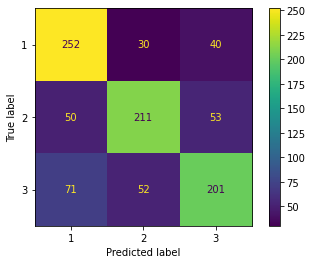


#### results for lowest loss model ####
Accuracy of: 0.7281


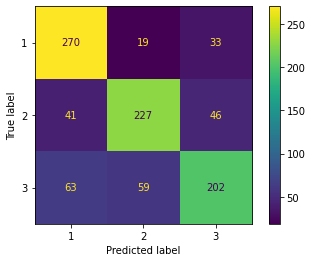


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.6994 @ epoch 2031
Best training loss (min) 0.7181 @ epoch 2339

Best validation accuracy (max) 0.642 @ epoch 1410
Best validation loss (min) 0.8225 @ epoch 1970

#### results for highest accuracy model ####
Accuracy of: 0.5985


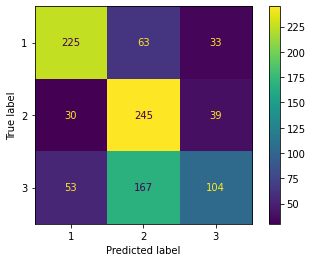


#### results for lowest loss model ####
Accuracy of: 0.5881


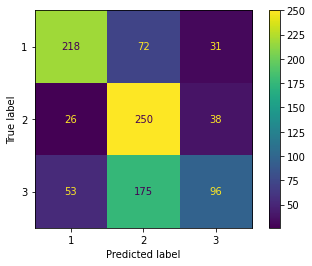


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.6992 @ epoch 2295
Best training loss (min) 0.7198 @ epoch 2491

Best validation accuracy (max) 0.6461 @ epoch 102
Best validation loss (min) 0.8112 @ epoch 857

#### results for highest accuracy model ####
Accuracy of: 0.8471


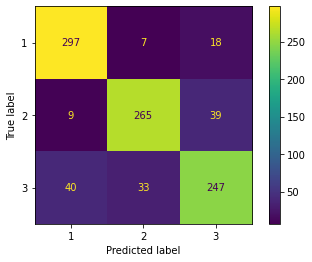


#### results for lowest loss model ####
Accuracy of: 0.866


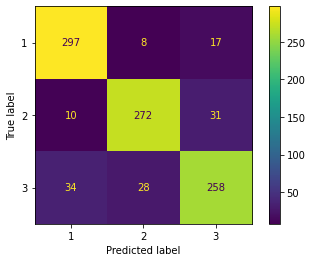

In [7]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/moredata/EEGNet/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/8/moredata/EEGNet/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/moredata/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset